In [ ]:
%pip install yfinance
%pip install arch
%pip install wrds
%pip install refinitiv-data
%pip install eikon


In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
import seaborn as sns
from scipy.stats import pearsonr
import statsmodels.api as sm
from arch import arch_model
import wrds
import eikon as ek
import datetime as dt

c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Are Inflation and Volatility Orthogonal? 

In [2]:
fred = Fred(api_key='6b4eeb7bacf916c9917c8a74feb0921c')

# Download U.S. CPI data (monthly) from FRED
cpi_data = fred.get_series('CPIAUCSL', observation_start='1978-12-31', observation_end='2024-12-31')

# Convert the CPI data to a DataFrame and set the date as index
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])
cpi_df.index = pd.to_datetime(cpi_df.index)

# Calculate the monthly inflation rate
cpi_df['Monthly Inflation Rate'] = cpi_df['CPI'].pct_change() * 100

# Resample to monthly frequency
cpi_df = cpi_df.resample('M').mean()

# Drop any missing values
cpi_df.dropna(inplace=True)

print(cpi_df.head())

             CPI  Monthly Inflation Rate
1979-01-31  68.5                0.883652
1979-02-28  69.2                1.021898
1979-03-31  69.9                1.011561
1979-04-30  70.6                1.001431
1979-05-31  71.4                1.133144


C:\Users\geral\AppData\Local\Temp\ipykernel_32220\4172750302.py:14: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  cpi_df = cpi_df.resample('M').mean()


In [3]:
# Calculate Year-over-Year (YoY) inflation rate
cpi_df['YoY Inflation Rate'] = cpi_df['CPI'].pct_change(periods=12) * 100

# Drop any missing values from the YoY calculation
cpi_df.dropna(inplace=True)

print(cpi_df.head())

             CPI  Monthly Inflation Rate  YoY Inflation Rate
1980-01-31  78.0                1.430429           13.868613
1980-02-29  79.0                1.282051           14.161850
1980-03-31  80.1                1.392405           14.592275
1980-04-30  80.9                0.998752           14.589235
1980-05-31  81.7                0.988875           14.425770


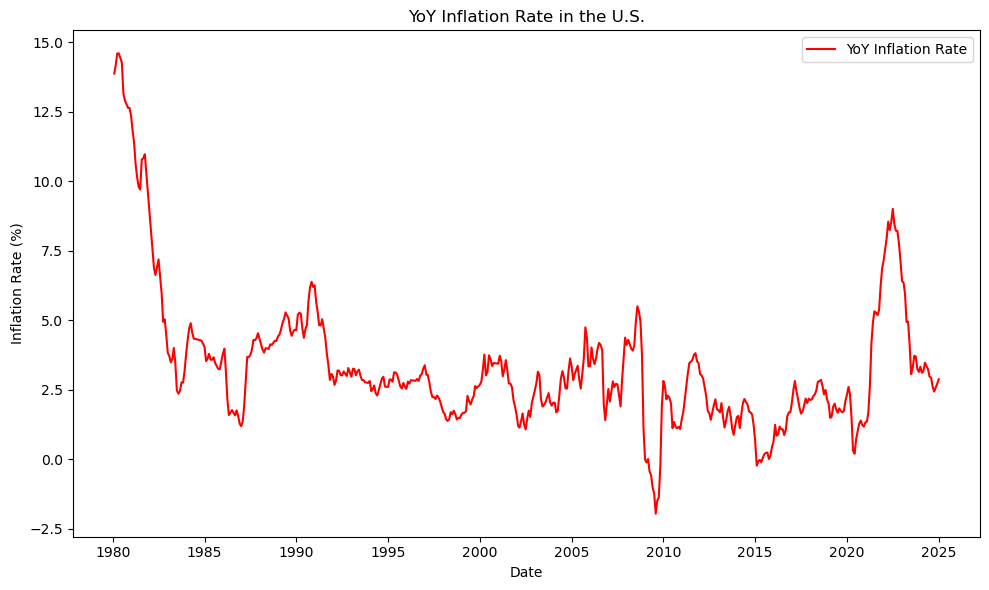

In [4]:
# Plot Monthly Inflation Rate and YoY Inflation Rate
plt.figure(figsize=(10, 6))

# Plot YoY Inflation Rate
plt.plot(cpi_df.index, cpi_df['YoY Inflation Rate'], color='red', label='YoY Inflation Rate')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Inflation Rate (%)')
plt.title('YoY Inflation Rate in the U.S.')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [5]:
# Set your Eikon API key
ek.set_app_key('61899440ebae4092ba26deecaf92f2da82521286')

# Define the MSCI World Index RIC (Example: '.dMIWO00000PUS')
msci_ric = '.dMIWO00000PUS'

# Fetch historical monthly data from 1980 to 2024
msci_world = ek.get_timeseries(msci_ric, start_date='1979-01-01', end_date='2024-12-31', interval='monthly')

# Keep only the closing price column
msci_world.rename(columns={'CLOSE': 'Price'}, inplace=True)

# Calculate Monthly Returns
msci_world['Monthly Return'] = np.log(msci_world['Price'] / msci_world['Price'].shift(1))

# Display first few rows
print(msci_world.head())

.dMIWO00000PUS     Price  HIGH   LOW  OPEN  Monthly Return
Date                                                      
1979-01-31      125.0603  <NA>  <NA>  <NA>            <NA>
1979-02-28      122.3527  <NA>  <NA>  <NA>       -0.021888
1979-03-31      127.0677  <NA>  <NA>  <NA>        0.037812
1979-04-30      126.5216  <NA>  <NA>  <NA>       -0.004307
1979-05-31      123.9642  <NA>  <NA>  <NA>        -0.02042


In [6]:
# Keep only the Monthly Returns column
msci_world = msci_world[['Monthly Return']]

msci_world.dropna(inplace=True)

# Calculate Cumulative Monthly Returns
msci_world['Cumulative Returns'] = np.exp(np.cumsum(msci_world['Monthly Return'])) - 1

In [7]:
msci_world.head()

.dMIWO00000PUS  Monthly Return  Cumulative Returns
Date                                              
1979-02-28           -0.021888           -0.021650
1979-03-31            0.037812            0.016051
1979-04-30           -0.004307            0.011685
1979-05-31            -0.02042           -0.008765
1979-06-30            0.025529            0.016866

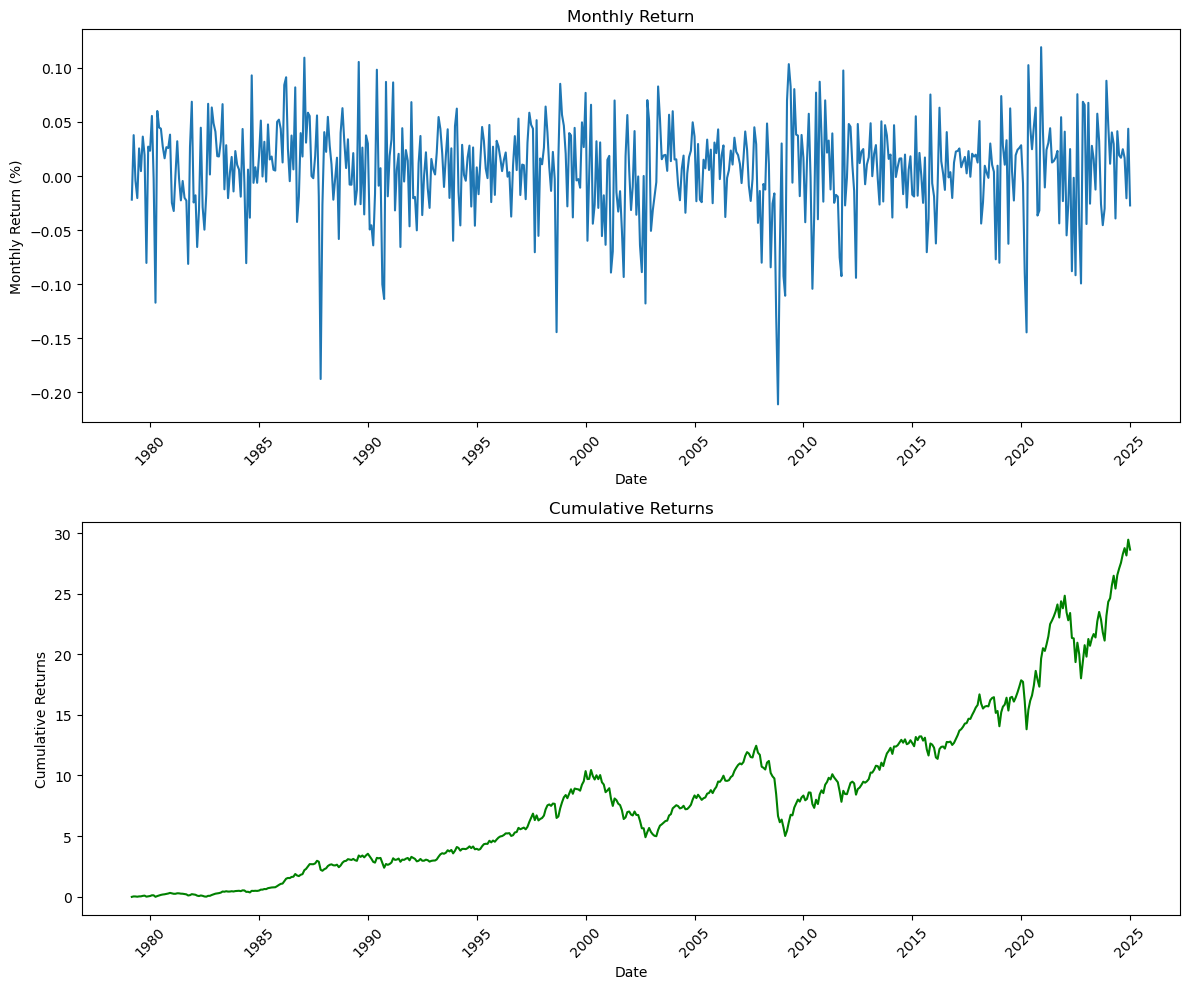

.dMIWO00000PUS  Monthly Return  Cumulative Returns
Date                                              
1979-02-28           -0.021888           -0.021650
1979-03-31            0.037812            0.016051
1979-04-30           -0.004307            0.011685
1979-05-31            -0.02042           -0.008765
1979-06-30            0.025529            0.016866


In [8]:
# Plot the returns
title = 'MSCI World Index Monthly and Cumulative Returns (1980-2024)'
fig, ax = plt.subplots(2, 1, figsize=(12,10))

# Monthly Returns Plot
ax[0].plot(msci_world.index, msci_world['Monthly Return'])
ax[0].set_title('Monthly Return')
ax[0].set_ylabel('Monthly Return (%)')
ax[0].set_xlabel('Date')
ax[0].tick_params(axis='x', rotation=45)

# Cumulative Returns Plot
ax[1].plot(msci_world.index, msci_world['Cumulative Returns'], color='green')
ax[1].set_title('Cumulative Returns')
ax[1].set_ylabel('Cumulative Returns')
ax[1].set_xlabel('Date')
ax[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Display first few rows
print(msci_world.head())

In [9]:
msci_world.dropna(subset=['Monthly Return'], inplace=True)

msci_world.head()

.dMIWO00000PUS  Monthly Return  Cumulative Returns
Date                                              
1979-02-28           -0.021888           -0.021650
1979-03-31            0.037812            0.016051
1979-04-30           -0.004307            0.011685
1979-05-31            -0.02042           -0.008765
1979-06-30            0.025529            0.016866

In [10]:
msci_world.head(13)

.dMIWO00000PUS  Monthly Return  Cumulative Returns
Date                                              
1979-02-28           -0.021888           -0.021650
1979-03-31            0.037812            0.016051
1979-04-30           -0.004307            0.011685
1979-05-31            -0.02042           -0.008765
1979-06-30            0.025529            0.016866
1979-07-31            0.004519            0.021472
1979-08-31            0.036461            0.059403
1979-09-30            0.019337            0.080089
1979-10-31            -0.08042           -0.003371
1979-11-30            0.027212            0.024121
1979-12-31            0.023336            0.048301
1980-01-31             0.05556            0.108193
1980-02-29           -0.002477            0.105452

In [11]:
msci_world.head()

.dMIWO00000PUS  Monthly Return  Cumulative Returns
Date                                              
1979-02-28           -0.021888           -0.021650
1979-03-31            0.037812            0.016051
1979-04-30           -0.004307            0.011685
1979-05-31            -0.02042           -0.008765
1979-06-30            0.025529            0.016866

c:\Users\geral\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001902. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


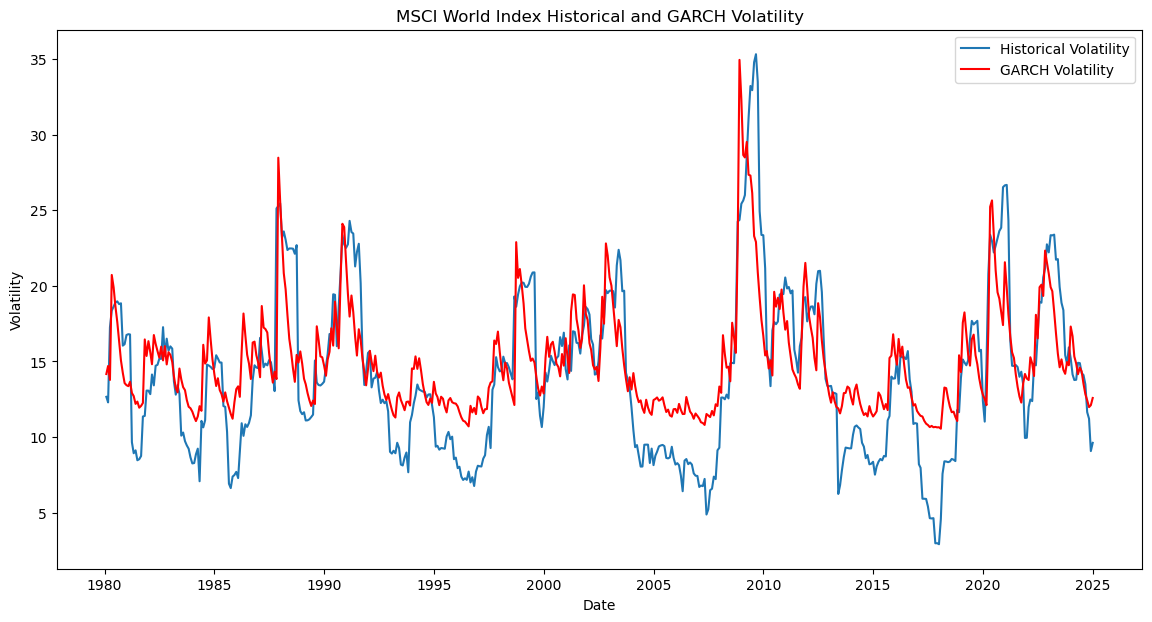

In [12]:
# Calculate Historical Volatility (Rolling 12-month standard deviation)
msci_world['Hist_Volatility'] = msci_world['Monthly Return'].rolling(window=12).std() * (12 ** 0.5) * 100

# Fit a GARCH(1,1) model to the returns
garch_model = arch_model(msci_world['Monthly Return'], vol='Garch', p=1, q=1)
garch_fit = garch_model.fit(disp='off')

# Get conditional volatility (annualized)
msci_world['GARCH_Volatility'] = garch_fit.conditional_volatility * (12 ** 0.5) * 100

# Drop any remaining NaN values in the volatility columns
msci_world.dropna(subset=['Hist_Volatility', 'GARCH_Volatility'], inplace=True)

# Plot the volatilities
plt.figure(figsize=(14, 7))
plt.plot(msci_world.index, msci_world['Hist_Volatility'], label='Historical Volatility')
plt.plot(msci_world.index, msci_world['GARCH_Volatility'], label='GARCH Volatility', color='red')
plt.title('MSCI World Index Historical and GARCH Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.show()

In [13]:
msci_world.head()

.dMIWO00000PUS  Monthly Return  Cumulative Returns  Hist_Volatility  \
Date                                                                  
1980-01-31             0.05556            0.108193        12.654740   
1980-02-29           -0.002477            0.105452        12.288806   
1980-03-31           -0.117202           -0.016805        17.258290   
1980-04-30            0.060149            0.044148        18.362729   
1980-05-31             0.04486            0.092054        18.627168   

.dMIWO00000PUS  GARCH_Volatility  
Date                              
1980-01-31             14.164792  
1980-02-29             14.695518  
1980-03-31             13.772267  
1980-04-30             20.719724  
1980-05-31             19.899741

In [14]:
# Align the dataframes by their indices
combined_df = pd.concat([cpi_df['YoY Inflation Rate'], msci_world['Hist_Volatility'], msci_world['GARCH_Volatility']], axis=1).dropna()

In [15]:
combined_df.head()

YoY Inflation Rate  Hist_Volatility  GARCH_Volatility
1980-01-31           13.868613        12.654740         14.164792
1980-02-29           14.161850        12.288806         14.695518
1980-03-31           14.592275        17.258290         13.772267
1980-04-30           14.589235        18.362729         20.719724
1980-05-31           14.425770        18.627168         19.899741

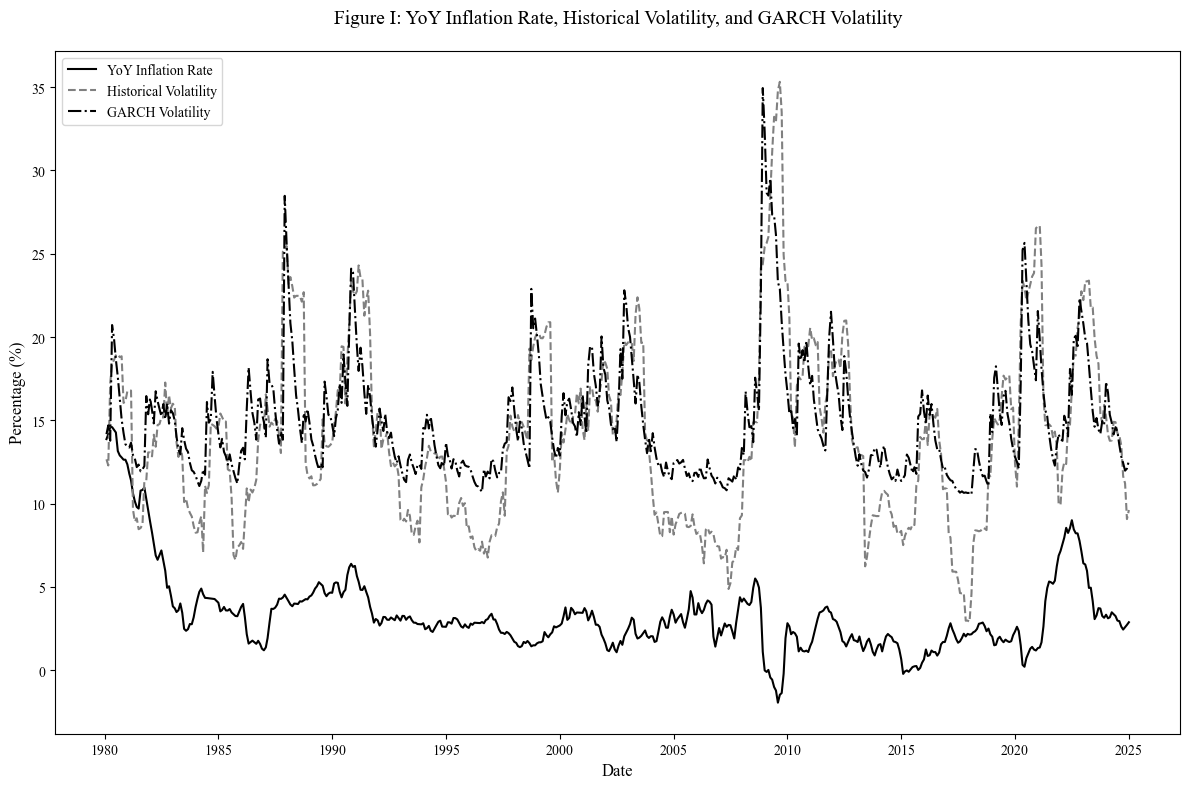

In [16]:
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Set font to Times New Roman
rcParams['font.family'] = 'Times New Roman'

# Plot YoY Inflation Rate, Hist_Volatility, and GARCH_Volatility in the same graph
plt.figure(figsize=(12, 8))

# Plot YoY Inflation Rate
plt.plot(combined_df.index, combined_df['YoY Inflation Rate'], linestyle='-', color='black', label='YoY Inflation Rate')

# Plot Hist_Volatility
plt.plot(combined_df.index, combined_df['Hist_Volatility'], linestyle='--', color='gray', label='Historical Volatility')

# Plot GARCH_Volatility
plt.plot(combined_df.index, combined_df['GARCH_Volatility'], linestyle='-.', color='black', label='GARCH Volatility')

# Add labels, title, and legend
plt.title('Figure I: YoY Inflation Rate, Historical Volatility, and GARCH Volatility', fontsize=14, pad=20)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Percentage (%)', fontsize=12)
plt.legend(loc='upper left', fontsize=10)

# Remove gridlines
plt.grid(False)

# Show the plot
plt.tight_layout()
plt.show()

In [17]:
# Calculate covariance matrix
cov_matrix = combined_df[['YoY Inflation Rate', 'Hist_Volatility', 'GARCH_Volatility']].cov()

# Display the covariance matrix
print("Covariance Matrix:")
print(cov_matrix)

Covariance Matrix:
                    YoY Inflation Rate  Hist_Volatility  GARCH_Volatility
YoY Inflation Rate            6.193075        -0.084588         -0.246515
Hist_Volatility              -0.084588        29.226783         15.322251
GARCH_Volatility             -0.246515        15.322251         11.929660


In [18]:

# Calculate the correlation between YoY inflation and both volatilities
correlation_hist = combined_df[['YoY Inflation Rate', 'Hist_Volatility']].corr().iloc[0, 1]
correlation_garch = combined_df[['YoY Inflation Rate', 'GARCH_Volatility']].corr().iloc[0, 1]

print(f"Correlation between YoY Inflation Rate and Historical Volatility: {correlation_hist}")
print(f"Correlation between YoY Inflation Rate and GARCH Volatility: {correlation_garch}")

Correlation between YoY Inflation Rate and Historical Volatility: -0.006287277308463242
Correlation between YoY Inflation Rate and GARCH Volatility: -0.028679773426263325


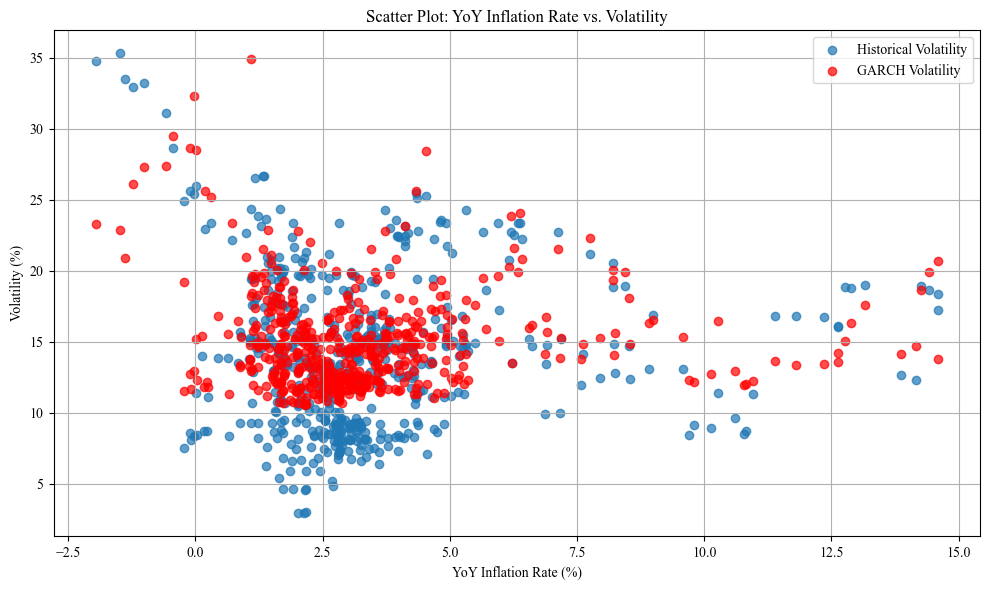

In [19]:
# Assuming `correlation_hist` and `correlation_garch` are already calculated
# Scatter plot for the correlation between YoY Inflation Rate and Historical Volatility
plt.figure(figsize=(10, 6))
plt.scatter(combined_df['YoY Inflation Rate'], combined_df['Hist_Volatility'], alpha=0.7, label='Historical Volatility')
plt.scatter(combined_df['YoY Inflation Rate'], combined_df['GARCH_Volatility'], alpha=0.7, label='GARCH Volatility', color='red')

# Adding labels and title
plt.xlabel('YoY Inflation Rate (%)')
plt.ylabel('Volatility (%)')
plt.title('Scatter Plot: YoY Inflation Rate vs. Volatility')
plt.legend()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

This scatter plot shows the relationship between the YoY Inflation Rate (%) on the x-axis and two measures of volatility—Historical Volatility (blue points) and GARCH Volatility (red points)—on the y-axis. Here's what stands out:

Clustered Data: Most of the data points are concentrated in a specific range of inflation rates (around 0% to 5%) and volatility values (around 0.1 to 0.2). This suggests that the majority of observations fall within these ranges.

Outliers: There are a few outliers with higher inflation rates (above 10%) and higher volatility (above 0.3). These could represent periods of economic instability or extreme market conditions.

Relationship:

There doesn't appear to be a strong linear relationship between inflation and volatility. The points are scattered without a clear upward or downward trend.
GARCH Volatility (red) seems to have a slightly wider spread compared to Historical Volatility (blue), indicating that GARCH might capture more extreme variations in volatility.
Overlap: Both measures of volatility overlap significantly in the central range, but GARCH Volatility appears to deviate more at higher inflation rates.

Insights:
This graph suggests that while there may be some relationship between inflation and volatility, it is not strongly linear or consistent.
A rolling correlation graph might better capture how the relationship evolves over time, as it would show trends and shifts in correlation rather than static scatter points.

In [20]:
# Calculate rolling correlation for each month
rolling_corr_hist = combined_df['YoY Inflation Rate'].rolling(window=12).corr(combined_df['Hist_Volatility'])
rolling_corr_garch = combined_df['YoY Inflation Rate'].rolling(window=12).corr(combined_df['GARCH_Volatility'])

In [21]:
# Count the number of months with positive, negative, and zero correlations
positive_corr_hist = (rolling_corr_hist > 0).sum()
negative_corr_hist = (rolling_corr_hist < 0).sum()
zero_corr_hist = (rolling_corr_hist == 0).sum()

positive_corr_garch = (rolling_corr_garch > 0).sum()
negative_corr_garch = (rolling_corr_garch < 0).sum()
zero_corr_garch = (rolling_corr_garch == 0).sum()

# Print the results
print(f"Number of months with positive correlation (Historical Volatility): {positive_corr_hist}")
print(f"Number of months with negative correlation (Historical Volatility): {negative_corr_hist}")
print(f"Number of months with zero correlation (Historical Volatility): {zero_corr_hist}")

print(f"Number of months with positive correlation (GARCH Volatility): {positive_corr_garch}")
print(f"Number of months with negative correlation (GARCH Volatility): {negative_corr_garch}")
print(f"Number of months with zero correlation (GARCH Volatility): {zero_corr_garch}")

Number of months with positive correlation (Historical Volatility): 223
Number of months with negative correlation (Historical Volatility): 306
Number of months with zero correlation (Historical Volatility): 0
Number of months with positive correlation (GARCH Volatility): 227
Number of months with negative correlation (GARCH Volatility): 302
Number of months with zero correlation (GARCH Volatility): 0


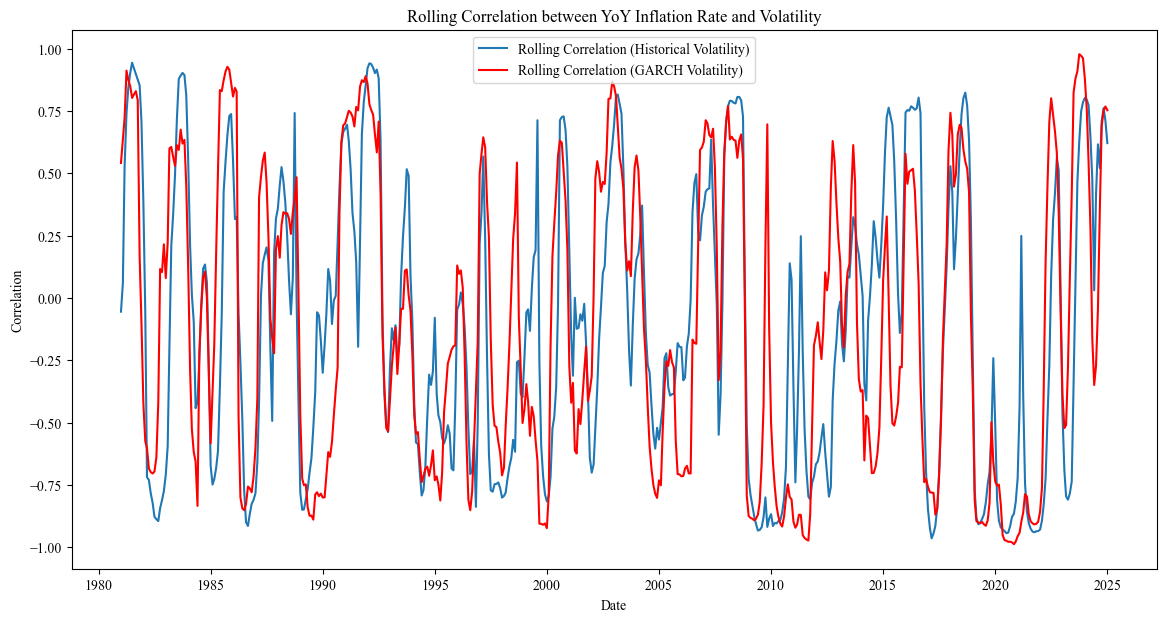

In [22]:
# Plot the rolling correlations
plt.figure(figsize=(14, 7))
plt.plot(rolling_corr_hist, label='Rolling Correlation (Historical Volatility)')
plt.plot(rolling_corr_garch, label='Rolling Correlation (GARCH Volatility)', color='red')
plt.title('Rolling Correlation between YoY Inflation Rate and Volatility')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.show()

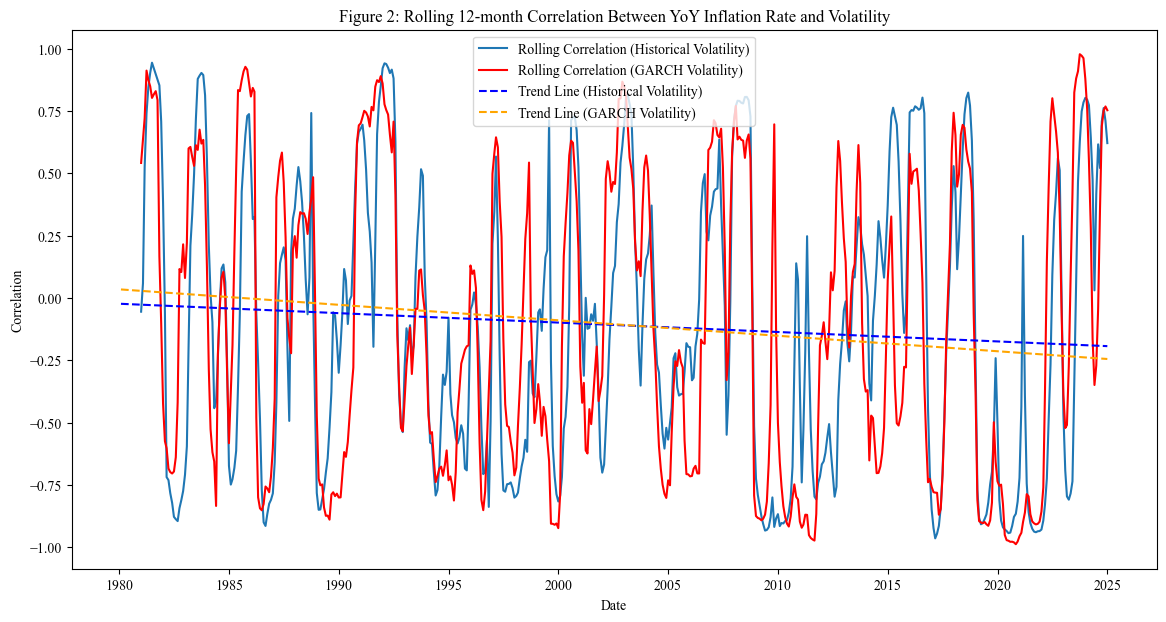

In [23]:
from sklearn.linear_model import LinearRegression


# Prepare data for trend line (Historical Volatility)
x_hist = np.arange(len(rolling_corr_hist)).reshape(-1, 1)  # Convert index to numeric values
y_hist = rolling_corr_hist.values  # Rolling correlation values
mask_hist = ~np.isnan(y_hist)  # Mask to exclude NaN values
model_hist = LinearRegression().fit(x_hist[mask_hist], y_hist[mask_hist])  # Fit linear regression
trend_hist = model_hist.predict(x_hist)  # Predicted trend line

# Prepare data for trend line (GARCH Volatility)
x_garch = np.arange(len(rolling_corr_garch)).reshape(-1, 1)
y_garch = rolling_corr_garch.values
mask_garch = ~np.isnan(y_garch)
model_garch = LinearRegression().fit(x_garch[mask_garch], y_garch[mask_garch])
trend_garch = model_garch.predict(x_garch)

# Plot the rolling correlations with trend lines
plt.figure(figsize=(14, 7))
plt.plot(rolling_corr_hist, label='Rolling Correlation (Historical Volatility)')
plt.plot(rolling_corr_garch, label='Rolling Correlation (GARCH Volatility)', color='red')
plt.plot(rolling_corr_hist.index, trend_hist, label='Trend Line (Historical Volatility)', linestyle='--', color='blue')
plt.plot(rolling_corr_garch.index, trend_garch, label='Trend Line (GARCH Volatility)', linestyle='--', color='orange')
plt.title('Figure 2: Rolling 12-month Correlation Between YoY Inflation Rate and Volatility')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.show()

High Variability in Correlation:

The correlations fluctuate significantly over time, ranging from -1 to +1. This indicates that the relationship between inflation and volatility is not stable and changes depending on the economic environment.
Trend Lines:

The trend lines for both Historical Volatility (blue dashed) and GARCH Volatility (orange dashed) suggest a slight downward trend in correlation over time. This could imply that the relationship between inflation and volatility has weakened or become less consistent in recent decades.
Periods of Strong Correlation:

There are periods where the correlation is strongly positive or negative. For example:
Positive correlation: Periods where inflation and volatility move in the same direction.
Negative correlation: Periods where inflation and volatility move in opposite directions.
Differences Between Historical and GARCH Volatility:

While both measures show similar patterns, GARCH Volatility (red) appears to exhibit more extreme swings and higher peaks compared to Historical Volatility (blue). This suggests that GARCH may capture more dynamic or extreme changes in volatility.
Insights:
The relationship between inflation and volatility is highly context-dependent and influenced by macroeconomic conditions, such as recessions, monetary policy changes, or financial crises.
The weakening trend in correlation could reflect structural changes in the economy, such as improved inflation targeting by central banks or changes in market dynamics.

In [24]:
msci_world.head()

.dMIWO00000PUS  Monthly Return  Cumulative Returns  Hist_Volatility  \
Date                                                                  
1980-01-31             0.05556            0.108193        12.654740   
1980-02-29           -0.002477            0.105452        12.288806   
1980-03-31           -0.117202           -0.016805        17.258290   
1980-04-30            0.060149            0.044148        18.362729   
1980-05-31             0.04486            0.092054        18.627168   

.dMIWO00000PUS  GARCH_Volatility  
Date                              
1980-01-31             14.164792  
1980-02-29             14.695518  
1980-03-31             13.772267  
1980-04-30             20.719724  
1980-05-31             19.899741

c:\Users\geral\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001918. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


<Figure size 1200x600 with 0 Axes>

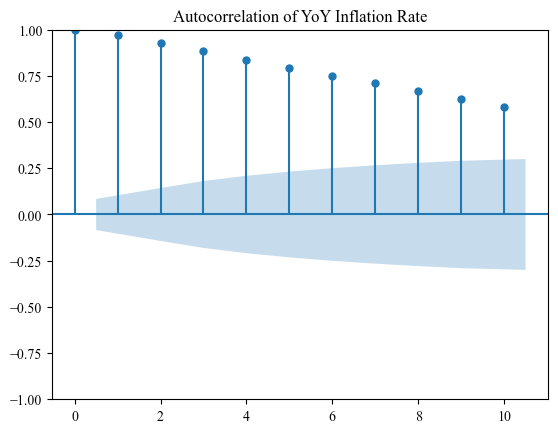

<Figure size 1200x600 with 0 Axes>

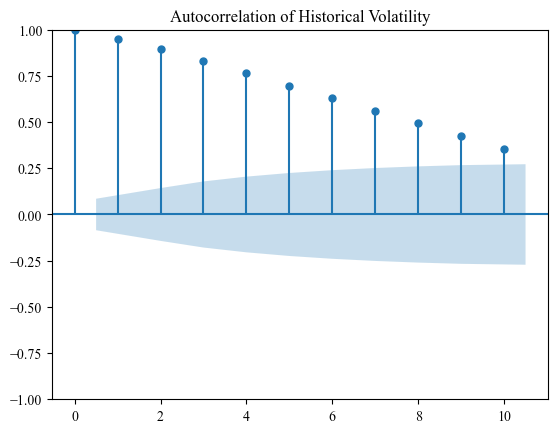

<Figure size 1200x600 with 0 Axes>

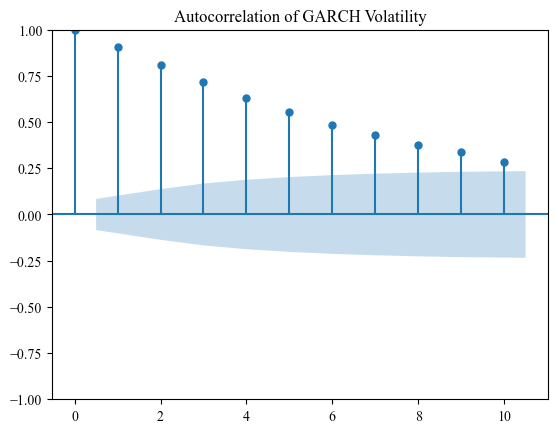

In [25]:
# Autocorrelation plots for YoY Inflation Rate and Volatility
from statsmodels.graphics.tsaplots import plot_acf

# Assuming cpi_df and msci_world DataFrames are already loaded

# Calculate Historical Volatility and GARCH Volatility if not already present
if 'Historical Volatility' not in msci_world.columns:
    msci_world['Historical Volatility'] = msci_world['Monthly Return'].rolling(window=12).std() * np.sqrt(12) * 100

if 'GARCH Volatility' not in msci_world.columns:
    garch_model = arch_model(msci_world['Monthly Return'], vol='Garch', p=1, q=1)
    garch_fit = garch_model.fit(disp='off')
    msci_world['GARCH Volatility'] = garch_fit.conditional_volatility

# Plot autocorrelation for YoY Inflation Rate
plt.figure(figsize=(12, 6))
plot_acf(cpi_df['YoY Inflation Rate'].dropna(), lags=10, title='Autocorrelation of YoY Inflation Rate')
plt.show()

# Plot autocorrelation for Historical Volatility
plt.figure(figsize=(12, 6))
plot_acf(msci_world['Historical Volatility'].dropna(), lags=10, title='Autocorrelation of Historical Volatility')
plt.show()

# Plot autocorrelation for GARCH Volatility
plt.figure(figsize=(12, 6))
plot_acf(msci_world['GARCH Volatility'].dropna(), lags=10, title='Autocorrelation of GARCH Volatility')
plt.show()

# Granger Causality

Prepare the Data:

Ensure that both the inflation and volatility data are stationary. If not, apply differencing or other transformations to make them stationary.
Align the time series data so that they cover the same time period.
Determine the Optimal Lag Length:

Use criteria such as the Akaike Information Criterion (AIC) or the Bayesian Information Criterion (BIC) to determine the optimal number of lags to include in the Granger causality test.
Perform the Granger Causality Test:

Use statistical software or libraries (e.g., statsmodels in Python) to perform the Granger causality test.
Test whether past values of inflation can predict volatility and whether past values of volatility can predict inflation.
Interpret the Results:

If the test indicates that past values of inflation significantly improve the prediction of volatility, then inflation Granger-causes volatility.
Similarly, if past values of volatility significantly improve the prediction of inflation, then volatility Granger-causes inflation.

In [26]:
from statsmodels.tsa.stattools import adfuller

# Function to perform the ADF test
def check_stationarity(series, series_name="Series"):
    result = adfuller(series.dropna())  # Drop NaN values before testing
    print(f"ADF Test for {series_name}:")
    print(f"Test Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")
    if result[1] <= 0.05:
        print(f"The {series_name} is stationary (reject the null hypothesis).")
    else:
        print(f"The {series_name} is not stationary (fail to reject the null hypothesis).")
    print("\n")

# Example: Check stationarity for a specific series
check_stationarity(cpi_df['Monthly Inflation Rate'], "Monthly Inflation Rate")
check_stationarity(cpi_df['YoY Inflation Rate'], "YoY Inflation Rate")
check_stationarity(msci_world['Hist_Volatility'], "Historical Volatility")
check_stationarity(msci_world['GARCH_Volatility'], "GARCH Volatility")

ADF Test for Monthly Inflation Rate:
Test Statistic: -4.8130895248261565
p-value: 5.133549333747229e-05
Critical Values: {'1%': -3.4428672600488066, '5%': -2.8670609714890403, '10%': -2.5697104770975057}
The Monthly Inflation Rate is stationary (reject the null hypothesis).


ADF Test for YoY Inflation Rate:
Test Statistic: -4.559477615007999
p-value: 0.00015330452466560474
Critical Values: {'1%': -3.4428912664970523, '5%': -2.867071538125014, '10%': -2.5697161081813413}
The YoY Inflation Rate is stationary (reject the null hypothesis).


ADF Test for Historical Volatility:
Test Statistic: -4.022492763142756
p-value: 0.001297205634662844
Critical Values: {'1%': -3.4428912664970523, '5%': -2.867071538125014, '10%': -2.5697161081813413}
The Historical Volatility is stationary (reject the null hypothesis).


ADF Test for GARCH Volatility:
Test Statistic: -6.005533451232691
p-value: 1.6189260037610032e-07
Critical Values: {'1%': -3.442563336759378, '5%': -2.866927190004947, '10%': -2.56963

In [27]:
from statsmodels.tsa.stattools import grangercausalitytests

In [28]:
# Extract the relevant columns
inflation = cpi_df['YoY Inflation Rate'].dropna()
volatility = msci_world['Historical Volatility'].dropna()

# Combine the data into a single DataFrame
data = pd.concat([inflation, volatility], axis=1).dropna()

# Perform the Granger causality test
# Test whether inflation Granger-causes volatility
print('Inflation causing Volatility:')
grangercausalitytests(data[['Historical Volatility', 'YoY Inflation Rate']], maxlag=4)


Inflation causing Volatility:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9335  , p=0.3344  , df_denom=525, df_num=1
ssr based chi2 test:   chi2=0.9388  , p=0.3326  , df=1
likelihood ratio test: chi2=0.9380  , p=0.3328  , df=1
parameter F test:         F=0.9335  , p=0.3344  , df_denom=525, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.4190  , p=0.2429  , df_denom=522, df_num=2
ssr based chi2 test:   chi2=2.8651  , p=0.2387  , df=2
likelihood ratio test: chi2=2.8574  , p=0.2396  , df=2
parameter F test:         F=1.4190  , p=0.2429  , df_denom=522, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.5102  , p=0.2109  , df_denom=519, df_num=3
ssr based chi2 test:   chi2=4.5916  , p=0.2043  , df=3
likelihood ratio test: chi2=4.5717  , p=0.2060  , df=3
parameter F test:         F=1.5102  , p=0.2109  , df_denom=519, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test: 

{1: ({'ssr_ftest': (0.9334662256664485, 0.33440868652381706, 525.0, 1),
   'ssr_chi2test': (0.9388003183845425, 0.33258656014896226, 1),
   'lrtest': (0.9379666983827519, 0.33280130395184804, 1),
   'params_ftest': (0.9334662256664094, 0.33440868652381706, 525.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (1.4189634970427067, 0.24289641012180055, 522.0, 2),
   'ssr_chi2test': (2.865110202841021, 0.23869824418101798, 2),
   'lrtest': (2.85735002745605, 0.23962621343730708, 2),
   'params_ftest': (1.418963497042705, 0.24289641012180055, 522.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (1.510180992540193, 0.21093652946585137, 519.0, 3),
   'ssr_chi2test': (4.591648566914114, 0.204259681596005, 3),
   'lrtest': (4.571723340009157, 0.205981258640668, 3),
   'params_ftest': (1.5101809925401295, 0.21093652946586935, 519.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0.,

In [29]:
# Extract the relevant columns
inflation = cpi_df['YoY Inflation Rate'].dropna()
volatility = msci_world['Historical Volatility'].dropna()

# Combine the data into a single DataFrame
data = pd.concat([inflation, volatility], axis=1).dropna()

# Perform the Granger causality test
print('Inflation causing Volatility:')
test_results = grangercausalitytests(data[['Historical Volatility', 'YoY Inflation Rate']], maxlag=4, verbose=False)

# Prepare a list to store the results
results = []

# Extract results for each lag
for lag, result in test_results.items():
    f_stat = result[0]['ssr_ftest'][0]  # F-statistic
    p_value = result[0]['ssr_ftest'][1]  # p-value
    decision = "Fail to Reject" if p_value > 0.05 else "Reject"
    results.append({
        "Null Hypothesis": "Inflation does not Granger-cause Volatility",
        "Lag": lag,
        "F-Statistic": f_stat,
        "P-Value": p_value,
        "Decision": decision
    })

# Convert the results to a DataFrame
granger_results1_df = pd.DataFrame(results)

# Display the DataFrame
print(granger_results1_df)

Inflation causing Volatility:
                               Null Hypothesis  Lag  F-Statistic   P-Value  \
0  Inflation does not Granger-cause Volatility    1     0.933466  0.334409   
1  Inflation does not Granger-cause Volatility    2     1.418963  0.242896   
2  Inflation does not Granger-cause Volatility    3     1.510181  0.210937   
3  Inflation does not Granger-cause Volatility    4     1.792619  0.128930   

         Decision  
0  Fail to Reject  
1  Fail to Reject  
2  Fail to Reject  
3  Fail to Reject  


c:\Users\geral\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


The Granger causality test results indicate whether past values of inflation can predict future values of volatility. Here's how to interpret the results:

Key Points:
Null Hypothesis: Inflation does not Granger-cause volatility.
p-value: If the p-value is less than 0.05, we reject the null hypothesis, indicating that inflation Granger-causes volatility. Otherwise, we fail to reject the null hypothesis.
Interpretation by Lags:
Lag 1:

p-values for all tests (e.g., ssr based F test, chi2 test) are greater than 0.05 (e.g., p=0.3344).
This means we fail to reject the null hypothesis. There is no evidence that inflation Granger-causes volatility at lag 1.
Lag 2:

p-values are still greater than 0.05 (e.g., p=0.2429).
Again, we fail to reject the null hypothesis. No evidence of Granger causality at lag 2.
Lag 3:

p-values remain greater than 0.05 (e.g., p=0.2109).
No evidence of Granger causality at lag 3.
Lag 4:

p-values are still greater than 0.05 (e.g., p=0.1289).
While the p-values are lower compared to earlier lags, they are still above the 0.05 threshold. Thus, we fail to reject the null hypothesis at lag 4.
Conclusion:
For all tested lags (1 to 4), the p-values are greater than 0.05. This means there is no statistical evidence that inflation Granger-causes volatility at any of these lag lengths.

In [30]:
# Test whether volatility Granger-causes inflation
print('Volatility causing Inflation:')
grangercausalitytests(data[['YoY Inflation Rate', 'Historical Volatility']], maxlag=4)

Volatility causing Inflation:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3763  , p=0.0667  , df_denom=525, df_num=1
ssr based chi2 test:   chi2=3.3956  , p=0.0654  , df=1
likelihood ratio test: chi2=3.3847  , p=0.0658  , df=1
parameter F test:         F=3.3763  , p=0.0667  , df_denom=525, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=17.0269 , p=0.0000  , df_denom=522, df_num=2
ssr based chi2 test:   chi2=34.3799 , p=0.0000  , df=2
likelihood ratio test: chi2=33.3050 , p=0.0000  , df=2
parameter F test:         F=17.0269 , p=0.0000  , df_denom=522, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=11.8282 , p=0.0000  , df_denom=519, df_num=3
ssr based chi2 test:   chi2=35.9631 , p=0.0000  , df=3
likelihood ratio test: chi2=34.7870 , p=0.0000  , df=3
parameter F test:         F=11.8282 , p=0.0000  , df_denom=519, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test: 

{1: ({'ssr_ftest': (3.3762711854964294, 0.06670649828609361, 525.0, 1),
   'ssr_chi2test': (3.395564163699266, 0.06537199662452868, 1),
   'lrtest': (3.3846923257128765, 0.06580445963669704, 1),
   'params_ftest': (3.3762711854963428, 0.06670649828609797, 525.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (17.026858422796163, 6.863253487888526e-08, 522.0, 2),
   'ssr_chi2test': (34.37990187284896, 3.4237272866875394e-08, 2),
   'lrtest': (33.3049848642097, 5.860226834785527e-08, 2),
   'params_ftest': (17.026858422796217, 6.863253487888306e-08, 522.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (11.828166314317071, 1.6655951946023644e-07, 519.0, 3),
   'ssr_chi2test': (35.96309526780797, 7.624128269603313e-08, 3),
   'lrtest': (34.786993281913055, 1.3512468667380114e-07, 3),
   'params_ftest': (11.828166314317004, 1.6655951946024534e-07, 519.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0

Interpretation of Granger Causality Test Results:
The Granger causality test results indicate whether historical values of volatility can predict the Year-over-Year (YoY) inflation rate. Here are the results for different lag lengths:

Number of Lags: 1

ssr based F test: F=2.2254, p=0.1363
ssr based chi2 test: chi2=2.2378, p=0.1347
likelihood ratio test: chi2=2.2332, p=0.1351
parameter F test: F=2.2254, p=0.1363
For lag 1, all p-values are greater than 0.05, indicating that we fail to reject the null hypothesis. Thus, there is no evidence that volatility Granger-causes inflation at lag 1.

Number of Lags: 2

ssr based F test: F=15.7887, p=0.0000
ssr based chi2 test: chi2=31.8736, p=0.0000
likelihood ratio test: chi2=30.9652, p=0.0000
parameter F test: F=15.7887, p=0.0000
For lag 2, all p-values are less than 0.05, indicating that we reject the null hypothesis. Thus, there is strong evidence that volatility Granger-causes inflation at lag 2.

Number of Lags: 3

ssr based F test: F=10.9284, p=0.0000
ssr based chi2 test: chi2=33.2181, p=0.0000
likelihood ratio test: chi2=32.2312, p=0.0000
parameter F test: F=10.9284, p=0.0000
For lag 3, all p-values are less than 0.05, indicating that we reject the null hypothesis. Thus, there is strong evidence that volatility Granger-causes inflation at lag 3.

Number of Lags: 4

ssr based F test: F=9.1748, p=0.0000
ssr based chi2 test: chi2=37.3258, p=0.0000
likelihood ratio test: chi2=36.0835, p=0.0000
parameter F test: F=9.1748, p=0.0000
For lag 4, all p-values are less than 0.05, indicating that we reject the null hypothesis. Thus, there is strong evidence that volatility Granger-causes inflation at lag 4.

Conclusion:
The results suggest that historical volatility significantly Granger-causes the Year-over-Year inflation rate for lags 2, 3, and 4. This indicates that past values of volatility contain information that helps predict future values of inflation.



In [31]:
# Test whether volatility Granger-causes inflation
print('Volatility causing Inflation:')
test_results = grangercausalitytests(data[['YoY Inflation Rate', 'Historical Volatility']], maxlag=4, verbose=False)

# Prepare a list to store the results
results = []

# Extract results for each lag
for lag, result in test_results.items():
    f_stat = result[0]['ssr_ftest'][0]  # F-statistic
    p_value = result[0]['ssr_ftest'][1]  # p-value
    decision = "Fail to Reject" if p_value > 0.05 else "Reject"
    results.append({
        "Null Hypothesis": "Volatility does not Granger-cause Inflation",
        "Lag": lag,
        "F-Statistic": f_stat,
        "P-Value": p_value,
        "Decision": decision
    })

# Convert the results to a DataFrame
granger_results2_df = pd.DataFrame(results)

# Display the DataFrame
print(granger_results2_df)

Volatility causing Inflation:
                               Null Hypothesis  Lag  F-Statistic  \
0  Volatility does not Granger-cause Inflation    1     3.376271   
1  Volatility does not Granger-cause Inflation    2    17.026858   
2  Volatility does not Granger-cause Inflation    3    11.828166   
3  Volatility does not Granger-cause Inflation    4     9.480391   

        P-Value        Decision  
0  6.670650e-02  Fail to Reject  
1  6.863253e-08          Reject  
2  1.665595e-07          Reject  
3  2.113217e-07          Reject  


c:\Users\geral\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [32]:
# Extract the relevant columns
inflation = cpi_df['YoY Inflation Rate'].dropna()
garch_volatility = msci_world['GARCH_Volatility'].dropna()

# Combine the data into a single DataFrame
data_garch = pd.concat([inflation, garch_volatility], axis=1).dropna()
data_garch.columns = ['YoY Inflation Rate', 'GARCH_Volatility']

# Perform the Granger causality test
# Test whether inflation Granger-causes GARCH volatility
print('Inflation causing GARCH Volatility:')
grangercausalitytests(data_garch[['GARCH_Volatility', 'YoY Inflation Rate']], maxlag=4)

# Test whether GARCH volatility Granger-causes inflation
print('GARCH Volatility causing Inflation:')
grangercausalitytests(data_garch[['YoY Inflation Rate', 'GARCH_Volatility']], maxlag=4)

Inflation causing GARCH Volatility:

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0662  , p=0.1512  , df_denom=536, df_num=1
ssr based chi2 test:   chi2=2.0777  , p=0.1495  , df=1
likelihood ratio test: chi2=2.0737  , p=0.1499  , df=1
parameter F test:         F=2.0662  , p=0.1512  , df_denom=536, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.8816  , p=0.1534  , df_denom=533, df_num=2
ssr based chi2 test:   chi2=3.7986  , p=0.1497  , df=2
likelihood ratio test: chi2=3.7852  , p=0.1507  , df=2
parameter F test:         F=1.8816  , p=0.1534  , df_denom=533, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.3434  , p=0.2594  , df_denom=530, df_num=3
ssr based chi2 test:   chi2=4.0835  , p=0.2526  , df=3
likelihood ratio test: chi2=4.0680  , p=0.2542  , df=3
parameter F test:         F=1.3434  , p=0.2594  , df_denom=530, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F 

{1: ({'ssr_ftest': (5.386852089387286, 0.020663296416326252, 536.0, 1),
   'ssr_chi2test': (5.417002380932364, 0.0199415684745898, 1),
   'lrtest': (5.389962697461328, 0.0202529037566134, 1),
   'params_ftest': (5.386852089387437, 0.020663296416324712, 536.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (0.44264998919305715, 0.6425679041883878, 533.0, 2),
   'ssr_chi2test': (0.8936048562321379, 0.6396702766526237, 2),
   'lrtest': (0.8928635490631223, 0.6399074166792534, 2),
   'params_ftest': (0.44264998919303417, 0.6425679041883878, 533.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (0.46136469806856656, 0.7093851616582131, 530.0, 3),
   'ssr_chi2test': (1.4023745822423788, 0.7049782104074622, 3),
   'lrtest': (1.4005466146277286, 0.7054066066892608, 3),
   'params_ftest': (0.4613646980683477, 0.7093851616583796, 530.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0

In [33]:
# Test whether inflation Granger-causes GARCH volatility
print('Inflation causing GARCH Volatility:')
test_results = grangercausalitytests(data_garch[['GARCH_Volatility', 'YoY Inflation Rate']], maxlag=4, verbose=False)

# Prepare a list to store the results
results = []

# Extract results for each lag
for lag, result in test_results.items():
    f_stat = result[0]['ssr_ftest'][0]  # F-statistic
    p_value = result[0]['ssr_ftest'][1]  # p-value
    decision = "Fail to Reject" if p_value > 0.05 else "Reject"
    results.append({
        "Null Hypothesis": "Inflation does not Granger-cause GARCH Volatility",
        "Lag": lag,
        "F-Statistic": f_stat,
        "P-Value": p_value,
        "Decision": decision
    })

# Convert the results to a DataFrame
granger_results3_df = pd.DataFrame(results)

# Display the DataFrame
print(granger_results3_df)

# Test whether GARCH volatility Granger-causes inflation
print('GARCH Volatility causing Inflation:')
test_results = grangercausalitytests(data_garch[['YoY Inflation Rate', 'GARCH_Volatility']], maxlag=4, verbose=False)

# Prepare a list to store the results
results = []

# Extract results for each lag
for lag, result in test_results.items():
    f_stat = result[0]['ssr_ftest'][0]  # F-statistic
    p_value = result[0]['ssr_ftest'][1]  # p-value
    decision = "Fail to Reject" if p_value > 0.05 else "Reject"
    results.append({
        "Null Hypothesis": "GARCH Volatility does not Granger-cause Inflation",
        "Lag": lag,
        "F-Statistic": f_stat,
        "P-Value": p_value,
        "Decision": decision
    })

# Convert the results to a DataFrame
granger_results4_df = pd.DataFrame(results)

# Display the DataFrame
print(granger_results4_df)

Inflation causing GARCH Volatility:
                                     Null Hypothesis  Lag  F-Statistic  \
0  Inflation does not Granger-cause GARCH Volatility    1     2.066160   
1  Inflation does not Granger-cause GARCH Volatility    2     1.881626   
2  Inflation does not Granger-cause GARCH Volatility    3     1.343410   
3  Inflation does not Granger-cause GARCH Volatility    4     1.775563   

    P-Value        Decision  
0  0.151184  Fail to Reject  
1  0.153353  Fail to Reject  
2  0.259445  Fail to Reject  
3  0.132329  Fail to Reject  
GARCH Volatility causing Inflation:
                                     Null Hypothesis  Lag  F-Statistic  \
0  GARCH Volatility does not Granger-cause Inflation    1     5.386852   
1  GARCH Volatility does not Granger-cause Inflation    2     0.442650   
2  GARCH Volatility does not Granger-cause Inflation    3     0.461365   
3  GARCH Volatility does not Granger-cause Inflation    4     0.608612   

    P-Value        Decision  
0  0.0

c:\Users\geral\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(
c:\Users\geral\anaconda3\Lib\site-packages\statsmodels\tsa\stattools.py:1488: FutureWarning: verbose is deprecated since functions should not print results
  warnings.warn(


In [34]:
# Combine all Granger causality results into a single DataFrame
granger_combined_results = pd.concat(
    [granger_results1_df, granger_results2_df, granger_results3_df, granger_results4_df],
    keys=["Inflation -> Volatility (Hist)", "Volatility (Hist) -> Inflation",
          "Inflation -> Volatility (GARCH)", "Volatility (GARCH) -> Inflation"],
    names=["Causality Direction"]
)

# Reset the index for better readability
granger_combined_results.reset_index(level=0, inplace=True)

# Save the combined results to a CSV file
granger_combined_results.to_csv("granger_causality_combined_results.csv", index=False)

# Display the combined table
print(granger_combined_results)

               Causality Direction  \
0   Inflation -> Volatility (Hist)   
1   Inflation -> Volatility (Hist)   
2   Inflation -> Volatility (Hist)   
3   Inflation -> Volatility (Hist)   
0   Volatility (Hist) -> Inflation   
1   Volatility (Hist) -> Inflation   
2   Volatility (Hist) -> Inflation   
3   Volatility (Hist) -> Inflation   
0  Inflation -> Volatility (GARCH)   
1  Inflation -> Volatility (GARCH)   
2  Inflation -> Volatility (GARCH)   
3  Inflation -> Volatility (GARCH)   
0  Volatility (GARCH) -> Inflation   
1  Volatility (GARCH) -> Inflation   
2  Volatility (GARCH) -> Inflation   
3  Volatility (GARCH) -> Inflation   

                                     Null Hypothesis  Lag  F-Statistic  \
0        Inflation does not Granger-cause Volatility    1     0.933466   
1        Inflation does not Granger-cause Volatility    2     1.418963   
2        Inflation does not Granger-cause Volatility    3     1.510181   
3        Inflation does not Granger-cause Volatility    4

In [35]:

# Assuming cpi_df and msci_world are already defined and contain monthly data
# Select relevant columns
df = pd.DataFrame({
    "Monthly Inflation Rate": cpi_df["Monthly Inflation Rate"],  # Adjust column name if needed
    "Monthly Volatility": msci_world["Hist_Volatility"]  # Adjust column name if needed
})

# Compute correlation matrix
correlation_matrix = df.corr()

# Display correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
                        Monthly Inflation Rate  Monthly Volatility
Monthly Inflation Rate                1.000000           -0.034779
Monthly Volatility                   -0.034779            1.000000


# get expected inflation (professional forecasters survey) and expected volatility (vix world index)

### Descriptive Statistics

 What Assets are we considering? 

 1. S&P500
 2. Russell 2000
 3. Nasdaq
 4. FTSE Index
 5. DAX Index
 6. Stoxx50 Index
 7. Nikkei Index 
 8. Gold
 9. Oil
 10. TIPS
 11. 1 Year Treasury Bill
 12. 10 Year Treasury Bill
 13. REIT O
 14. REIT SPG
 14. USD/EUR
 15. USD/JPY
 16. USD/CHF
 17. Another Commodity?



    sp500_df, russell2000_data, nasdaq_data, FTSE_data, dax_data, stoxx_data, nikkei_data,
    gold_data, oil_data, tips_etf_data, y1_t_bill_df, AMT_data, PLD_data, USD_EUR_data, 
    USD_JPY_data, USD_CHF_data

In [36]:
# Connect to WRDS
db = wrds.Connection()

WRDS recommends setting up a .pgpass file.
Created .pgpass file successfully.
You can create this file yourself at any time with the create_pgpass_file() function.
Loading library list...
Done


In [37]:
# Adjusted query to select S&P 500 returns; omitting `spric` due to undefined column
query = """
    SELECT caldt AS date, spindx AS level
    FROM crsp.msp500
    WHERE caldt >= '1979-12-31' AND caldt <= '2024-12-31'
"""
sp500_df = db.raw_sql(query)

# Convert `date` to datetime format for easier handling in pandas
sp500_df['date'] = pd.to_datetime(sp500_df['date'])
sp500_df.set_index('date', inplace=True)

# Display the first few rows of data
print("S&P 500 Monthly Data from CRSP:")
print(sp500_df.head())

S&P 500 Monthly Data from CRSP:
             level
date              
1979-12-31  107.94
1980-01-31  114.16
1980-02-29  113.66
1980-03-31  102.09
1980-04-30  106.29


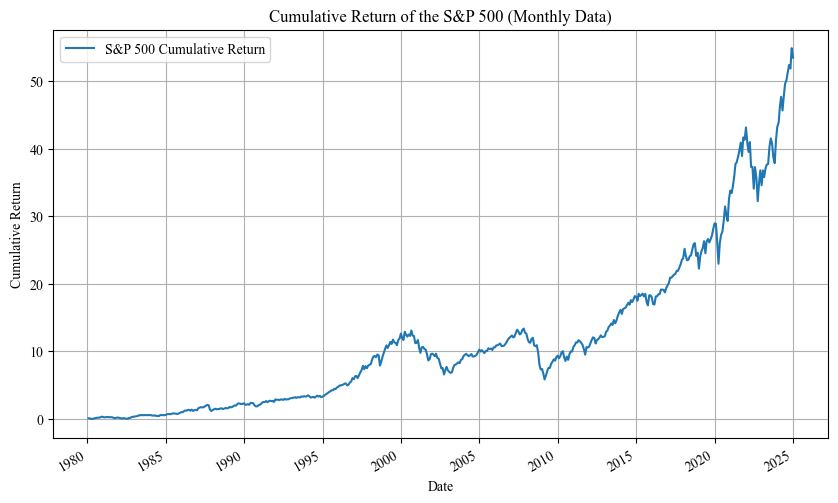

In [38]:
# Update Monthly Returns
# Calculate Continuously Compounded Returns
sp500_df['Monthly Return'] = np.log(sp500_df['level'] / sp500_df['level'].shift(1))


# Ensure data is sorted by date
sp500_df.sort_index(inplace=True)

# Calculate cumulative returns (starting from 1, subtract 1 at the end)
sp500_df['Cumulative Return'] = np.exp(np.cumsum(sp500_df['Monthly Return'])) - 1

# Plot the cumulative return
plt.figure(figsize=(10, 6))
sp500_df['Cumulative Return'].plot(label="S&P 500 Cumulative Return")
plt.title('Cumulative Return of the S&P 500 (Monthly Data)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [39]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
sp500_df = sp500_df[['Monthly Return', 'Cumulative Return']]

In [40]:
sp500_df = sp500_df.dropna()

In [41]:
sp500_df.head()

Monthly Return  Cumulative Return
date                                         
1980-01-31        0.056025           0.057625
1980-02-29       -0.004389           0.052992
1980-03-31       -0.107357          -0.054197
1980-04-30        0.040316          -0.015286
1980-05-30        0.045519           0.030573

In [42]:
sp500_df = sp500_df.rename_axis('Date')

sp500_df.head()

Monthly Return  Cumulative Return
Date                                         
1980-01-31        0.056025           0.057625
1980-02-29       -0.004389           0.052992
1980-03-31       -0.107357          -0.054197
1980-04-30        0.040316          -0.015286
1980-05-30        0.045519           0.030573

In [43]:
num_obs = len(sp500_df)
print(f"Number of observations: {num_obs}")

Number of observations: 540


In [44]:
# Set your App Key
ek.set_app_key('61899440ebae4092ba26deecaf92f2da82521286')

# Define the ticker symbol and parameters for the Russell 2000 index
ticker = '.RUT'  # This is the symbol for the Russell 2000 index

# Retrieve monthly (end-of-month) historical data since January 1, 1984
start_date = '1979-12-01'
end_date = '2024-12-31'

# Request data
try:
    # Use the historical data function with monthly intervals
    russell2000_data = ek.get_timeseries(
        ticker,
        start_date=start_date,
        end_date=end_date,
        interval='monthly'  # Retrieves end-of-month data points
    )
    
    # Display the data
    print(russell2000_data)
except Exception as e:
    print(f"An error occurred: {e}")



.RUT             HIGH      CLOSE        LOW       OPEN
Date                                                  
1979-12-31       <NA>      55.52       <NA>       <NA>
1980-01-31       <NA>      60.08       <NA>       <NA>
1980-02-29       <NA>      58.81       <NA>       <NA>
1980-03-31       <NA>      47.93       <NA>       <NA>
1980-04-30       <NA>      50.82       <NA>       <NA>
...               ...        ...        ...        ...
2024-08-31  2262.7279  2217.6334  1993.2718  2253.4953
2024-09-30  2259.2494    2229.97   2058.684  2206.4118
2024-10-31  2289.4888  2196.6525  2170.6131  2223.1187
2024-11-30  2466.4854  2434.7257  2200.2976    2202.18
2024-12-31  2442.6064  2230.1582  2194.8966  2437.2084

[541 rows x 4 columns]


In [45]:
russell2000_data.head()

.RUT        HIGH  CLOSE   LOW  OPEN
Date                               
1979-12-31  <NA>  55.52  <NA>  <NA>
1980-01-31  <NA>  60.08  <NA>  <NA>
1980-02-29  <NA>  58.81  <NA>  <NA>
1980-03-31  <NA>  47.93  <NA>  <NA>
1980-04-30  <NA>  50.82  <NA>  <NA>

In [46]:
# Update Monthly Returns
russell2000_data['Monthly Return'] = np.log(russell2000_data['CLOSE'] / russell2000_data['CLOSE'].shift(1))
russell2000_data.head()

.RUT        HIGH  CLOSE   LOW  OPEN  Monthly Return
Date                                               
1979-12-31  <NA>  55.52  <NA>  <NA>            <NA>
1980-01-31  <NA>  60.08  <NA>  <NA>        0.078934
1980-02-29  <NA>  58.81  <NA>  <NA>       -0.021365
1980-03-31  <NA>  47.93  <NA>  <NA>        -0.20457
1980-04-30  <NA>  50.82  <NA>  <NA>        0.058548

In [47]:
# Keep only the Date and Monthly Return columns
russell2000_data = russell2000_data[['Monthly Return']]

# Display the first few rows
russell2000_data.head()

.RUT        Monthly Return
Date                      
1979-12-31            <NA>
1980-01-31        0.078934
1980-02-29       -0.021365
1980-03-31        -0.20457
1980-04-30        0.058548

In [48]:
russell2000_data.dropna(inplace=True)

In [49]:
russell2000_data['Cumulative Return'] = np.exp(np.cumsum(russell2000_data['Monthly Return'])) - 1

russell2000_data.head()

.RUT        Monthly Return  Cumulative Return
Date                                         
1980-01-31        0.078934           0.082133
1980-02-29       -0.021365           0.059258
1980-03-31        -0.20457          -0.136707
1980-04-30        0.058548          -0.084654
1980-05-31        0.076677          -0.011707

In [50]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
russell2000_data = russell2000_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
russell2000_data.index.name = 'Date'

# Drop rows with missing values
russell2000_data = russell2000_data.dropna()

# Display the updated DataFrame
print(russell2000_data)

.RUT        Monthly Return  Cumulative Return
Date                                         
1980-01-31        0.078934           0.082133
1980-02-29       -0.021365           0.059258
1980-03-31        -0.20457          -0.136707
1980-04-30        0.058548          -0.084654
1980-05-31        0.076677          -0.011707
...                    ...                ...
2024-08-31       -0.016481          38.942965
2024-09-30        0.005548          39.165166
2024-10-31       -0.015054          38.565067
2024-11-30        0.102899          42.853129
2024-12-31       -0.087762          39.168555

[540 rows x 2 columns]


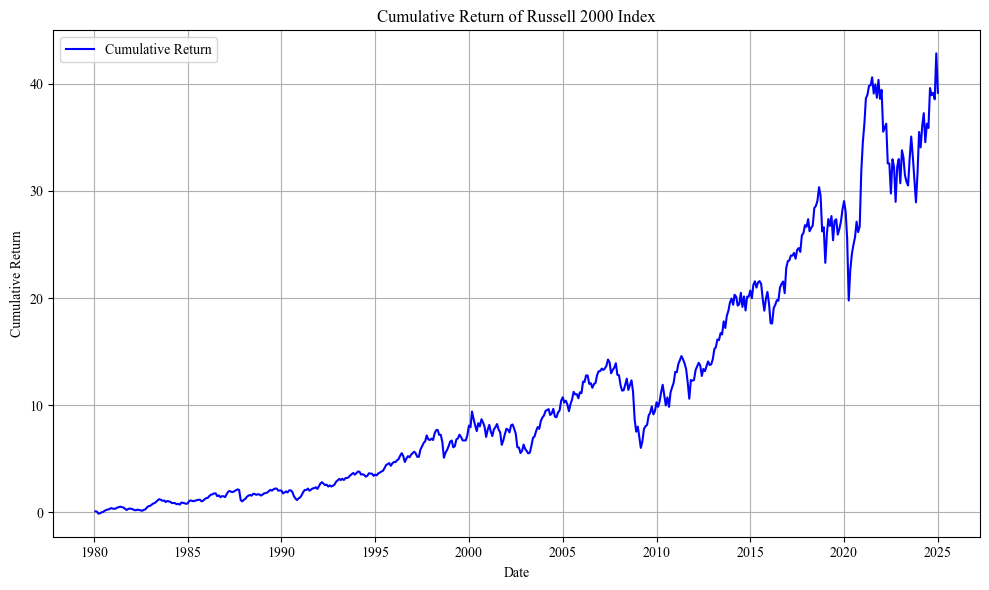

In [51]:
# Plotting the cumulative returns
plt.figure(figsize=(10, 6))
plt.plot(russell2000_data.index, russell2000_data['Cumulative Return'], label='Cumulative Return', color='b')
plt.title('Cumulative Return of Russell 2000 Index')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [52]:

# Define the ticker symbol for NASDAQ and parameters
ticker = '.IXIC'  # NASDAQ Composite index
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve monthly (end-of-month) historical data
try:
    nasdaq_data = ek.get_timeseries(
        ticker,
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    
    # Calculate monthly returns as percentage change
    nasdaq_data['Monthly Return'] = np.log(nasdaq_data['CLOSE'] / nasdaq_data['CLOSE'].shift(1))

    nasdaq_data = nasdaq_data[['Monthly Return']]

    nasdaq_data.dropna(inplace=True)
    
    # Calculate cumulative returns
    nasdaq_data['Cumulative Return'] = np.exp(np.cumsum(nasdaq_data['Monthly Return'])) - 1
      
    
except Exception as e:
    print(f"An error occurred: {e}")
 
print(nasdaq_data)

.IXIC       Monthly Return  Cumulative Return
Date                                         
1980-04-30        0.066367           0.068618
1980-05-31         0.07206           0.148466
1980-06-30        0.047571           0.204420
1980-07-31        0.085188           0.311519
1980-08-31        0.054977           0.385641
...                    ...                ...
2024-08-31        0.006469         134.218504
2024-09-30        0.026492         137.848626
2024-10-31       -0.005182         137.130924
2024-11-30        0.060212         145.703557
2024-12-31        0.004808         146.410626

[537 rows x 2 columns]


c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [53]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
nasdaq_data = nasdaq_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
nasdaq_data.index.name = 'Date'

nasdaq_data = nasdaq_data.dropna()

# Display the updated DataFrame
print(nasdaq_data)

.IXIC       Monthly Return  Cumulative Return
Date                                         
1980-04-30        0.066367           0.068618
1980-05-31         0.07206           0.148466
1980-06-30        0.047571           0.204420
1980-07-31        0.085188           0.311519
1980-08-31        0.054977           0.385641
...                    ...                ...
2024-08-31        0.006469         134.218504
2024-09-30        0.026492         137.848626
2024-10-31       -0.005182         137.130924
2024-11-30        0.060212         145.703557
2024-12-31        0.004808         146.410626

[537 rows x 2 columns]


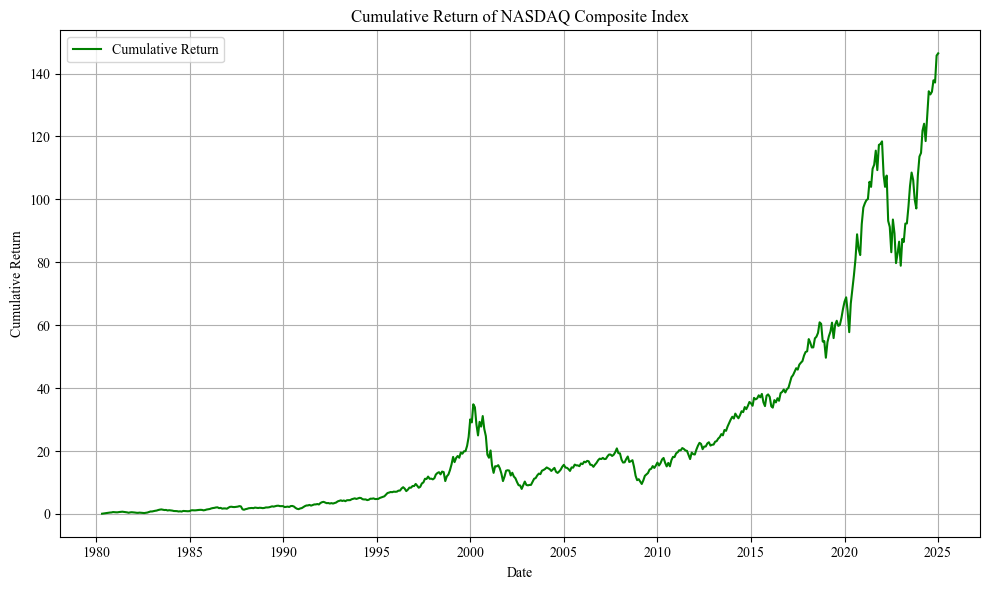

In [54]:
# Plotting the cumulative returns for NASDAQ
plt.figure(figsize=(10, 6))
plt.plot(nasdaq_data.index, nasdaq_data['Cumulative Return'], label='Cumulative Return', color='g')
plt.title('Cumulative Return of NASDAQ Composite Index')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [55]:
# Define the ticker symbol for the FTSE 100 index and parameters
ticker = '.FTSE'  # FTSE 1000 index symbol
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve monthly (end-of-month) historical data
try:
    FTSE_data = ek.get_timeseries(
        ticker,
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    print(FTSE_data.head())  # Print the first few rows of the data

except Exception as e:
    print(f"An error occurred: {e}")

.FTSE         HIGH   CLOSE     LOW  OPEN  VOLUME
Date                                            
1984-01-31  1082.0  1063.0   993.3  <NA>    <NA>
1984-02-29  1062.6  1040.3  1010.0  <NA>    <NA>
1984-03-31  1131.3  1112.5  1042.1  <NA>    <NA>
1984-04-30  1138.3  1138.3  1090.0  <NA>    <NA>
1984-05-31  1142.8  1021.0  1008.2  <NA>    <NA>


c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [56]:

# Calculate returns)
FTSE_data['Monthly Return'] = np.log(FTSE_data['CLOSE'] / FTSE_data['CLOSE'].shift(1))

# Keep only the Monthly Return column
FTSE_data = FTSE_data[['Monthly Return']]

# Drop rows with NaN values
FTSE_data.dropna(inplace=True)

# Calculate cumulative return (compounded)
FTSE_data['Cumulative Return'] = (1 + FTSE_data['Monthly Return']).cumprod() - 1

print(FTSE_data)

.FTSE       Monthly Return  Cumulative Return
Date                                         
1984-02-29       -0.021586          -0.021586
1984-03-31        0.067101           0.044066
1984-04-30        0.022926           0.068003
1984-05-31       -0.108753          -0.048146
1984-06-30        0.019783          -0.029315
...                    ...                ...
2024-08-31        0.001033           3.886297
2024-09-30       -0.016816           3.804131
2024-10-31        -0.01552           3.729571
2024-11-30        0.021614           3.831796
2024-12-31       -0.013886           3.764703

[491 rows x 2 columns]


In [57]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
FTSE_data = FTSE_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
FTSE_data.index.name = 'Date'

FTSE_data = FTSE_data.dropna()

# Display the updated DataFrame
print(FTSE_data)

.FTSE       Monthly Return  Cumulative Return
Date                                         
1984-02-29       -0.021586          -0.021586
1984-03-31        0.067101           0.044066
1984-04-30        0.022926           0.068003
1984-05-31       -0.108753          -0.048146
1984-06-30        0.019783          -0.029315
...                    ...                ...
2024-08-31        0.001033           3.886297
2024-09-30       -0.016816           3.804131
2024-10-31        -0.01552           3.729571
2024-11-30        0.021614           3.831796
2024-12-31       -0.013886           3.764703

[491 rows x 2 columns]


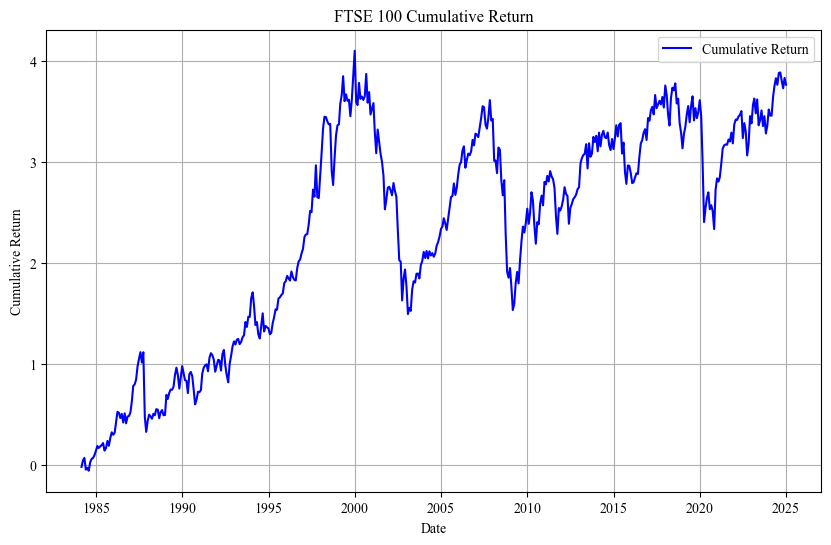

In [58]:
# Plot the cumulative return
plt.figure(figsize=(10, 6))
plt.plot(FTSE_data.index, FTSE_data['Cumulative Return'], label='Cumulative Return', color='blue')
plt.title('FTSE 100 Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [59]:
# Define the ticker symbol for DAX 40 index and parameters
ticker = '.GDAXI'  # DAX 40 index symbol (often used in financial data services)
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve monthly (end-of-month) historical data
try:
    dax_data = ek.get_timeseries(
        ticker,
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    print("Data successfully retrieved")
    
    # Display first few rows of the data
    print(dax_data.head())
    
except Exception as e:
    print(f"An error occurred: {e}")

Data successfully retrieved
.GDAXI      HIGH    CLOSE   LOW  OPEN  VOLUME
Date                                         
1987-12-31  <NA>  1005.19  <NA>  <NA>    <NA>
1988-01-31  <NA>    936.0  <NA>  <NA>    <NA>
1988-02-29  <NA>  1083.34  <NA>  <NA>    <NA>
1988-03-31  <NA>  1062.33  <NA>  <NA>    <NA>
1988-04-30  <NA>  1049.17  <NA>  <NA>    <NA>


c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [60]:
# Calculate Cumulative Returns
dax_data['Price'] = dax_data['CLOSE']  # Assuming 'CLOSE' is the column with closing prices

# Calculate percentage change (returns)
dax_data['Monthly Return'] = np.log(dax_data['Price'] / dax_data['Price'].shift(1))

# Keep only the Monthly Return column   
dax_data = dax_data[['Monthly Return']]

# Drop rows with NaN values 
dax_data.dropna(inplace=True)

# Calculate cumulative return (compounded)
dax_data['Cumulative Return'] = np.exp(np.cumsum(dax_data['Monthly Return'])) - 1

print(dax_data)

.GDAXI      Monthly Return  Cumulative Return
Date                                         
1988-01-31       -0.071316          -0.068833
1988-02-29        0.146189           0.077746
1988-03-31       -0.019584           0.056845
1988-04-30       -0.012465           0.043753
1988-05-31        0.024935           0.070106
...                    ...                ...
2024-08-31         0.02129          17.809300
2024-09-30        0.021868          18.225151
2024-10-31       -0.012884          17.979039
2024-11-30        0.028366          18.525115
2024-12-31        0.014301          18.806345

[444 rows x 2 columns]


In [61]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
dax_data = dax_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
dax_data.index.name = 'Date'

dax_data = dax_data.dropna()

# Display the updated DataFrame
print(dax_data)

.GDAXI      Monthly Return  Cumulative Return
Date                                         
1988-01-31       -0.071316          -0.068833
1988-02-29        0.146189           0.077746
1988-03-31       -0.019584           0.056845
1988-04-30       -0.012465           0.043753
1988-05-31        0.024935           0.070106
...                    ...                ...
2024-08-31         0.02129          17.809300
2024-09-30        0.021868          18.225151
2024-10-31       -0.012884          17.979039
2024-11-30        0.028366          18.525115
2024-12-31        0.014301          18.806345

[444 rows x 2 columns]


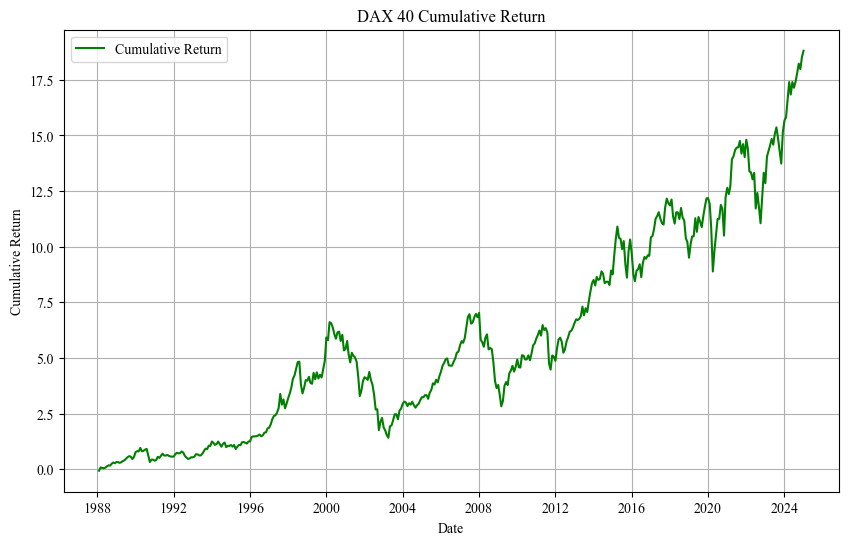

In [62]:
# Plot the cumulative return
plt.figure(figsize=(10, 6))
plt.plot(dax_data.index, dax_data['Cumulative Return'], label='Cumulative Return', color='green')
plt.title('DAX 40 Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [63]:
# Define the ticker symbol for the Euro Stoxx 50 index and parameters
ticker = '.STOXX50E'  # Euro Stoxx 50 index symbol in many financial data sources
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve monthly (end-of-month) historical data
try:
    stoxx_data = ek.get_timeseries(
        ticker,
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    print("Data successfully retrieved")
    
    # Display first few rows of the data
    print(stoxx_data.head())
    
except Exception as e:
    print(f"An error occurred: {e}")

Data successfully retrieved
.STOXX50E     HIGH   CLOSE     LOW    OPEN  VOLUME
Date                                              
1986-12-31  900.82  900.82  900.82  900.82    <NA>
1987-01-31  902.32  859.08   838.6  900.82    <NA>
1987-02-28  849.03  840.97  833.03  849.03    <NA>
1987-03-31  882.89  869.44  836.22   842.7    <NA>
1987-04-30  900.79  881.46  871.69  883.95    <NA>


c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1057: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():
c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\dtypes\cast.py:1081: RuntimeWarning: invalid value encountered in cast
  if (arr.astype(int) == arr).all():


In [64]:
# Calculate Cumulative Returns
stoxx_data['Price'] = stoxx_data['CLOSE']  # Assuming 'CLOSE' is the column with closing prices

# Calculate RETURNS
stoxx_data['Monthly Return'] = np.log(stoxx_data['Price'] / stoxx_data['Price'].shift(1))

# Keep only the Monthly Return column
stoxx_data = stoxx_data[['Monthly Return']]

# Drop rows with NaN values
stoxx_data.dropna(inplace=True)

# Calculate cumulative return (compounded)
stoxx_data['Cumulative Return'] = np.exp(np.cumsum(stoxx_data['Monthly Return'])) - 1

In [65]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
stoxx_data = stoxx_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
stoxx_data.index.name = 'Date'

stoxx_data = stoxx_data.dropna()

# Display the updated DataFrame
print(stoxx_data)

.STOXX50E   Monthly Return  Cumulative Return
Date                                         
1987-01-31       -0.047443          -0.046336
1987-02-28       -0.021306          -0.066439
1987-03-31        0.033293          -0.034835
1987-04-30         0.01373          -0.021492
1987-05-31       -0.017221          -0.038199
...                    ...                ...
2024-08-31        0.017301           4.503852
2024-09-30         0.00853           4.550998
2024-10-31       -0.035172           4.359151
2024-11-30       -0.004823           4.333363
2024-12-31        0.018882           4.435026

[456 rows x 2 columns]


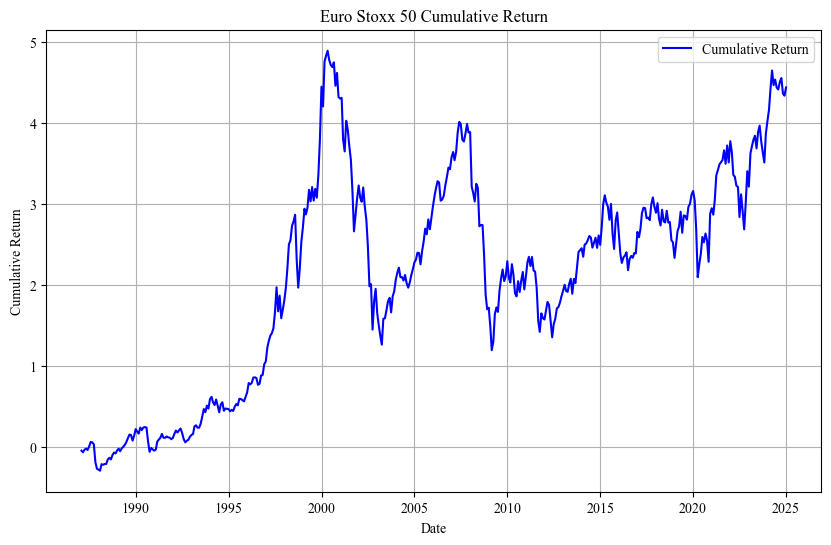

In [66]:
# Plot the cumulative return
plt.figure(figsize=(10, 6))
plt.plot(stoxx_data.index, stoxx_data['Cumulative Return'], label='Cumulative Return', color='blue')
plt.title('Euro Stoxx 50 Cumulative Return')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [67]:
# List available tables in the 'compd' library
tables = db.list_tables(library='comp')
print("Available tables in compd library:", tables)

Available tables in compd library: ['aco_amda', 'aco_imda', 'aco_indfnta', 'aco_indfntq', 'aco_indfntytd', 'aco_indsta', 'aco_indstq', 'aco_indstytd', 'aco_notesa', 'aco_notesq', 'aco_notessa', 'aco_notesytd', 'aco_pnfnda', 'aco_pnfndq', 'aco_pnfndytd', 'aco_pnfnta', 'aco_pnfntq', 'aco_pnfntytd', 'aco_transa', 'aco_transq', 'aco_transsa', 'aco_transytd', 'adsprate', 'asec_amda', 'asec_imda', 'asec_notesa', 'asec_notesq', 'asec_transa', 'asec_transq', 'bank_aacctchg', 'bank_adesind', 'bank_afnd1', 'bank_afnd2', 'bank_afnddc1', 'bank_afnddc2', 'bank_afntind', 'bank_funda', 'bank_funda_fncd', 'bank_fundq', 'bank_fundq_fncd', 'bank_iacctchg', 'bank_idesind', 'bank_ifndq', 'bank_ifndytd', 'bank_ifntq', 'bank_ifntytd', 'bank_names', 'bank_namesq', 'chars', 'co_aacctchg', 'co_aaudit', 'co_acthist', 'co_adesind', 'co_adjfact', 'co_afnd1', 'co_afnd2', 'co_afnddc1', 'co_afnddc2', 'co_afntind1', 'co_afntind2', 'co_ainvval', 'co_amkt', 'co_busdescl', 'co_cotype', 'co_filedate', 'co_fortune', 'co_h

In [68]:

# Define the query to get data for the Nikkei 225 index from Compustat
query = """
    SELECT
        id_table.tic,
        comp_global_daily.g_idx_mth.datadate AS date,
        id_table.gvkeyx,
        comp_global_daily.g_idx_mth.prccm AS price
    FROM comp_global_daily.g_idx_mth
    INNER JOIN (
        SELECT
            tic,
            gvkeyx
        FROM comp_global_daily.g_names_ix
        WHERE comp_global_daily.g_names_ix.tic IN (
            'I2JPN006'
        )
    ) AS id_table 
    ON comp_global_daily.g_idx_mth.gvkeyx = id_table.gvkeyx
    WHERE comp_global_daily.g_idx_mth.datadate BETWEEN
        '1985-12-01'::date AND '2024-12-31'::date
"""
nikkei_data = db.raw_sql(query)

# Check if the DataFrame is empty
if nikkei_data.empty:
    print("No data found for the specified query.")
else:
    # Convert `date` to datetime format for easier handling in pandas
    nikkei_data['date'] = pd.to_datetime(nikkei_data['date'])
    nikkei_data.set_index('date', inplace=True)

    # Drop rows with missing values
    nikkei_data_cleaned = nikkei_data.dropna()

    # Display the cleaned data
    print("Nikkei 225 Monthly Data from Compustat:")
    print(nikkei_data_cleaned.head())

Nikkei 225 Monthly Data from Compustat:
                 tic  gvkeyx     price
date                                  
1985-12-31  I2JPN006  150069  13083.18
1986-01-31  I2JPN006  150069  13024.30
1986-02-28  I2JPN006  150069  13640.83
1986-03-31  I2JPN006  150069  15859.69
1986-04-30  I2JPN006  150069  15825.50


In [69]:
# Calculate monthly returns
nikkei_data['Monthly Return'] = np.log(nikkei_data['price'] / nikkei_data['price'].shift(1))

#keep only the Monthly Return column
nikkei_data = nikkei_data[['Monthly Return']]

# Drop rows with NaN values
nikkei_data.dropna(inplace=True)

# Calculate cumulative returns
nikkei_data['Cumulative Return'] = np.exp(np.cumsum(nikkei_data['Monthly Return'])) - 1

# Drop rows with missing values in 'Monthly Return'
nikkei_data.dropna(subset=['Monthly Return'], inplace=True)

# Display the data with cumulative return
print(nikkei_data[[ 'Monthly Return', 'Cumulative Return']].head())

            Monthly Return  Cumulative Return
date                                         
1986-01-31       -0.004511          -0.004500
1986-02-28        0.046251           0.042623
1986-03-31        0.150713           0.212220
1986-04-30       -0.002158           0.209607
1986-05-31        0.052034           0.274214


In [70]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
nikkei_data = nikkei_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
nikkei_data.index.name = 'Date'

# Display the updated DataFrame
print(nikkei_data)

            Monthly Return  Cumulative Return
Date                                         
1986-01-31       -0.004511          -0.004500
1986-02-28        0.046251           0.042623
1986-03-31        0.150713           0.212220
1986-04-30       -0.002158           0.209607
1986-05-31        0.052034           0.274214
...                    ...                ...
2024-08-31       -0.011680           1.954003
2024-09-30       -0.019022           1.898344
2024-10-31        0.030176           1.987137
2024-11-30       -0.022597           1.920393
2024-12-31        0.043194           2.049300

[468 rows x 2 columns]


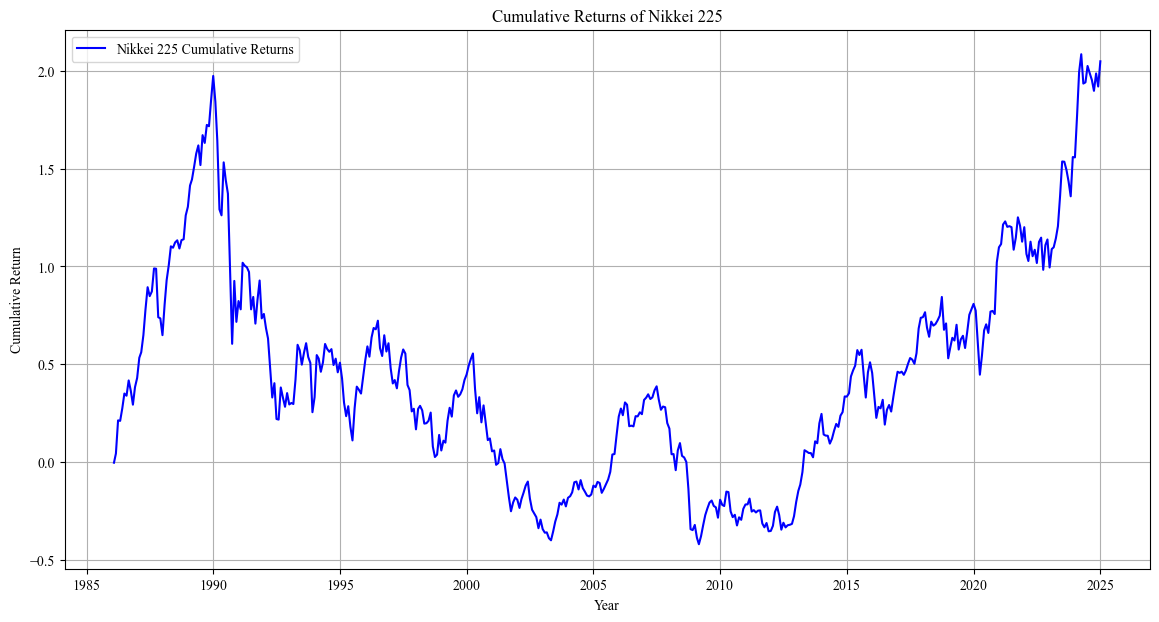

In [71]:
# Plot cumulative returns
plt.figure(figsize=(14, 7))
plt.plot(nikkei_data.index, nikkei_data['Cumulative Return'], label='Nikkei 225 Cumulative Returns', color='b')
plt.title('Cumulative Returns of Nikkei 225')
plt.xlabel('Year')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [72]:
# File path
file_path = "MonthlyHistoricalReturns_NAREIT.xls"

# Read the Excel file
nareit_data = pd.read_excel(file_path, sheet_name="Index Data")

# Rename columns if necessary
nareit_data.rename(columns={'Index': 'Level'}, inplace=True)

nareit_data['Monthly Return'] = np.log(nareit_data['Level'] / nareit_data['Level'].shift(1))

# Convert Date column to datetime format
nareit_data['Date'] = pd.to_datetime(nareit_data['Date'], format='%d/%m/%Y')

# Filter and sort data
nareit_data = nareit_data[['Date', 'Monthly Return']]
nareit_data.sort_values(by='Date', inplace=True)

# Set Date column as the index
nareit_data.set_index('Date', inplace=True)

# Define the date range
start_date = '1980-01-31'
end_date = '2024-12-31'

# Filter the data for the specified date range
nareit_data = nareit_data.loc[start_date:end_date]

# Drop missing values
nareit_data.dropna(inplace=True)

# Calculate cumulative returns
nareit_data['Cumulative Return'] = np.exp(np.cumsum(nareit_data['Monthly Return'])) - 1

# Display the processed data
print(nareit_data.head())

            Monthly Return  Cumulative Return
Date                                         
1980-01-31        0.066574           0.068840
1980-02-29       -0.011724           0.056382
1980-03-31       -0.142868          -0.084256
1980-04-30        0.081311          -0.006685
1980-05-31        0.073786           0.069379


Text(0.5, 0, 'Year')

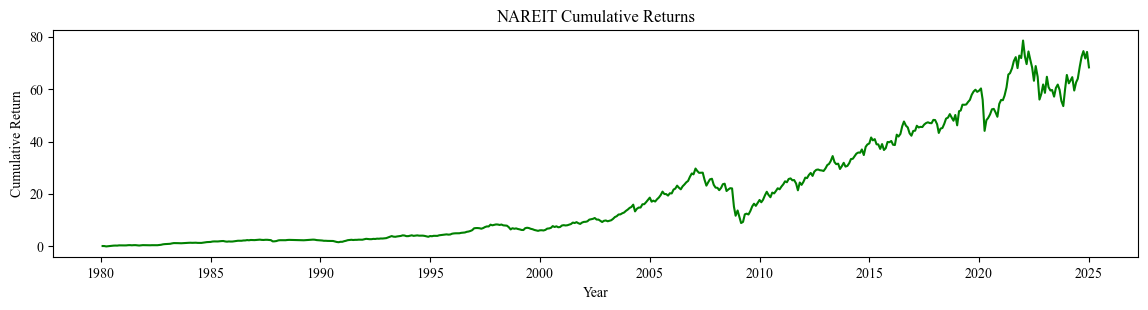

In [73]:
plt.figure(figsize=(14, 10))

# Plot the cumulative returns
plt.subplot(3, 1, 3)
plt.plot(nareit_data.index, nareit_data['Cumulative Return'], color='green')
plt.title('NAREIT Cumulative Returns')
plt.ylabel('Cumulative Return')
plt.xlabel('Year')

In [74]:
# Define the ticker symbol for Realty Income Corp and parameters
ticker = 'O'
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve monthly (end-of-month) historical data
try:
    realty_income_data = ek.get_timeseries(
        ticker,
        fields='CLOSE',
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    print("Data successfully retrieved")
    
    # Display first few rows of the data
    print(realty_income_data.head())
    
except Exception as e:
    print(f"An error occurred: {e}")

Data successfully retrieved
O              CLOSE
Date                
1994-10-31  8.049667
1994-11-30  7.747048
1994-12-31  8.291762
1995-01-31  8.594381
1995-02-28   9.19962


In [75]:
# Define the ticker symbol for Simon Property Group and parameters
ticker = 'SPG'
start_date = '1979-12-01'
end_date = '2024-12-31'

# Retrieve monthly (end-of-month) historical data
try:
    spg_data = ek.get_timeseries(
        ticker,
        fields='CLOSE',
        start_date=start_date,
        end_date=end_date,
        interval='monthly'
    )
    print("Data successfully retrieved")
    
    # Display first few rows of the data
    print(spg_data.head())
    
except Exception as e:
    print(f"An error occurred: {e}")



Data successfully retrieved
SPG             CLOSE
Date                 
1993-12-31  20.312647
1994-01-31  21.996016
1994-02-28  23.118261
1994-03-31  23.006037
1994-04-30  24.016058


In [76]:
# Compute monthly returns
spg_data['Monthly Return'] = spg_data['CLOSE'].pct_change()
realty_income_data['Monthly Return'] = realty_income_data['CLOSE'].pct_change()

# Compute cumulative returns
spg_data['Cumulative Return'] = (1 + spg_data['Monthly Return']).cumprod() - 1
realty_income_data['Cumulative Return'] = (1 + realty_income_data['Monthly Return']).cumprod() - 1

spg_data.head()



SPG             CLOSE  Monthly Return  Cumulative Return
Date                                                    
1993-12-31  20.312647            <NA>               <NA>
1994-01-31  21.996016        0.082873           0.082873
1994-02-28  23.118261         0.05102           0.138122
1994-03-31  23.006037       -0.004854           0.132597
1994-04-30  24.016058        0.043902            0.18232

In [77]:
realty_income_data.head()

O              CLOSE  Monthly Return  Cumulative Return
Date                                                   
1994-10-31  8.049667            <NA>               <NA>
1994-11-30  7.747048       -0.037594          -0.037594
1994-12-31  8.291762        0.070313           0.030075
1995-01-31  8.594381        0.036496           0.067669
1995-02-28   9.19962        0.070423           0.142857

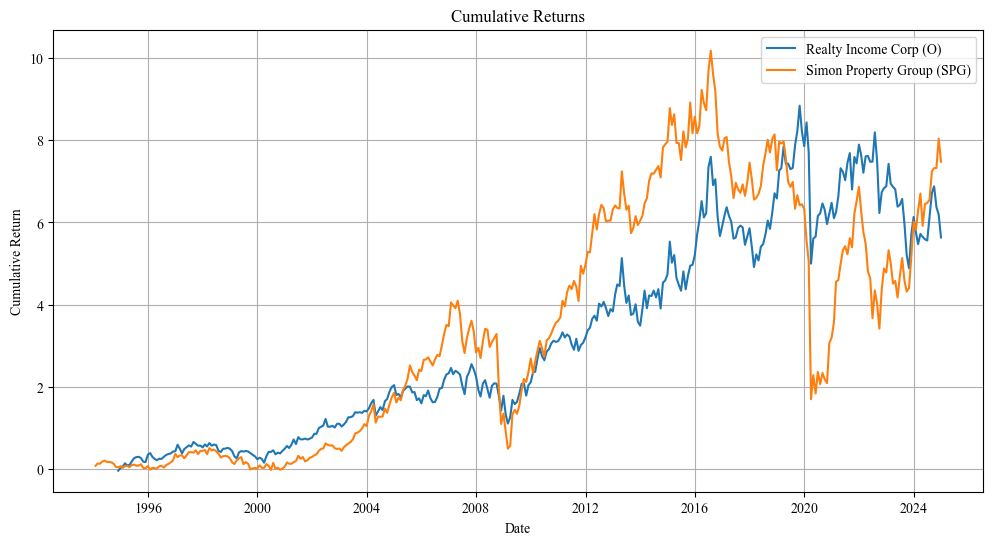

In [78]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(realty_income_data.index, realty_income_data['Cumulative Return'], label='Realty Income Corp (O)')
plt.plot(spg_data.index, spg_data['Cumulative Return'], label='Simon Property Group (SPG)')
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

In [79]:
ticker = 'XAU='  

# Retrieve historical data for gold prices from 1945 to present
gold_data = ek.get_timeseries(ticker, start_date='1979-12-01', end_date='2024-12-31', interval='monthly')

# Ensure data is sorted by date
gold_data.sort_index(inplace=True)

# Calculate Monthly Returns
gold_data['Monthly Return'] = np.log(gold_data['CLOSE'] / gold_data['CLOSE'].shift(1))

# Keep only the Monthly Return column
gold_data = gold_data[['Monthly Return']]

# Drop rows with NaN values
gold_data.dropna(inplace=True)

# Calculate Cumulative Returns
gold_data['Cumulative Return'] = np.exp(np.cumsum(gold_data['Monthly Return'])) - 1
gold_data.head()

XAU=        Monthly Return  Cumulative Return
Date                                         
1980-01-31        0.243253           0.275391
1980-02-29       -0.024807           0.244141
1980-03-31       -0.252212          -0.033203
1980-04-30        0.045417           0.011719
1980-05-31        0.033226           0.045898

In [80]:
# Filter to keep only the 'Monthly_Return' and 'Cumulative_Return' columns
gold_data = gold_data[['Monthly Return', 'Cumulative Return']]

# Ensure the 'Date' column is the index (if it's not already)
gold_data.index.name = 'Date'

# Display the updated DataFrame
print(gold_data)

XAU=        Monthly Return  Cumulative Return
Date                                         
1980-01-31        0.243253           0.275391
1980-02-29       -0.024807           0.244141
1980-03-31       -0.252212          -0.033203
1980-04-30        0.045417           0.011719
1980-05-31        0.033226           0.045898
...                    ...                ...
2024-08-31        0.022191           3.888735
2024-09-30        0.051188           4.145496
2024-10-31        0.040654           4.358994
2024-11-30       -0.033449           4.182707
2024-12-31       -0.011269           4.124633

[540 rows x 2 columns]


Text(0.5, 0, 'Year')

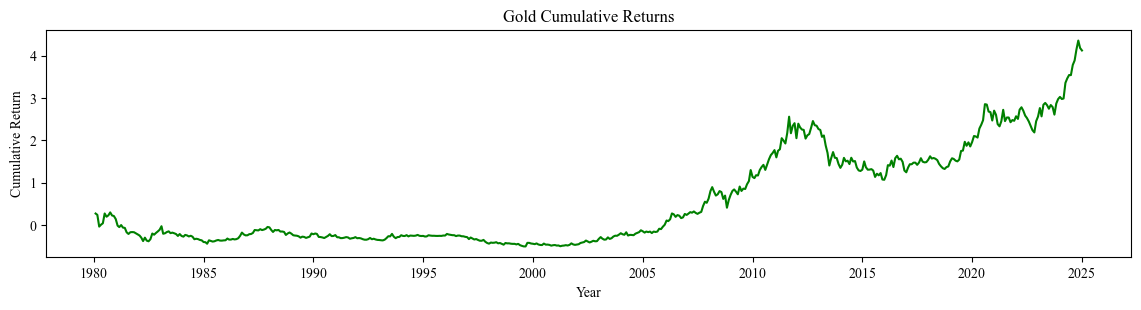

In [81]:
# Plotting the Gold Prices, Monthly Returns, and Cumulative Returns
plt.figure(figsize=(14, 10))


# Plot the cumulative returns
plt.subplot(3, 1, 3)
plt.plot(gold_data.index, gold_data['Cumulative Return'], color='green')
plt.title('Gold Cumulative Returns')
plt.ylabel('Cumulative Return')
plt.xlabel('Year')

In [82]:
# Define the instrument (West Texas Intermediate Oil)
ticker = 'CLc1'  # CLc1 is the RIC for WTI Crude Oil in USD per barrel

# Retrieve historical data for oil prices from 1945 to present
oil_data = ek.get_timeseries(ticker, start_date='1945-01-01', end_date='2024-12-31', interval='monthly')

# Ensure data is sorted by date
oil_data.sort_index(inplace=True)

# Calculate Monthly Returns
oil_data['Monthly Return'] = np.log(oil_data['CLOSE'] / oil_data['CLOSE'].shift(1))

# Keep only the Monthly Return column
oil_data = oil_data[['Monthly Return']]

# Drop rows with NaN values
oil_data.dropna(inplace=True)

# Calculate Cumulative Returns
oil_data['Cumulative Return'] = (1 + oil_data['Monthly Return']).cumprod() - 1

# Display the first few rows of the data
oil_data.head()

CLc1        Monthly Return  Cumulative Return
Date                                         
1983-04-30        0.045417           0.045417
1983-05-31       -0.012484           0.032366
1983-06-30        0.036675           0.070228
1983-07-31        0.019565           0.091167
1983-08-31       -0.012895           0.077096

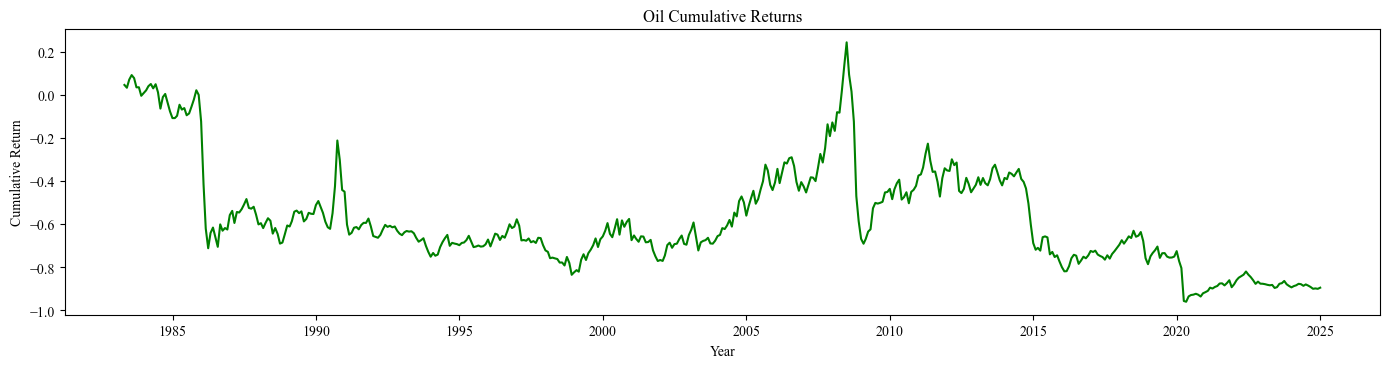

In [83]:
#Plotting the Oil Prices, Monthly Returns, and Cumulative Returns
plt.figure(figsize=(14, 10))


# Plot the cumulative returns
plt.subplot(3, 1, 3)
plt.plot(oil_data.index, oil_data['Cumulative Return'], color='green')
plt.title('Oil Cumulative Returns')
plt.ylabel('Cumulative Return')
plt.xlabel('Year')

plt.tight_layout()
plt.show()

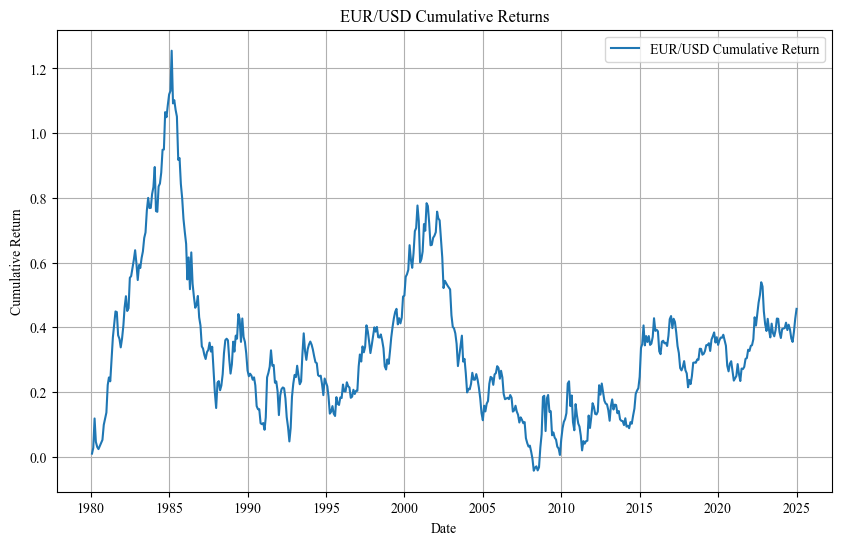

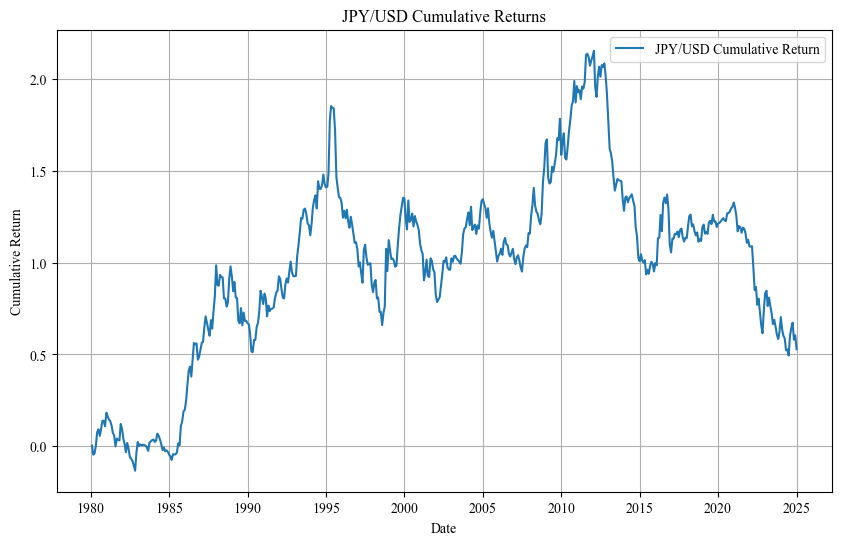

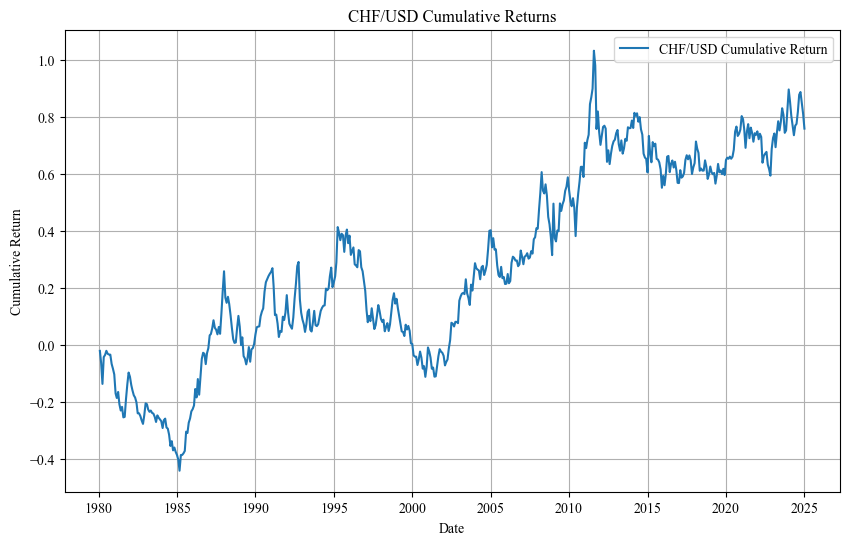

In [84]:
# Define the tickers for FX pairs (inverted for investment perspective)
tickers = {
    'EUR/USD': 'EUR=',
    'JPY/USD': 'JPY=',
    'CHF/USD': 'CHF='
}

# Set the date range
start_date = '1979-12-31'
end_date = '2024-12-31'

# Loop through each FX pair, retrieve the data, and calculate returns
for name, ticker in tickers.items():
    # Retrieve FX rate data from Refinitiv
    data = ek.get_timeseries(
        ticker, 
        start_date=start_date, 
        end_date=end_date, 
        interval='monthly'
    )
    data.sort_index(inplace=True)

    # Ensure the data is a DataFrame and invert the FX rate
    data = pd.DataFrame(data)
    data['Inverted Rate'] = 1 / data['CLOSE']  # Invert the FX rate

    # Calculate monthly and cumulative returns based on the inverted rate
    data['Monthly Return'] = np.log(data['Inverted Rate'] / data['Inverted Rate'].shift(1))

    # Keep only the Date index and the relevant columns
    data = data[['Monthly Return']]

    data.dropna(inplace=True)  # Drop NaN values

    data['Cumulative Return'] = np.exp(np.cumsum(data['Monthly Return'])) - 1

    # Keep only the Date index and the relevant columns
    data = data[['Monthly Return', 'Cumulative Return']]
    
    # Assign the final DataFrame to a dynamically created variable
    globals()[f"{name.replace('/', '_')}_data"] = data

    # Plot the cumulative returns
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Cumulative Return'], label=f'{name} Cumulative Return')
    plt.title(f'{name} Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid()
    plt.show()

In [85]:
# Define the instrument
ticker = 'TIP'  

tip_etf_data = ek.get_timeseries(ticker, start_date='1979-12-31', end_date='2024-12-31', interval='monthly')

# Ensure data is sorted by date
tip_etf_data.sort_index(inplace=True)

# Calculate Monthly Returns
tip_etf_data['Monthly Return'] = np.log(tip_etf_data['CLOSE'] / tip_etf_data['CLOSE'].shift(1))

# Keep only the Monthly Return column
tip_etf_data = tip_etf_data[['Monthly Return']]

# Drop rows with NaN values
tip_etf_data.dropna(inplace=True)

# Calculate Cumulative Returns
tip_etf_data['Cumulative Return'] = (1 + tip_etf_data['Monthly Return']).cumprod() - 1

# Display the first few rows of the data
tip_etf_data.head()

TIP         Monthly Return  Cumulative Return
Date                                         
2004-01-31        0.012118           0.012118
2004-02-29         0.02124           0.033615
2004-03-31        0.016504           0.050674
2004-04-30       -0.054296          -0.006373
2004-05-31        0.014607           0.008141

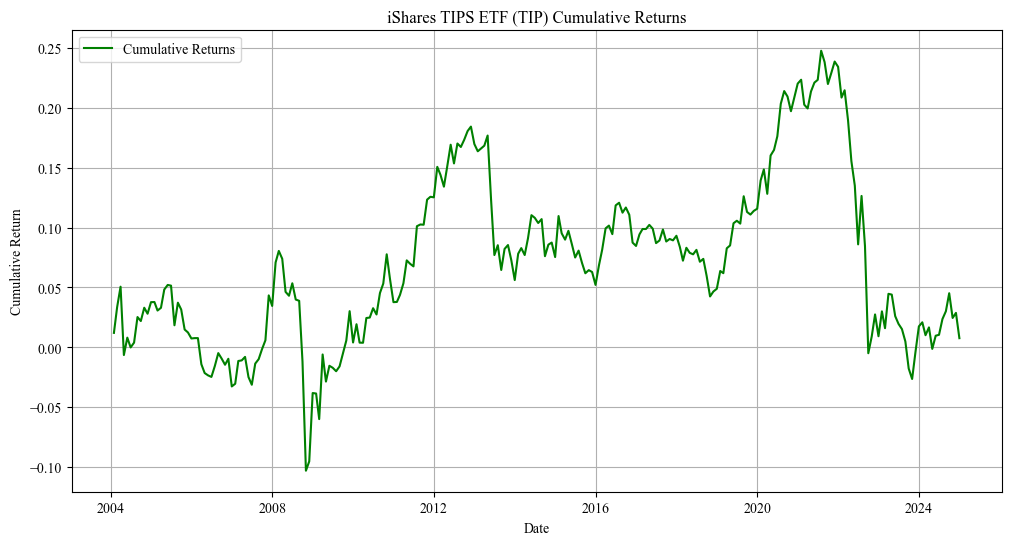

In [86]:
# Plot Cumulative Returns
plt.figure(figsize=(12, 6))
plt.plot(tip_etf_data.index, tip_etf_data['Cumulative Return'], label='Cumulative Returns', color='green')
plt.title('iShares TIPS ETF (TIP) Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid()
plt.show()

C:\Users\geral\AppData\Local\Temp\ipykernel_32220\3059879101.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mcti_data_cleaned['Cumulative Return'] = np.exp(np.cumsum(mcti_data_cleaned['Monthly Return'])) - 1


10-Year Treasury Bond Monthly Returns with Cumulative Returns:
               level  Monthly Return  Cumulative Return
date                                                   
1980-01-31  133.1511       -0.038197          -0.037477
1980-02-29  126.4261       -0.051827          -0.086091
1980-03-31  132.5381        0.047212          -0.041908
1980-04-30  143.7210        0.081004           0.038931
1980-05-30  149.2517        0.037760           0.078911


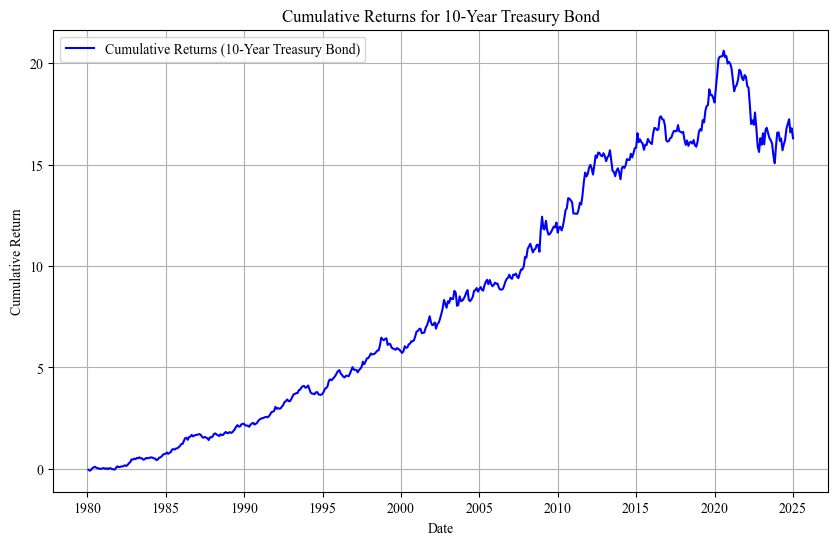

In [87]:

# Define the query to fetch data from the `mcti` table
query = """
    SELECT caldt AS date, b10ind AS level
    FROM crsp_a_indexes.mcti
    WHERE caldt BETWEEN '1979-12-31' AND '2024-12-31'
"""

# Execute the query and fetch the data
mcti_data = db.raw_sql(query)

# Check if the DataFrame is empty
if mcti_data.empty:
    print("No data found for the specified query.")
else:
    # Convert `date` to datetime format for easier handling in pandas
    mcti_data['date'] = pd.to_datetime(mcti_data['date'])
    mcti_data.set_index('date', inplace=True)

    mcti_data['Monthly Return'] = np.log(mcti_data['level'] / mcti_data['level'].shift(1))

    # Drop rows with missing values
    mcti_data_cleaned = mcti_data.dropna()

    # Calculate Cumulative Returns
    mcti_data_cleaned['Cumulative Return'] = np.exp(np.cumsum(mcti_data_cleaned['Monthly Return'])) - 1

    # Display the first few rows of the data
    print("10-Year Treasury Bond Monthly Returns with Cumulative Returns:")
    print(mcti_data_cleaned.head())

    # Rename the DataFrame to gs10_data
    gs10_data = mcti_data_cleaned

    # Plot the cumulative returns
    plt.figure(figsize=(10, 6))
    plt.plot(gs10_data.index, gs10_data['Cumulative Return'], label='Cumulative Returns (10-Year Treasury Bond)', color='blue')
    plt.title('Cumulative Returns for 10-Year Treasury Bond')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()


In [88]:
gs10_data.head()

level  Monthly Return  Cumulative Return
date                                                   
1980-01-31  133.1511       -0.038197          -0.037477
1980-02-29  126.4261       -0.051827          -0.086091
1980-03-31  132.5381        0.047212          -0.041908
1980-04-30  143.7210        0.081004           0.038931
1980-05-30  149.2517        0.037760           0.078911

# Expected Inflation (10Year Breakeven OR Survey?) & Expected Volatility

Expected inflation as in 10 Year Breakeven - The breakeven inflation rate represents a measure of expected inflation derived from 10-Year Treasury Constant Maturity Securities (BC_10YEAR) and 10-Year Treasury Inflation-Indexed Constant Maturity Securities (TC_10YEAR). The latest value implies what market participants expect inflation to be in the next 10 years, on average.

In [89]:
# Download 10-Year Breakeven Inflation Rate data from FRED
breakeven_inflation_data = fred.get_series('T10YIE')
breakeven_inflation_df = pd.DataFrame(breakeven_inflation_data, columns=['Expected Inflation Rate'])
breakeven_inflation_df.index = pd.to_datetime(breakeven_inflation_df.index)

# Display head of the data
breakeven_inflation_df.head()

Expected Inflation Rate
2003-01-02                     1.64
2003-01-03                     1.62
2003-01-06                     1.63
2003-01-07                     1.62
2003-01-08                     1.71

University of Michigan Inflation Expectation: Median expected price change next 12 months, Surveys of Consumers.

In [90]:
# Set the date range
start_date = '1979-12-31'
end_date = '2024-12-31'

# Fetch University of Michigan Inflation Expectations (MICH) from FRED
umich_inflation = web.DataReader("MICH", "fred", start_date, end_date)

# Resample to end-of-month data
umich_inflation = umich_inflation.resample('M').last()

# Rename the column for clarity
umich_inflation.rename(columns={"MICH": "UMich Expected Inflation Rate"}, inplace=True)

# Drop any missing values
umich_inflation.dropna(inplace=True)

# Display the first few rows
print(umich_inflation.head())

            UMich Expected Inflation Rate
DATE                                     
1980-01-31                           10.4
1980-02-29                           10.0
1980-03-31                           10.2
1980-04-30                           10.1
1980-05-31                            8.6


C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2671680920.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  umich_inflation = umich_inflation.resample('M').last()


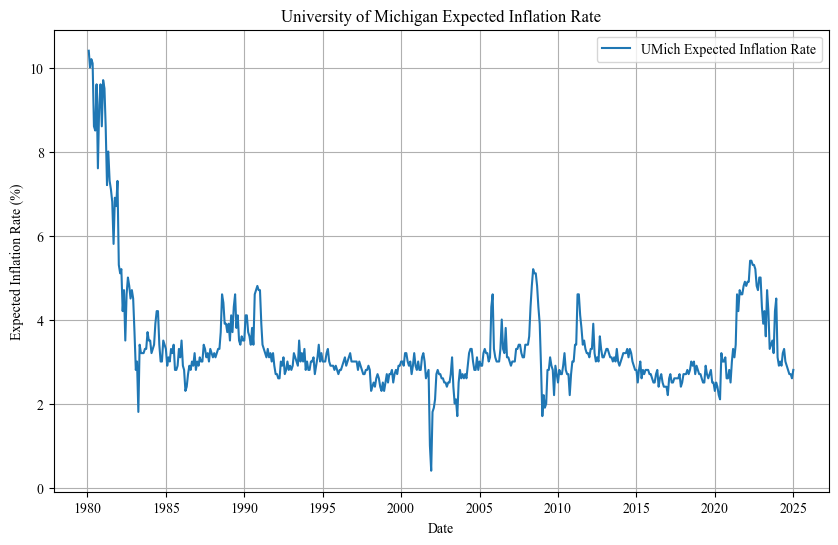

In [91]:
# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(umich_inflation.index, umich_inflation['UMich Expected Inflation Rate'], label='UMich Expected Inflation Rate')
plt.title('University of Michigan Expected Inflation Rate')
plt.xlabel('Date')
plt.ylabel('Expected Inflation Rate (%)')
plt.legend()
plt.grid(True)
plt.show()

C:\Users\geral\AppData\Local\Temp\ipykernel_32220\1833242750.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vix_data = vix_data.resample('M').last()


            VIX Index
DATE                 
1990-01-31      25.36
1990-02-28      21.99
1990-03-31      19.73
1990-04-30      19.52
1990-05-31      17.37


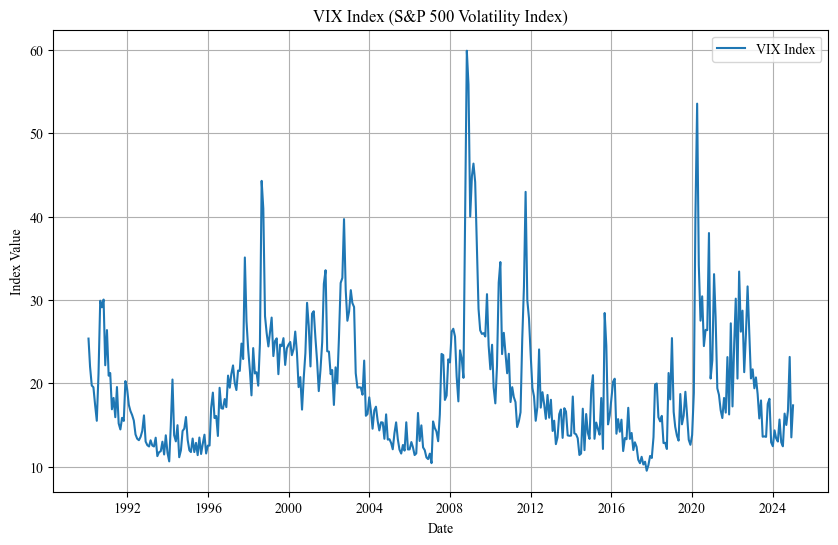

In [92]:
# Set the date range
start_date = '1979-12-31'
end_date = '2024-12-31'

# Fetch VIX data from FRED
vix_data = web.DataReader("VIXCLS", "fred", start_date, end_date)

# Resample to end-of-month data
vix_data = vix_data.resample('M').last()

# Rename the column for clarity
vix_data.rename(columns={"VIXCLS": "VIX Index"}, inplace=True)

# Drop any missing values
vix_data.dropna(inplace=True)

# Display the first few rows
print(vix_data.head())

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(vix_data.index, vix_data['VIX Index'], label='VIX Index')
plt.title('VIX Index (S&P 500 Volatility Index)')
plt.xlabel('Date')
plt.ylabel('Index Value')
plt.legend()
plt.grid(True)
plt.show()

VIX measures market expectation of near term volatility conveyed by stock index option prices

## Rule of 16

The Cboe® introduced the VIX in 1993 as a weighted measure of the implied volatility (IV)2 of S&P 100® index (OEX) options. The more actively traded S&P 500® index (SPX) options replaced OEX options in the calculation of the VIX in 2003. Since its inception, the VIX has evolved into the preeminent measure of investor fear and overall market volatility.

As investors monitor the VIX on a daily and weekly basis, they're simply watching a number that represents the IV of SPX options. Without getting into a long math discussion involving square roots, let's simplify an interesting aspect of the VIX, which is the number 16 (or more precisely, 15.87). It's the square root of 252 (the number of trading days in a year). Rounding 15.87 to 16 is where the rule of 16 gets its name.

Let's walk through some hypotheticals. According to the rule of 16, if the VIX is trading at 16, then the SPX is estimated to see average daily moves up or down of 1% (because 16/16 = 1). If the VIX is at 24, the daily moves might be around 1.5%, and at 32, the rule of 16 says the SPX might see 2% daily moves.

The options rule of 16 works the other way, too—you can "annualize" a daily reading by multiplying it by 16. For example, suppose a stock has had a few moves of 1.8%, and you think a 1.8% daily move might accurately capture the stock's inherent volatility. If so, you'd be expecting an annualized volatility level of 1.8 x 16 = 28.8%. Because volatility is an important variable of options pricing models, comparing your expectation for an underlying security's volatility to the current IV might indicate whether you believe an option is overpriced, underpriced, or fairly priced.

C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2370008060.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  vix_monthly = vix_daily['Implied Daily Volatility'].resample('M').last()


DATE
1990-01-31    7.263382
1990-02-28    6.298177
1990-03-31    5.650889
1990-04-30    5.590742
1990-05-31    4.974959
Freq: ME, Name: Implied Daily Volatility, dtype: float64


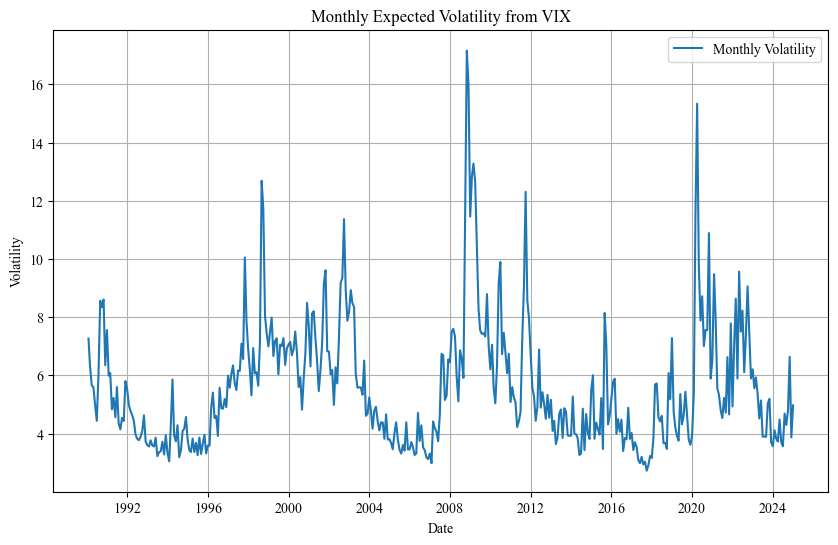

In [93]:
# Set the date range
start_date = '1979-12-31'
end_date = '2024-12-31'

# Fetch daily VIX data from FRED
vix_daily = web.DataReader("VIXCLS", "fred", start_date, end_date)

# Drop any missing values
vix_daily.dropna(inplace=True)

# Convert the VIX to implied daily volatility by dividing by 16
vix_daily['Implied Daily Volatility'] = vix_daily['VIXCLS'] / 16

# Resample to end-of-month data
vix_monthly = vix_daily['Implied Daily Volatility'].resample('M').last()

# Calculate the monthly volatility by scaling the daily volatility
# Monthly volatility = Daily volatility * sqrt(number of trading days in a month)
# Approximate number of trading days in a month = 21
vix_monthly = vix_monthly * (21 ** 0.5)

# Display the first few rows of the monthly volatility
print(vix_monthly.head())

# Plot the monthly volatility
plt.figure(figsize=(10, 6))
plt.plot(vix_monthly.index, vix_monthly, label='Monthly Volatility')
plt.title('Monthly Expected Volatility from VIX')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.show()

In [94]:
vix_monthly.head()

DATE
1990-01-31    7.263382
1990-02-28    6.298177
1990-03-31    5.650889
1990-04-30    5.590742
1990-05-31    4.974959
Freq: ME, Name: Implied Daily Volatility, dtype: float64

In [95]:
# Convert the Series to a DataFrame
vix_monthly_df = vix_monthly.to_frame()

# Rename the first column to "Monthly Expected Volatility"
vix_monthly_df.rename(columns={vix_monthly_df.columns[0]: "Monthly Expected Volatility"}, inplace=True)

# Display the first few rows to verify the change
print(vix_monthly_df.head())

            Monthly Expected Volatility
DATE                                   
1990-01-31                     7.263382
1990-02-28                     6.298177
1990-03-31                     5.650889
1990-04-30                     5.590742
1990-05-31                     4.974959


.MOVE         HIGH  MOVE Index    LOW   OPEN
Date                                        
2019-10-31   80.25       65.88  63.32  79.86
2019-11-30   69.82       56.57  56.57  57.28
2019-12-31   67.29       58.28  53.41  59.42
2020-01-31   72.98       72.98  49.67  58.28
2020-02-29  109.67      109.67  61.24  72.81


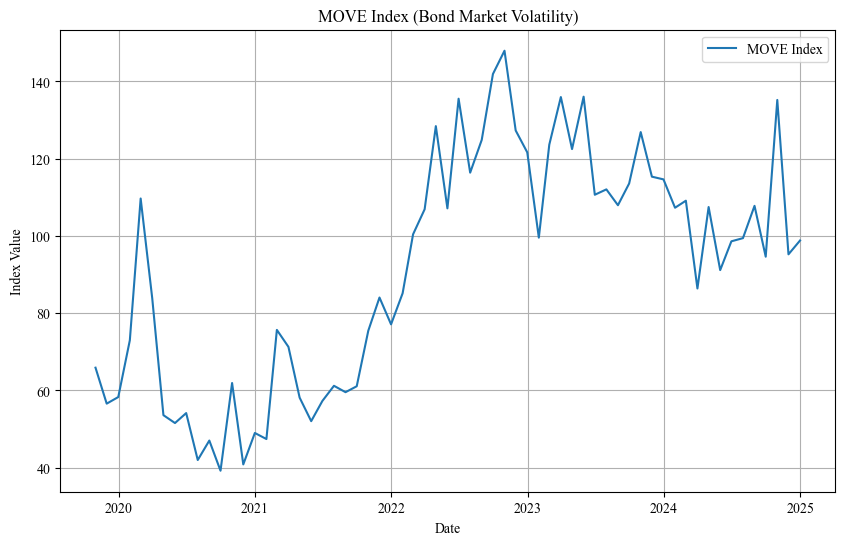

In [96]:
# Define the ticker symbol for the MOVE Index and parameters
ticker = '.MOVE'
start_date = '1979-12-31'
end_date = '2024-12-31'

# Retrieve MOVE Index data from Eikon
try:
    move_data = ek.get_timeseries(ticker, start_date=start_date, end_date=end_date, interval='monthly')
    
    # Rename the column for clarity
    move_data.rename(columns={"CLOSE": "MOVE Index"}, inplace=True)

    # Drop any missing values
    move_data.dropna(inplace=True)

    # Display the first few rows
    print(move_data.head())

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(move_data.index, move_data['MOVE Index'], label='MOVE Index')
    plt.title('MOVE Index (Bond Market Volatility)')
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.legend()
    plt.grid(True)
    plt.show()
except Exception as e:
    print(f"An error occurred: {e}")

# Summary Statistics

In [97]:
# List of dataframes and corresponding names for the datasets
data_frames = [
    sp500_df, russell2000_data, nasdaq_data, FTSE_data, dax_data, stoxx_data, nikkei_data,
    gold_data, oil_data, gs10_data, tip_etf_data, nareit_data, EUR_USD_data,
    JPY_USD_data, CHF_USD_data
]

dataset_names = [
    "S&P 500", "Russell 2000", "NASDAQ", "FTSE", "DAX", "STOXX", "Nikkei",
    "Gold", "Oil", "10 Year Treasury Note", "TIPS ETF", "Na REIT",
    "EUR/USD", "JPY/USD", "CHF/USD"
]

# Initialize an empty list to store summary statistics
summary_stats = []

# Iterate through each dataframe and corresponding name
for df, name in zip(data_frames, dataset_names):
    if 'Monthly Return' in df.columns:  # Check if 'Monthly Return' exists
        stats = df['Monthly Return'].describe()  # Generate summary statistics for Monthly Return
        annualized_return = (1 + stats['mean']) ** 12 - 1  # Calculate annualized return
        skewness = df['Monthly Return'].skew()  # Calculate skewness
        kurtosis = df['Monthly Return'].kurt()  # Calculate kurtosis

        summary_stats.append({
            "Dataset": name,
            "Count": stats['count'],
            "Mean (%)": stats['mean'] * 100,
            "Std Dev (%)": stats['std'] * 100,
            "Min (%)": stats['min'] * 100,
            "25% (%)": stats['25%'] * 100,
            "50% (Median) (%)": stats['50%'] * 100,
            "75% (%)": stats['75%'] * 100,
            "Max (%)": stats['max'] * 100,
            "Annualized Return (%)": annualized_return * 100,
            "Skewness": skewness,
            "Kurtosis": kurtosis
        })
    else:
        print(f"Warning: 'Monthly Return' column missing for {name}")

# Convert the summary statistics list to a DataFrame
summary_stats_df = pd.DataFrame(summary_stats)

# Format the DataFrame for better readability
summary_stats_df = summary_stats_df.round(2)

# Display the summary statistics table
print("\nSummary Statistics for Monthly Returns:")
print(summary_stats_df)

# Save the summary statistics to a CSV file
summary_stats_df.to_csv("monthly_return_summary_statistics.csv", index=False)

print("\nSummary statistics have been saved to 'monthly_return_summary_statistics.csv'.")


Summary Statistics for Monthly Returns:
                  Dataset  Count  Mean (%)  Std Dev (%)  Min (%)  25% (%)  \
0                 S&P 500  540.0      0.74         4.42   -24.54    -1.75   
1            Russell 2000  540.0      0.68         5.82   -36.77    -2.68   
2                  NASDAQ  537.0      0.93         6.11   -31.79    -2.19   
3                    FTSE  491.0      0.42         4.33   -30.17    -1.85   
4                     DAX  444.0      0.67         5.88   -29.33    -2.34   
5                   STOXX  456.0      0.37         5.27   -24.19    -2.45   
6                  Nikkei  468.0      0.24         5.87   -27.22    -2.88   
7                    Gold  540.0      0.30         4.91   -25.22    -2.46   
8                     Oil  501.0      0.18        10.40   -78.19    -5.48   
9   10 Year Treasury Note  540.0      0.53         2.31    -6.92    -0.81   
10               TIPS ETF  252.0      0.02         1.75    -9.23    -0.80   
11                Na REIT  540.0   

In [98]:
# Initialize an empty DataFrame to store cumulative returns
cumulative_returns_df = pd.DataFrame()

# Iterate over each DataFrame in data_frames
for df, name in zip(data_frames, dataset_names):
    if 'Cumulative Return' in df.columns:
        # Add the 'Cumulative Return' column to the cumulative_returns_df
        cumulative_returns_df[name] = df['Cumulative Return']

# Display the first few rows of the cumulative returns DataFrame
print(cumulative_returns_df.head())

             S&P 500  Russell 2000    NASDAQ  FTSE  DAX  STOXX  Nikkei  \
Date                                                                     
1980-01-31  0.057625      0.082133       NaN  <NA>  NaN    NaN     NaN   
1980-02-29  0.052992      0.059258       NaN  <NA>  NaN    NaN     NaN   
1980-03-31 -0.054197     -0.136707       NaN  <NA>  NaN    NaN     NaN   
1980-04-30 -0.015286     -0.084654  0.068618  <NA>  NaN    NaN     NaN   
1980-05-30  0.030573           NaN       NaN  <NA>  NaN    NaN     NaN   

                Gold   Oil  10 Year Treasury Note  TIPS ETF   Na REIT  \
Date                                                                    
1980-01-31  0.275391  <NA>              -0.037477      <NA>  0.068840   
1980-02-29  0.244141  <NA>              -0.086091      <NA>  0.056382   
1980-03-31 -0.033203  <NA>              -0.041908      <NA> -0.084256   
1980-04-30  0.011719  <NA>               0.038931      <NA> -0.006685   
1980-05-30       NaN  <NA>               0.

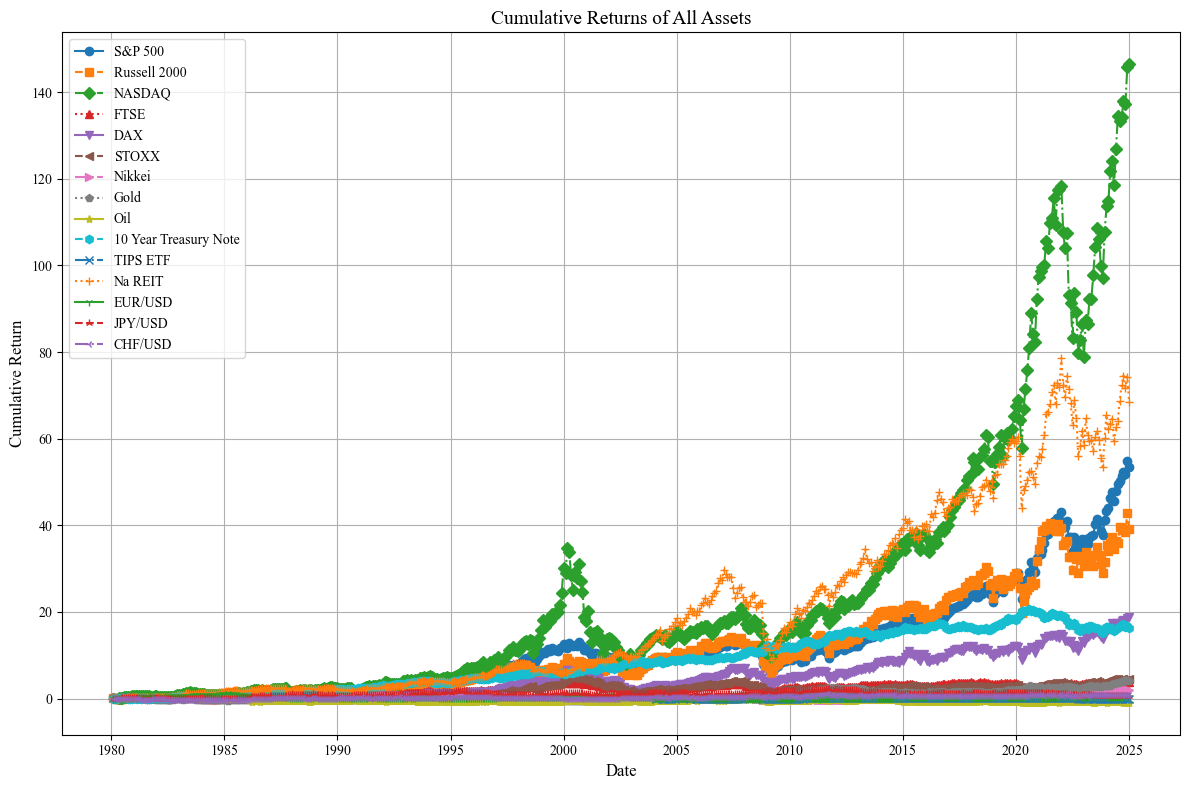

In [99]:

# List of cumulative return DataFrames and their corresponding labels
assets = {
    "S&P 500": sp500_df,
    "Russell 2000": russell2000_data,
    "NASDAQ": nasdaq_data,
    "FTSE": FTSE_data,
    "DAX": dax_data,
    "STOXX": stoxx_data,
    "Nikkei": nikkei_data,
    "Gold": gold_data,
    "Oil": oil_data,
    "10 Year Treasury Note": gs10_data,
    "TIPS ETF": tip_etf_data,
    "Na REIT": nareit_data,
    "EUR/USD": EUR_USD_data,
    "JPY/USD": JPY_USD_data,
    "CHF/USD": CHF_USD_data,
}

# Define line styles and markers for black-and-white visibility
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.', ':', '-', '--', '-.']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h', 'x', '+', '1', '2', '3']

# Plot cumulative returns
plt.figure(figsize=(12, 8))
for (label, df), style, marker in zip(assets.items(), line_styles, markers):
    if 'Cumulative Return' in df.columns:
        plt.plot(df.index, df['Cumulative Return'], linestyle=style, marker=marker, label=label)

# Add labels, title, and legend
plt.title("Cumulative Returns of All Assets", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Cumulative Return", fontsize=12)
plt.legend(loc="upper left", fontsize=10)
plt.grid(True)

# Save and show the plot
plt.tight_layout()
plt.savefig("cumulative_returns_black_and_white.png", dpi=300)
plt.show()

In [100]:
import pandas as pd

# List of dataframes
data_frames = [
    sp500_df, russell2000_data, nasdaq_data, FTSE_data, dax_data, stoxx_data, nikkei_data,
    gold_data, oil_data, gs10_data, tip_etf_data, nareit_data, EUR_USD_data , 
    JPY_USD_data, CHF_USD_data
]

dataset_names = [
    "S&P 500", "Russell 2000", "NASDAQ", "FTSE", "DAX", "STOXX", "Nikkei", 
    "Gold", "Oil", "10 Year Treasury Note", "TIPS ETF", "Na REIT",
    "EUR/USD", "JPY/USD", "CHF/USD"
]

# Initialize an empty dictionary to store the average annualized returns per 5-year interval for each dataset
average_annualized_returns_per_interval = {}

# Iterate through each dataframe and corresponding name
for df, name in zip(data_frames, dataset_names):
    # Ensure the index is in datetime format (if it's not already)
    df.index = pd.to_datetime(df.index)

    # Check if 'Monthly Return' column exists in the DataFrame
    if 'Monthly Return' in df.columns:
        # Create 5-year intervals starting from 1940
        start_year = 1980
        df['5-Year Interval'] = ((df.index.year - start_year) // 5) * 5 + start_year

        # Group by 5-year intervals and calculate the average monthly return per interval
        avg_monthly_return = df.groupby('5-Year Interval')['Monthly Return'].mean()

        # Annualize the average monthly return using the formula
        annualized_return = (1 + avg_monthly_return) ** 12 - 1

        # Convert to percentage
        annualized_return_percentage = annualized_return * 100

        # Store the result in the dictionary
        average_annualized_returns_per_interval[name] = annualized_return_percentage
    else:
        print(f"Warning: 'Monthly Return' column not found in {name} DataFrame.")

# Combine the results into a single DataFrame for display
annualized_interval_summary = pd.DataFrame(average_annualized_returns_per_interval)

# Transpose the DataFrame so that intervals are rows and datasets are columns
annualized_interval_summary_transposed = annualized_interval_summary.transpose()

# Format the values to show percentages with 2 decimal places
annualized_interval_summary_transposed = annualized_interval_summary_transposed.round(2)

# Display the resulting transposed table
print(annualized_interval_summary_transposed)

# Save the summary to a CSV file
annualized_interval_summary_transposed.to_csv("average_annualized_nominal_returns_5_year_intervals.csv")

print("\nAverage annualized nominal returns have been saved to 'average_annualized_nominal_returns_5_year_intervals.csv'.")

5-Year Interval             1980       1985       1990       1995       2000  \
S&P 500                  9.11726  16.033515   5.368489  25.903902  -3.783677   
Russell 2000           12.597666  10.753587   8.237405   14.96064   5.227657   
NASDAQ                  14.23316  12.885664  10.532267  39.520932 -11.830291   
FTSE                   17.358324  14.391907   4.809429  17.590335  -7.047511   
DAX                         <NA>  32.558502   3.354378  26.803324  -9.400154   
STOXX                       <NA>   6.817035   3.745648  29.639228  -9.699939   
Nikkei                       NaN  30.927075 -12.776673  -0.813179  -9.547012   
Gold                   -9.686346   5.480359  -1.024163   -5.56798   8.757509   
Oil                    -5.719783  -3.752196  -4.040739   7.563028   11.10883   
10 Year Treasury Note  11.812873  12.897173    7.82307   7.577671   7.760893   
TIPS ETF                    <NA>       <NA>       <NA>       <NA>   4.024314   
Na REIT                21.203804    4.26

C:\Users\geral\AppData\Local\Temp\ipykernel_32220\1672772414.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['5-Year Interval'] = ((df.index.year - start_year) // 5) * 5 + start_year


In [101]:
# List of dataframes and corresponding names for the variables
data_frames = [
    cpi_df[['Monthly Inflation Rate']],
    cpi_df[['YoY Inflation Rate']],
    msci_world[['Hist_Volatility']],
    msci_world[['GARCH_Volatility']]
]

dataset_names = [
    "Monthly Inflation Rate",
    "YoY Inflation Rate",
    "Historical Volatility",
    "GARCH Volatility"
]

# Initialize an empty dictionary to store the average statistics per 5-year interval for each dataset
average_stats_per_interval = {}

# Iterate through each dataframe and corresponding name
for df, name in zip(data_frames, dataset_names):
    # Ensure the index is in datetime format (if it's not already)
    df.index = pd.to_datetime(df.index)

    # Check if the dataframe is not empty
    if not df.empty:
        # Create 5-year intervals starting from 1980
        start_year = 1980
        df['5-Year Interval'] = ((df.index.year - start_year) // 5) * 5 + start_year

        # Group by 5-year intervals and calculate the average statistics per interval
        avg_stats = df.groupby('5-Year Interval').mean()

        # Store the result in the dictionary
        average_stats_per_interval[name] = avg_stats

# Combine the results into a single DataFrame for display
interval_summary = pd.concat(average_stats_per_interval, axis=1)

# Format the values to show percentages with 2 decimal places
interval_summary = interval_summary.round(2)

# Transpose the DataFrame
interval_summary_transposed = interval_summary.transpose()

# Display the resulting transposed table
print(interval_summary_transposed)

# Save the transposed summary to a CSV file
interval_summary_transposed.to_csv("macrovariables_5_year_intervals.csv")

print("\nSummary statistics have been saved to 'macrovariables_5_year_intervals.csv'.")

5-Year Interval                                 1980   1985   1990   1995  \
Monthly Inflation Rate Monthly Inflation Rate   0.53   0.30   0.29   0.20   
YoY Inflation Rate     YoY Inflation Rate       7.53   3.59   3.65   2.36   
Historical Volatility  Hist_Volatility         13.24  14.50  14.70  12.31   
GARCH Volatility       GARCH_Volatility        14.43  15.26  14.93  13.75   

5-Year Interval                                 2000   2005   2010   2015  \
Monthly Inflation Rate Monthly Inflation Rate   0.21   0.21   0.14   0.15   
YoY Inflation Rate     YoY Inflation Rate       2.55   2.60   1.99   1.55   
Historical Volatility  Hist_Volatility         15.12  13.96  14.52  10.80   
GARCH Volatility       GARCH_Volatility        15.72  15.67  14.79  13.20   

5-Year Interval                                 2020  
Monthly Inflation Rate Monthly Inflation Rate   0.34  
YoY Inflation Rate     YoY Inflation Rate       4.21  
Historical Volatility  Hist_Volatility         17.40  
GARCH Vo

C:\Users\geral\AppData\Local\Temp\ipykernel_32220\469167349.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['5-Year Interval'] = ((df.index.year - start_year) // 5) * 5 + start_year
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\469167349.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['5-Year Interval'] = ((df.index.year - start_year) // 5) * 5 + start_year
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\469167349.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of

In [102]:
msci_world.head()

.dMIWO00000PUS  Monthly Return  Cumulative Returns  Hist_Volatility  \
Date                                                                  
1980-01-31             0.05556            0.108193        12.654740   
1980-02-29           -0.002477            0.105452        12.288806   
1980-03-31           -0.117202           -0.016805        17.258290   
1980-04-30            0.060149            0.044148        18.362729   
1980-05-31             0.04486            0.092054        18.627168   

.dMIWO00000PUS  GARCH_Volatility  Historical Volatility  GARCH Volatility  
Date                                                                       
1980-01-31             14.164792                    NaN          0.044927  
1980-02-29             14.695518                    NaN          0.045169  
1980-03-31             13.772267                    NaN          0.042818  
1980-04-30             20.719724                    NaN          0.056627  
1980-05-31             19.899741                    NaN          0.055112

In [103]:

# List of dataframes and corresponding names for inflation and volatility datasets
data_frames = [
    cpi_df[['Monthly Inflation Rate']], 
    cpi_df[['YoY Inflation Rate']], 
    msci_world[['Hist_Volatility']], 
    msci_world[['GARCH_Volatility']]
]

dataset_names = [
    "Monthly Inflation Rate", 
    "YoY Inflation Rate", 
    "Historical Volatility", 
    "GARCH Volatility"
]

# Initialize an empty list to store summary statistics
summary_stats = []

# Iterate through each dataframe and corresponding name
for df, name in zip(data_frames, dataset_names):
    if not df.empty:  # Check if the dataframe is not empty
        stats = df.iloc[:, 0].describe()  # Generate summary statistics for the first column
        annualized_return = (1 + stats['mean'] / 100) ** 12 - 1  # Calculate annualized return (if applicable)
        skewness = df.iloc[:, 0].skew()  # Calculate skewness
        kurtosis = df.iloc[:, 0].kurt()  # Calculate kurtosis

        summary_stats.append({
            "Dataset": name,
            "Count": stats['count'],
            "Mean (%)": stats['mean'],
            "Std Dev (%)": stats['std'],
            "Min (%)": stats['min'],
            "25% (%)": stats['25%'],
            "50% (Median) (%)": stats['50%'],
            "75% (%)": stats['75%'],
            "Max (%)": stats['max'],
            "Annualized Return (%)": annualized_return * 100 if "Inflation" in name else None,
            "Skewness": skewness,
            "Kurtosis": kurtosis
        })
    else:
        print(f"Warning: Data missing for {name}")

# Convert the summary statistics list to a DataFrame
summary_stats_df = pd.DataFrame(summary_stats)

# Format the DataFrame for better readability
summary_stats_df = summary_stats_df.round(2)

# Display the summary statistics table
print("\nSummary Statistics for Inflation and Volatility:")
print(summary_stats_df)

# Save the summary statistics to a CSV file
summary_stats_df.to_csv("inflation_volatility_summary_statistics.csv", index=False)

print("\nSummary statistics have been saved to 'inflation_volatility_summary_statistics.csv'.")


Summary Statistics for Inflation and Volatility:
                  Dataset  Count  Mean (%)  Std Dev (%)  Min (%)  25% (%)  \
0  Monthly Inflation Rate  540.0      0.26         0.30    -1.77     0.12   
1      YoY Inflation Rate  540.0      3.34         2.49    -1.96     1.91   
2   Historical Volatility  540.0     14.06         5.41     2.90     9.37   
3        GARCH Volatility  540.0     14.92         3.45    10.55    12.36   

   50% (Median) (%)  75% (%)  Max (%)  Annualized Return (%)  Skewness  \
0              0.24     0.39     1.43                   3.21     -0.14   
1              2.84     3.97    14.59                  48.27      2.10   
2             13.78    16.91    35.32                    NaN      0.76   
3             14.24    16.39    34.95                    NaN      1.81   

   Kurtosis  
0      6.30  
1      5.92  
2      0.77  
3      4.97  

Summary statistics have been saved to 'inflation_volatility_summary_statistics.csv'.


In [104]:
from arch import arch_model
from statsmodels.tsa.stattools import acf

# Assuming cpi_df and msci_world DataFrames are already loaded


# Define the number of lags for the ACF calculation
num_lags = 13

# Calculate autocorrelation function and save results in a DataFrame
def calculate_acf(series, lags):
    acf_values = acf(series.dropna(), nlags=lags)
    return pd.Series(acf_values, index=range(lags + 1))

# Calculate autocorrelation for macroeconomic variables
acf_monthly_inflation = calculate_acf(cpi_df['Monthly Inflation Rate'], num_lags)
acf_inflation = calculate_acf(cpi_df['YoY Inflation Rate'], num_lags)
acf_historical_vol = calculate_acf(msci_world['Hist_Volatility'], num_lags)
acf_garch_vol = calculate_acf(msci_world['GARCH_Volatility'], num_lags)

# Create a DataFrame to store the results
acf_results = pd.DataFrame({
    'Lag': range(num_lags + 1),
    'Monthly Inflation Rate': acf_monthly_inflation,
    'YoY Inflation Rate': acf_inflation,
    'Hist_Volatility': acf_historical_vol,
    'GARCH_Volatility': acf_garch_vol
})

# Calculate autocorrelation for each asset
assets = {
    "SP500": sp500_df,
    "Russell 2000": russell2000_data,
    "NASDAQ": nasdaq_data,
    "FTSE": FTSE_data,
    "DAX": dax_data,
    "STOXX": stoxx_data,
    "Nikkei": nikkei_data,
    "Gold": gold_data,
    "Oil": oil_data,
    "10 Year Treasury Note": gs10_data,
    "TIPS ETF": tip_etf_data,
    "Na REIT": nareit_data,
    "EUR/USD": EUR_USD_data,
    "JPY/USD": JPY_USD_data,
    "CHF/USD": CHF_USD_data
}

for asset_name, asset_df in assets.items():
    acf_asset = calculate_acf(asset_df['Monthly Return'], num_lags)
    acf_results[asset_name] = acf_asset

# Reshape the DataFrame to have a more structured format
acf_results_melted = acf_results.melt(id_vars=['Lag'], var_name='Variable', value_name='Autocorrelation')

# Pivot the DataFrame to get the desired format
acf_results_pivot = acf_results_melted.pivot(index='Variable', columns='Lag', values='Autocorrelation')

# Display the results
print(acf_results_pivot)

# Save the results to a CSV file
acf_results_pivot.to_csv("acf_inflation_volatility_assets.csv")

print("\nAutocorrelation results have been saved to 'acf_inflation_volatility_assets.csv'.")

Lag                      0         1         2         3         4         5   \
Variable                                                                        
10 Year Treasury Note   1.0  0.092134 -0.024990 -0.012794  0.005781 -0.025620   
CHF/USD                 1.0  0.015150 -0.000048  0.028174 -0.054194 -0.009742   
DAX                     1.0  0.031755 -0.037167  0.048510  0.036014 -0.030995   
EUR/USD                 1.0  0.045839  0.033572  0.054590 -0.024637  0.020924   
FTSE                    1.0  0.004617 -0.074613 -0.011562  0.062991  0.009019   
GARCH_Volatility        1.0  0.879935  0.759919  0.653164  0.562179  0.481804   
Gold                    1.0 -0.082239 -0.077546  0.005621  0.030396  0.067513   
Hist_Volatility         1.0  0.951332  0.891800  0.827058  0.762487  0.693578   
JPY/USD                 1.0  0.045653  0.064502 -0.006633  0.014243 -0.072968   
Monthly Inflation Rate  1.0  0.556613  0.259795  0.210275  0.208892  0.175848   
NASDAQ                  1.0 

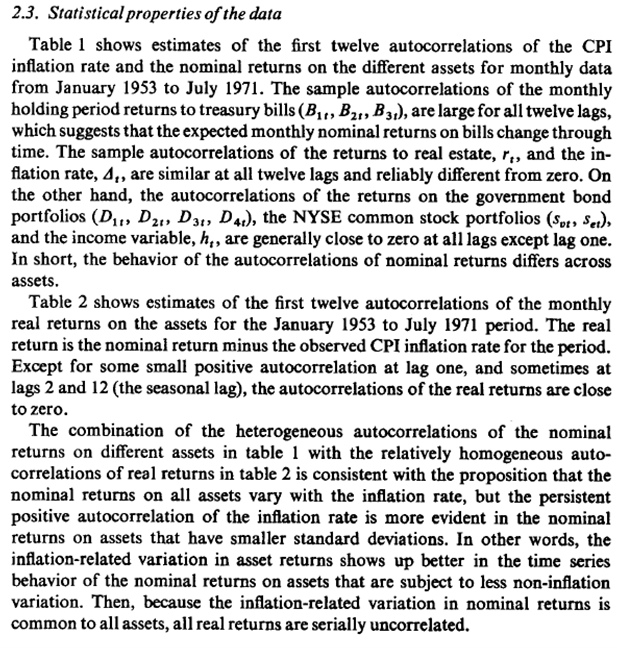

# ARIMA Model to Forecast Inflation


### ARIMA Model Overview

ARIMA stands for AutoRegressive Integrated Moving Average. It is a popular time series forecasting method that combines three components:
1. **AutoRegressive (AR) part**: This part involves regressing the variable on its own lagged (past) values. The order of the AR term is denoted by `p`.
2. **Integrated (I) part**: This part involves differencing the data to make it stationary. The order of differencing is denoted by `d`.
3. **Moving Average (MA) part**: This part involves modeling the error term as a linear combination of error terms occurring contemporaneously and at various times in the past. The order of the MA term is denoted by `q`.

### ARIMA Model Notation

An ARIMA model is typically denoted as ARIMA(p, d, q), where:
- `p` is the number of lag observations included in the model (the number of lagged terms).
- `d` is the number of times that the raw observations are differenced.
- `q` is the size of the moving average window (the number of lagged forecast errors).

### Steps to Build an ARIMA Model

1. **Visualize the Time Series**: Plot the time series data to understand its structure and identify any trends or seasonality.
2. **Make the Time Series Stationary**: Use differencing to remove trends and seasonality, making the time series stationary.
3. **Determine the Order of AR and MA Terms**: Use autocorrelation function (ACF) and partial autocorrelation function (PACF) plots to determine the appropriate values of `p` and `q`.
4. **Fit the ARIMA Model**: Use statistical software or libraries (e.g., `statsmodels` in Python) to fit the ARIMA model to the data.
5. **Evaluate the Model**: Check the residuals of the model to ensure they resemble white noise. Use metrics like AIC (Akaike Information Criterion) or BIC (Bayesian Information Criterion) to compare models.
6. **Forecast**: Use the fitted ARIMA model to make forecasts.

### Key Points to Consider

- **Stationarity**: The ARIMA model assumes that the time series is stationary. If the series is not stationary, you need to difference it until it becomes stationary.
- **Model Selection**: Use ACF and PACF plots to identify the appropriate values of `p` and `q`. The AIC and BIC metrics can help compare different models.
- **Residual Analysis**: After fitting the model, analyze the residuals to ensure they resemble white noise (i.e., they are uncorrelated and have a constant mean and variance).

### Extensions of ARIMA

- **Seasonal ARIMA (SARIMA)**: Extends ARIMA to handle seasonality by adding seasonal terms.
- **Auto ARIMA**: Automatically selects the best ARIMA model by optimizing the parameters `p`, `d`, and `q`.

You can apply the ARIMA model to any time series data where you want to understand the underlying patterns and make forecasts. In the context of your dissertation, here are some potential applications of the ARIMA model:

1. Forecasting Macroeconomic Variables
Monthly Inflation Rate: Use the ARIMA model to forecast future monthly inflation rates based on historical data.
Historical Volatility: Apply the ARIMA model to forecast future historical volatility of an asset or index.
GARCH Volatility: Although GARCH models are specifically designed for volatility, you can still use ARIMA models to forecast the volatility series if needed.
2. Forecasting Asset Returns
Individual Asset Returns: Use the ARIMA model to forecast future returns of individual assets such as SP500, Russell 2000, NASDAQ, FTSE, DAX, etc.
Portfolio Returns: If you have a portfolio of assets, you can use the ARIMA model to forecast the overall portfolio returns.
3. Analyzing and Forecasting Expected Inflation and Volatility
Expected Inflation (e.g., UMich Expected Inflation Rate): Use the ARIMA model to forecast future expected inflation rates.
Expected Volatility (e.g., VIX): Apply the ARIMA model to forecast future expected volatility.
Example: Applying ARIMA to Monthly Inflation Rate
Here is an example of how to apply the ARIMA model to forecast the Monthly Inflation Rate:

In [105]:
cpi_df.head()


CPI  Monthly Inflation Rate  YoY Inflation Rate
1980-01-31  78.0                1.430429           13.868613
1980-02-29  79.0                1.282051           14.161850
1980-03-31  80.1                1.392405           14.592275
1980-04-30  80.9                0.998752           14.589235
1980-05-31  81.7                0.988875           14.425770

In [106]:
msci_world.head()

.dMIWO00000PUS  Monthly Return  Cumulative Returns  Hist_Volatility  \
Date                                                                  
1980-01-31             0.05556            0.108193        12.654740   
1980-02-29           -0.002477            0.105452        12.288806   
1980-03-31           -0.117202           -0.016805        17.258290   
1980-04-30            0.060149            0.044148        18.362729   
1980-05-31             0.04486            0.092054        18.627168   

.dMIWO00000PUS  GARCH_Volatility  Historical Volatility  GARCH Volatility  
Date                                                                       
1980-01-31             14.164792                    NaN          0.044927  
1980-02-29             14.695518                    NaN          0.045169  
1980-03-31             13.772267                    NaN          0.042818  
1980-04-30             20.719724                    NaN          0.056627  
1980-05-31             19.899741                    NaN          0.055112

In [107]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

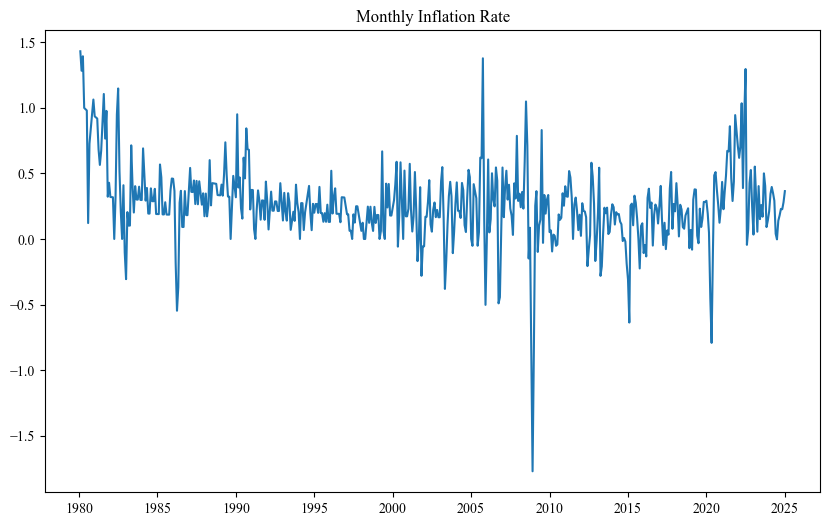

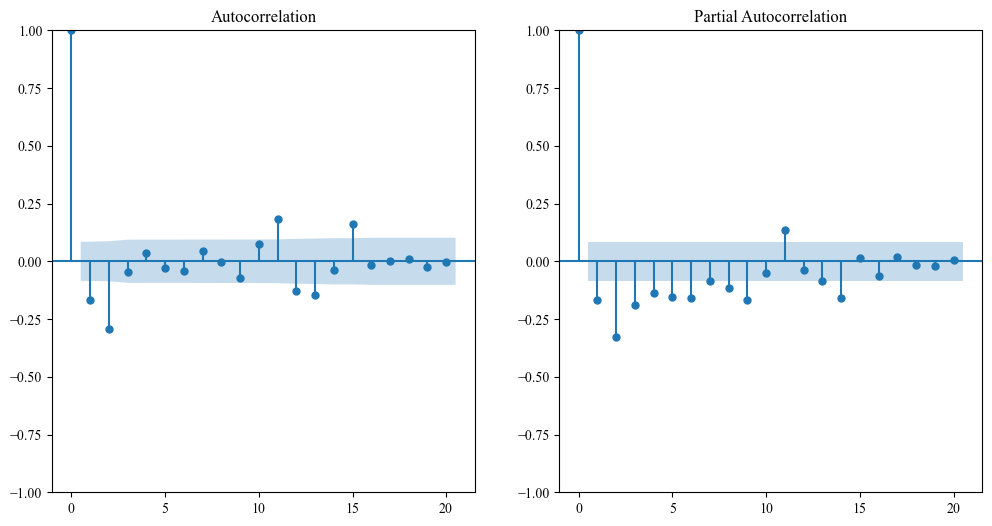

                                 SARIMAX Results                                  
Dep. Variable:     Monthly Inflation Rate   No. Observations:                  540
Model:                     ARIMA(1, 1, 1)   Log Likelihood                  -0.171
Date:                    Mon, 19 May 2025   AIC                              6.342
Time:                            20:20:20   BIC                             19.211
Sample:                        01-31-1980   HQIC                            11.375
                             - 12-31-2024                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4436      0.034     13.140      0.000       0.377       0.510
ma.L1         -0.9391      0.016    -59.972      0.000      -0.970      -0.908
sigma2         0.058

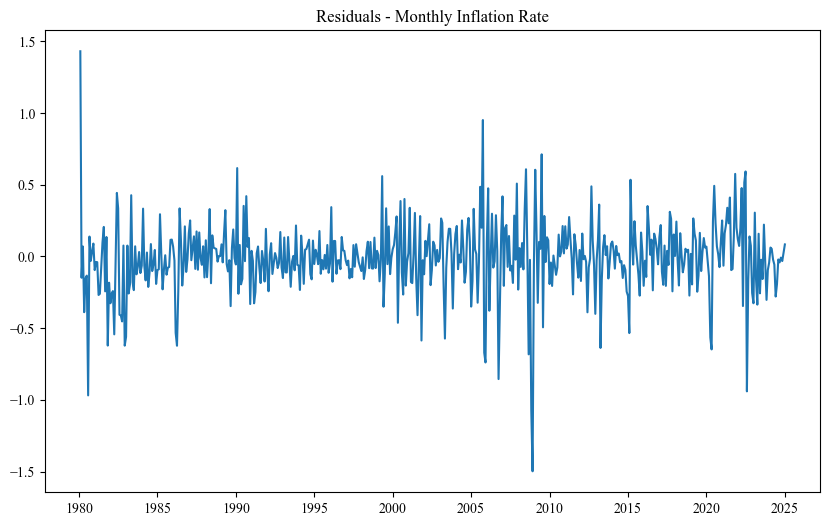

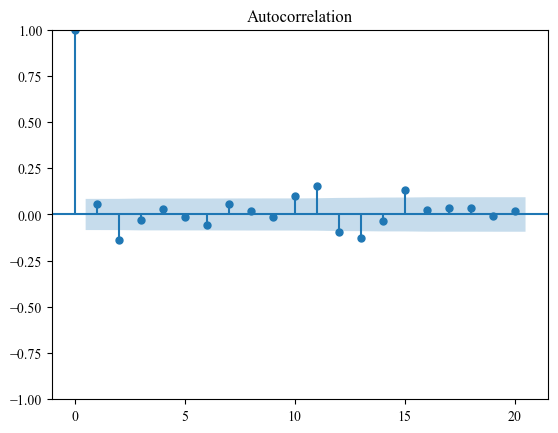

2025-01-31    0.323237
2025-02-28    0.304859
2025-03-31    0.296707
2025-04-30    0.293091
2025-05-31    0.291488
2025-06-30    0.290776
2025-07-31    0.290461
2025-08-31    0.290321
2025-09-30    0.290259
2025-10-31    0.290231
2025-11-30    0.290219
2025-12-31    0.290213
Freq: ME, Name: predicted_mean, dtype: float64


In [108]:
# Monthly Inflation Rate ARIMA Model
monthly_inflation_rate = cpi_df['Monthly Inflation Rate'].dropna()

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(monthly_inflation_rate)
plt.title('Monthly Inflation Rate')
plt.show()

# Make the time series stationary (if necessary)
monthly_inflation_diff = monthly_inflation_rate.diff().dropna()

# Plot ACF and PACF to determine p and q
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(monthly_inflation_diff, lags=20, ax=plt.gca())
plt.subplot(122)
plot_pacf(monthly_inflation_diff, lags=20, ax=plt.gca())
plt.show()

# Fit the ARIMA model
model_inflation = ARIMA(monthly_inflation_rate, order=(1, 1, 1))
model_inflation_fit = model_inflation.fit()

# Print the model summary
print(model_inflation_fit.summary())

# Plot the residuals
residuals_inflation = model_inflation_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals_inflation)
plt.title('Residuals - Monthly Inflation Rate')
plt.show()

# Plot ACF of residuals to check for white noise
plot_acf(residuals_inflation, lags=20)
plt.show()

# Forecast using the fitted model
forecast_inflation = model_inflation_fit.forecast(steps=12)  # Forecasting the next 12 months
print(forecast_inflation)

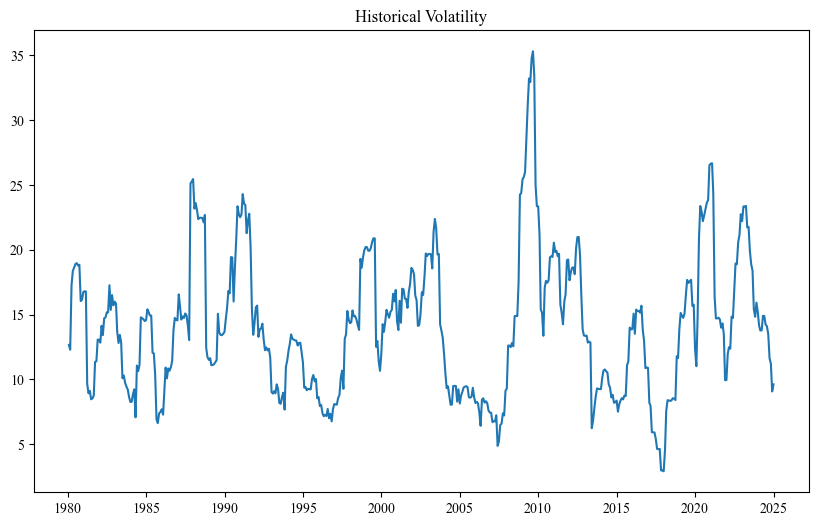

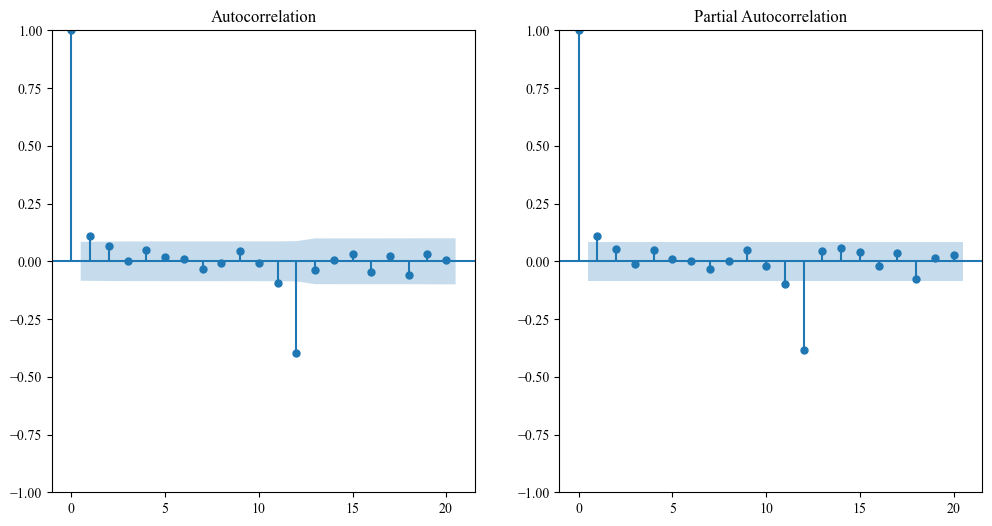

c:\Users\geral\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\geral\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\geral\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:        Hist_Volatility   No. Observations:                  540
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1038.629
Date:                Mon, 19 May 2025   AIC                           2083.258
Time:                        20:20:21   BIC                           2096.127
Sample:                    01-31-1980   HQIC                          2088.291
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5285      0.289      1.831      0.067      -0.037       1.094
ma.L1         -0.4236      0.301     -1.408      0.159      -1.013       0.166
sigma2         2.7621      0.064     43.451      0.0

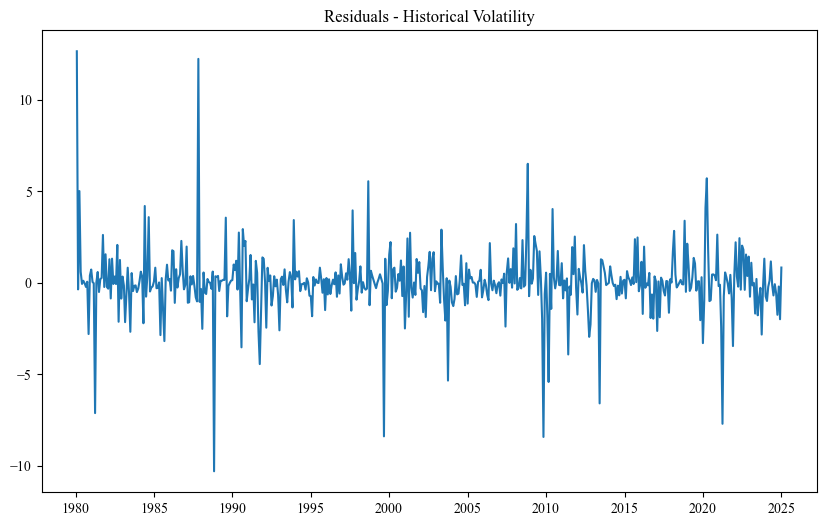

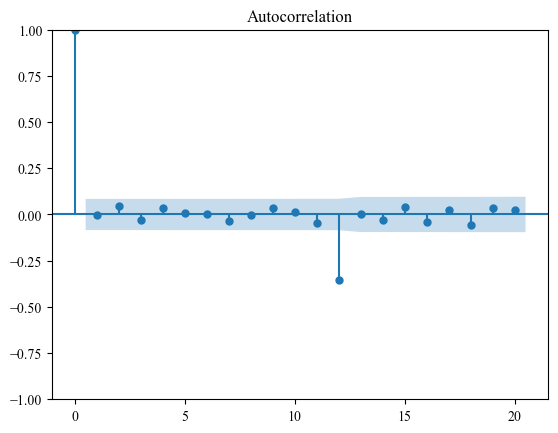

2025-01-31    9.547771
2025-02-28    9.514271
2025-03-31    9.496567
2025-04-30    9.487211
2025-05-31    9.482267
2025-06-30    9.479654
2025-07-31    9.478273
2025-08-31    9.477543
2025-09-30    9.477157
2025-10-31    9.476954
2025-11-30    9.476846
2025-12-31    9.476789
Freq: ME, Name: predicted_mean, dtype: float64


In [109]:


# Historical Volatility ARIMA Model
historical_volatility = msci_world['Hist_Volatility'].dropna()

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(historical_volatility)
plt.title('Historical Volatility')
plt.show()

# Make the time series stationary (if necessary)
historical_volatility_diff = historical_volatility.diff().dropna()

# Plot ACF and PACF to determine p and q
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(historical_volatility_diff, lags=20, ax=plt.gca())
plt.subplot(122)
plot_pacf(historical_volatility_diff, lags=20, ax=plt.gca())
plt.show()

# Fit the ARIMA model
model_hist_volatility = ARIMA(historical_volatility, order=(1, 1, 1))
model_hist_volatility_fit = model_hist_volatility.fit()

# Print the model summary
print(model_hist_volatility_fit.summary())

# Plot the residuals
residuals_hist_volatility = model_hist_volatility_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals_hist_volatility)
plt.title('Residuals - Historical Volatility')
plt.show()

# Plot ACF of residuals to check for white noise
plot_acf(residuals_hist_volatility, lags=20)
plt.show()

# Forecast using the fitted model
forecast_hist_volatility = model_hist_volatility_fit.forecast(steps=12)  # Forecasting the next 12 months
print(forecast_hist_volatility)

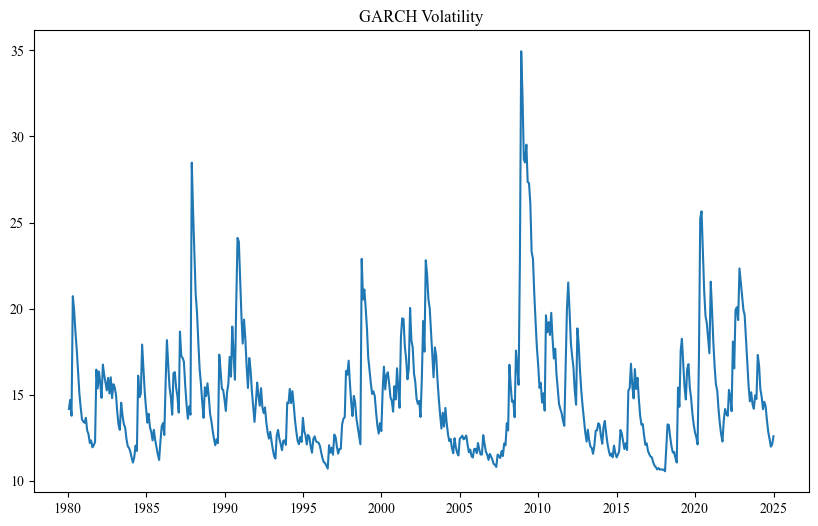

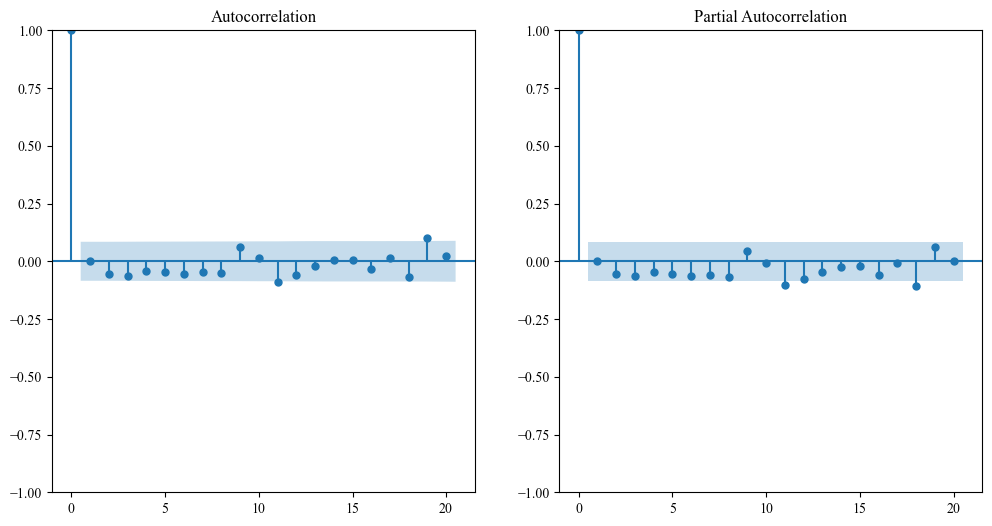

c:\Users\geral\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\geral\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\geral\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency ME will be used.
  self._init_dates(dates, freq)
c:\Users\geral\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\geral\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA param

                               SARIMAX Results                                
Dep. Variable:       GARCH_Volatility   No. Observations:                  540
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1047.388
Date:                Mon, 19 May 2025   AIC                           2100.777
Time:                        20:20:23   BIC                           2113.646
Sample:                    01-31-1980   HQIC                          2105.810
                         - 12-31-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0002     50.691   -3.8e-06      1.000     -99.352      99.352
ma.L1         -0.0005     50.695  -1.02e-05      1.000     -99.361      99.360
sigma2         2.8534      0.055     51.642      0.0

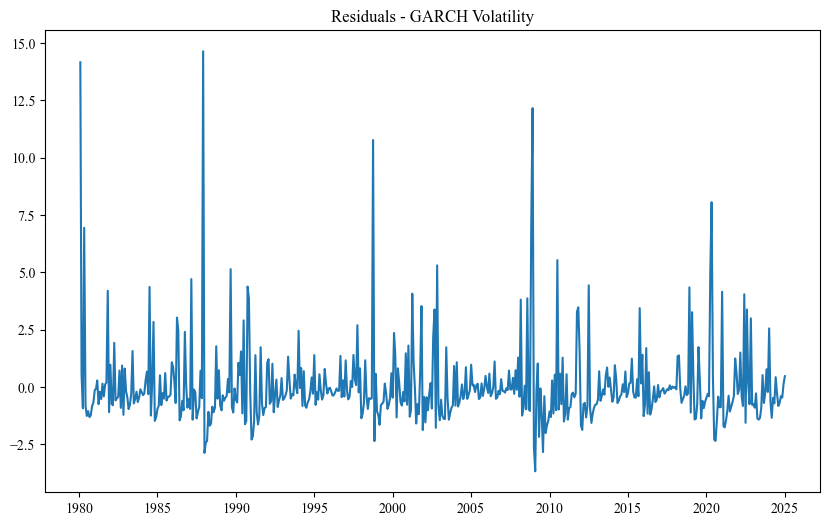

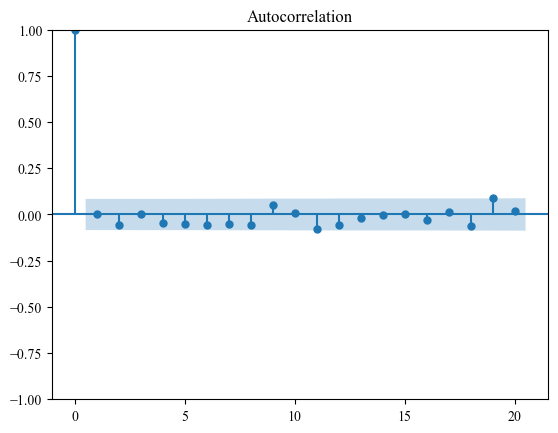

2025-01-31    12.578741
2025-02-28    12.578741
2025-03-31    12.578741
2025-04-30    12.578741
2025-05-31    12.578741
2025-06-30    12.578741
2025-07-31    12.578741
2025-08-31    12.578741
2025-09-30    12.578741
2025-10-31    12.578741
2025-11-30    12.578741
2025-12-31    12.578741
Freq: ME, Name: predicted_mean, dtype: float64


In [110]:
# GARCH Volatility ARIMA Model
garch_volatility = msci_world['GARCH_Volatility'].dropna()

# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(garch_volatility)
plt.title('GARCH Volatility')
plt.show()

# Make the time series stationary (if necessary)
garch_volatility_diff = garch_volatility.diff().dropna()

# Plot ACF and PACF to determine p and q
plt.figure(figsize=(12, 6))
plt.subplot(121)
plot_acf(garch_volatility_diff, lags=20, ax=plt.gca())
plt.subplot(122)
plot_pacf(garch_volatility_diff, lags=20, ax=plt.gca())
plt.show()

# Fit the ARIMA model
model_garch_volatility = ARIMA(garch_volatility, order=(1, 1, 1))
model_garch_volatility_fit = model_garch_volatility.fit()

# Print the model summary
print(model_garch_volatility_fit.summary())

# Plot the residuals
residuals_garch_volatility = model_garch_volatility_fit.resid
plt.figure(figsize=(10, 6))
plt.plot(residuals_garch_volatility)
plt.title('Residuals - GARCH Volatility')
plt.show()

# Plot ACF of residuals to check for white noise
plot_acf(residuals_garch_volatility, lags=20)
plt.show()

# Forecast using the fitted model
forecast_garch_volatility = model_garch_volatility_fit.forecast(steps=12)  # Forecasting the next 12 months
print(forecast_garch_volatility)

## Regressions



Lagged Variables:

Besides the previous month's inflation rate, you could include other lagged variables (e.g., 2 months, 3 months) to see if they have any predictive power.
Multiple Regression:

Include multiple independent variables in your regression model, such as both the current and previous month's inflation rates, or other economic indicators.
Interaction Terms:

Include interaction terms to see if the relationship between inflation and returns changes under different conditions.
Rolling Window Regression:

Perform rolling window regressions to see how the relationship between inflation and returns changes over time.
Different Time Horizons:

Perform regressions using different time horizons for returns (e.g., weekly, quarterly) to see if the relationship holds at different frequencies.
Volatility Measures:

Include measures of volatility (e.g., GARCH volatility) as independent variables to see if they have any explanatory power.

Given the assets, macroeconomic variables, expected inflation data, expected volatility (VIX), and factor models, here are some regressions that could be worth doing:

Asset Returns vs. Macroeconomic Variables:

Regress the returns of each asset on the YoY Inflation Rate (lagged), Historical Volatility (lagged), and GARCH Volatility (lagged).
This will help you understand how macroeconomic variables impact the returns of each asset.
Asset Returns vs. Expected Inflation and Expected Volatility:

Regress the returns of each asset on the expected inflation data (e.g., UMich Expected Inflation Rate) and expected volatility (VIX).
This will help you understand how expectations about inflation and volatility impact the returns of each asset.
Asset Returns vs. Factor Models:

Perform CAPM regression: Regress the returns of each asset on the market excess returns (Mkt-RF).
Perform Fama-French 3-Factor Model regression: Regress the returns of each asset on the three Fama-French factors (Mkt-RF, SMB, HML).
Perform Carhart 4-Factor Model regression: Regress the returns of each asset on the four Carhart factors (Mkt-RF, SMB, HML, Mom).
Perform Fama-French 5-Factor Model regression: Regress the returns of each asset on the five Fama-French factors (Mkt-RF, SMB, HML, RMW, CMA).
Perform Fama-French 5-Factor Model with Momentum regression: Regress the returns of each asset on the five Fama-French factors plus the momentum factor (Mkt-RF, SMB, HML, RMW, CMA, Mom).
These regressions will help you understand how different factors explain the returns of each asset.

## FACTOR MODELS MAINLY FOR ROBUSTNESS

In [111]:
import pandas as pd
import pandas_datareader.data as web

# Define the start and end dates for the data
start_date = '1980-01-01'
end_date = '2024-12-31'

# Fetch Fama-French 3-Factor data (daily)
ff3 = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start_date, end_date)[0]
ff3.columns = ['Mkt-RF', 'SMB', 'HML', 'RF']

# Resample to get end-of-month data
ff3 = ff3.resample('M').last()

# Fetch Carhart 4-Factor data (daily)
carhart = web.DataReader('F-F_Momentum_Factor_daily', 'famafrench', start_date, end_date)[0]
carhart.columns = ['Mom']

# Resample to get end-of-month data
carhart = carhart.resample('M').last()

# Merge Carhart 4-Factor data with Fama-French 3-Factor data
carhart_merged = ff3.join(carhart, how='inner')

# Fetch Fama-French 5-Factor data (daily)
ff5 = web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', start_date, end_date)[0]
ff5.columns = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']

# Resample to get end-of-month data
ff5 = ff5.resample('M').last()


# Divide all factor values by 100 to convert from percent to decimal
ff3 = ff3 / 100
carhart_merged = carhart_merged / 100
ff5 = ff5 / 100


# Display the first few rows of each dataset
print("Fama-French 3-Factor Model Data:")
print(ff3.head())

print("\nCarhart 4-Factor Model Data:")
print(carhart_merged.head())

print("\nFama-French 5-Factor Model Data:")
print(ff5.head())


C:\Users\geral\AppData\Local\Temp\ipykernel_32220\237367913.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff3 = web.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start_date, end_date)[0]
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\237367913.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ff3 = ff3.resample('M').last()
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\237367913.py:16: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  carhart = web.DataReader('F-F_Momentum_Factor_daily', 'famafrench', start_date, end_date)[0]
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\237367913.py:20: FutureWarni

Fama-French 3-Factor Model Data:
            Mkt-RF     SMB     HML       RF
Date                                       
1980-01-31 -0.0072  0.0053  0.0017  0.00036
1980-02-29  0.0097 -0.0067 -0.0010  0.00044
1980-03-31  0.0146  0.0012 -0.0016  0.00057
1980-04-30  0.0029 -0.0004  0.0019  0.00059
1980-05-31  0.0070 -0.0046  0.0002  0.00038

Carhart 4-Factor Model Data:
            Mkt-RF     SMB     HML       RF     Mom
Date                                               
1980-01-31 -0.0072  0.0053  0.0017  0.00036  0.0001
1980-02-29  0.0097 -0.0067 -0.0010  0.00044 -0.0017
1980-03-31  0.0146  0.0012 -0.0016  0.00057  0.0081
1980-04-30  0.0029 -0.0004  0.0019  0.00059 -0.0034
1980-05-31  0.0070 -0.0046  0.0002  0.00038  0.0022

Fama-French 5-Factor Model Data:
            Mkt-RF     SMB     HML     RMW     CMA       RF
Date                                                       
1980-01-31 -0.0072  0.0056  0.0017  0.0003  0.0010  0.00036
1980-02-29  0.0097 -0.0070 -0.0010 -0.0026 -0.0018 

C:\Users\geral\AppData\Local\Temp\ipykernel_32220\237367913.py:30: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ff5 = ff5.resample('M').last()


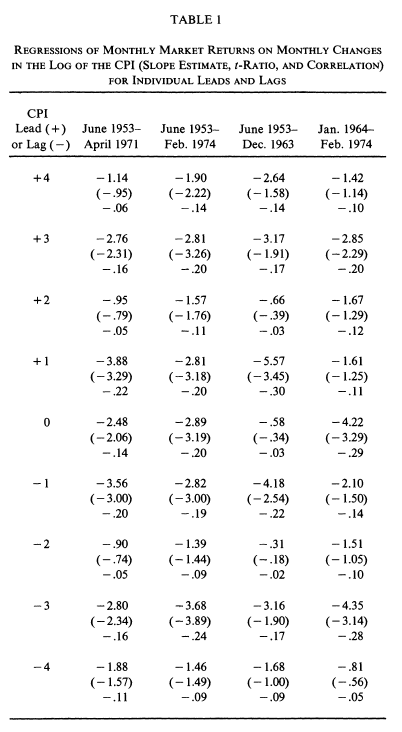

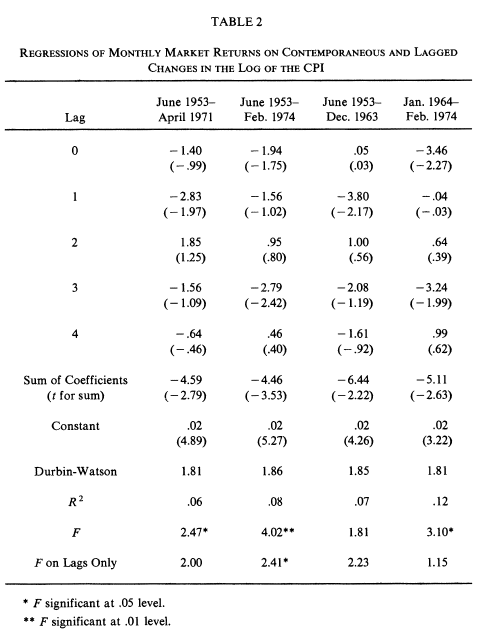

In [112]:
# Rename the index of cpi_df to 'Date'
cpi_df.index.name = 'Date'

cpi_df.head()

CPI  Monthly Inflation Rate  YoY Inflation Rate
Date                                                        
1980-01-31  78.0                1.430429           13.868613
1980-02-29  79.0                1.282051           14.161850
1980-03-31  80.1                1.392405           14.592275
1980-04-30  80.9                0.998752           14.589235
1980-05-31  81.7                0.988875           14.425770

In [113]:
# List of asset DataFrames
assets = {
    "SP500": sp500_df,
    "Russell 2000": russell2000_data,
    "NASDAQ": nasdaq_data,
    "FTSE": FTSE_data,
    "DAX": dax_data,
    "STOXX": stoxx_data,
    "Nikkei": nikkei_data,
    "Gold": gold_data,
    "Oil": oil_data,
    "10 Year Treasury Note": gs10_data,
    "TIPS ETF": tip_etf_data,
    "Na REIT": nareit_data,
    "EUR/USD": EUR_USD_data,
    "JPY/USD": JPY_USD_data,
    "CHF/USD": CHF_USD_data
}

# Rename the index of each asset DataFrame to 'Date'
for asset_name, asset_df in assets.items():
    assets[asset_name] = asset_df.rename_axis('Date')

# Print the first few rows of each DataFrame to verify
for asset_name, asset_df in assets.items():
    print(f'{asset_name} DataFrame:')
    print(asset_df.head())
    print('\n')

SP500 DataFrame:
            Monthly Return  Cumulative Return  5-Year Interval
Date                                                          
1980-01-31        0.056025           0.057625             1980
1980-02-29       -0.004389           0.052992             1980
1980-03-31       -0.107357          -0.054197             1980
1980-04-30        0.040316          -0.015286             1980
1980-05-30        0.045519           0.030573             1980


Russell 2000 DataFrame:
.RUT        Monthly Return  Cumulative Return  5-Year Interval
Date                                                          
1980-01-31        0.078934           0.082133             1980
1980-02-29       -0.021365           0.059258             1980
1980-03-31        -0.20457          -0.136707             1980
1980-04-30        0.058548          -0.084654             1980
1980-05-31        0.076677          -0.011707             1980


NASDAQ DataFrame:
.IXIC       Monthly Return  Cumulative Return  5-Year I

In [114]:
print(nasdaq_data.index.name)

Date


In [115]:
# Create lag variables for YoY inflation rate
for lag in range(1, 6):  # from 1 (lag) to 5 (lag)
    cpi_df[f'YoY_Inflation_Lag{lag}'] = cpi_df['YoY Inflation Rate'].shift(lag)

# Display the entire DataFrame to check the lag variables
print(cpi_df)

                CPI  Monthly Inflation Rate  YoY Inflation Rate  \
Date                                                              
1980-01-31   78.000                1.430429           13.868613   
1980-02-29   79.000                1.282051           14.161850   
1980-03-31   80.100                1.392405           14.592275   
1980-04-30   80.900                0.998752           14.589235   
1980-05-31   81.700                0.988875           14.425770   
...             ...                     ...                 ...   
2024-08-31  314.131                0.180185            2.610914   
2024-09-30  314.851                0.229204            2.432541   
2024-10-31  315.564                0.226456            2.571403   
2024-11-30  316.449                0.280450            2.714168   
2024-12-31  317.603                0.364672            2.872366   

            YoY_Inflation_Lag1  YoY_Inflation_Lag2  YoY_Inflation_Lag3  \
Date                                                  

In [116]:
# Save the DataFrame to a CSV file to inspect the lag variables
cpi_df.to_csv('cpi_with_lags.csv')

In [117]:
# List of asset DataFrames
assets = {
    "SP500": sp500_df,
    "Russell 2000": russell2000_data,
    "NASDAQ": nasdaq_data,
    "FTSE": FTSE_data,
    "DAX": dax_data,
    "STOXX": stoxx_data,
    "Nikkei": nikkei_data,
    "Gold": gold_data,
    "Oil": oil_data,
    "10 Year Treasury Note": gs10_data,
    "TIPS ETF": tip_etf_data,
    "Na REIT": nareit_data,
    "EUR/USD": EUR_USD_data,
    "JPY/USD": JPY_USD_data,
    "CHF/USD": CHF_USD_data
}

# Resample each asset DataFrame to the end of the month
for asset_name, asset_df in assets.items():
    assets[asset_name] = asset_df.resample('M').last()

# Display the resampled DataFrames
for asset_name, asset_df in assets.items():
    print(f"{asset_name} DataFrame:")
    print(asset_df.head())
    print()

C:\Users\geral\AppData\Local\Temp\ipykernel_32220\1075132694.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  assets[asset_name] = asset_df.resample('M').last()


SP500 DataFrame:
            Monthly Return  Cumulative Return  5-Year Interval
Date                                                          
1980-01-31        0.056025           0.057625             1980
1980-02-29       -0.004389           0.052992             1980
1980-03-31       -0.107357          -0.054197             1980
1980-04-30        0.040316          -0.015286             1980
1980-05-31        0.045519           0.030573             1980

Russell 2000 DataFrame:
.RUT        Monthly Return  Cumulative Return  5-Year Interval
Date                                                          
1980-01-31        0.078934           0.082133             1980
1980-02-29       -0.021365           0.059258             1980
1980-03-31        -0.20457          -0.136707             1980
1980-04-30        0.058548          -0.084654             1980
1980-05-31        0.076677          -0.011707             1980

NASDAQ DataFrame:
.IXIC       Monthly Return  Cumulative Return  5-Year Int

In [118]:
# Create an empty DataFrame to store the combined monthly returns
big_monthlyret = pd.DataFrame()

# Iterate over each asset and resample to end of month, then add to combined DataFrame
for asset_name, asset_df in assets.items():
    # Resample to end of month
    asset_df_resampled = asset_df.resample('M').last()
    
    # Add the "Monthly Return" column to the combined DataFrame
    big_monthlyret[asset_name] = asset_df_resampled['Monthly Return']


C:\Users\geral\AppData\Local\Temp\ipykernel_32220\1755140814.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  asset_df_resampled = asset_df.resample('M').last()
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\1755140814.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  asset_df_resampled = asset_df.resample('M').last()
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\1755140814.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  asset_df_resampled = asset_df.resample('M').last()
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\1755140814.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  asset_df_resampled = asset_df.resample('M').last()
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\1755140814.py:7: FutureWarning: 'M' is deprecated and will be removed in a

In [119]:
big_monthlyret['RF'] = ff3['RF']

big_monthlyret.head()

SP500  Russell 2000    NASDAQ  FTSE   DAX  STOXX  Nikkei  \
Date                                                                      
1980-01-31  0.056025      0.078934      <NA>  <NA>  <NA>   <NA>     NaN   
1980-02-29 -0.004389     -0.021365      <NA>  <NA>  <NA>   <NA>     NaN   
1980-03-31 -0.107357      -0.20457      <NA>  <NA>  <NA>   <NA>     NaN   
1980-04-30  0.040316      0.058548  0.066367  <NA>  <NA>   <NA>     NaN   
1980-05-31  0.045519      0.076677   0.07206  <NA>  <NA>   <NA>     NaN   

                Gold   Oil  10 Year Treasury Note  TIPS ETF   Na REIT  \
Date                                                                    
1980-01-31  0.243253  <NA>              -0.038197      <NA>  0.066574   
1980-02-29 -0.024807  <NA>              -0.051827      <NA> -0.011724   
1980-03-31 -0.252212  <NA>               0.047212      <NA> -0.142868   
1980-04-30  0.045417  <NA>               0.081004      <NA>  0.081311   
1980-05-31  0.033226  <NA>               0.037760      <NA>  0.073786   

             EUR/USD   JPY/USD   CHF/USD       RF  
Date                                               
1980-01-31  0.009059  0.004045 -0.021018  0.00036  
1980-02-29  0.017278 -0.050196 -0.043873  0.00044  
1980-03-31  0.085002  0.006778 -0.082091  0.00057  
1980-04-30 -0.066935  0.043334  0.103457  0.00059  
1980-05-31 -0.015135  0.070755  0.007829  0.00038

In [120]:
cpi_df.head()

CPI  Monthly Inflation Rate  YoY Inflation Rate  \
Date                                                           
1980-01-31  78.0                1.430429           13.868613   
1980-02-29  79.0                1.282051           14.161850   
1980-03-31  80.1                1.392405           14.592275   
1980-04-30  80.9                0.998752           14.589235   
1980-05-31  81.7                0.988875           14.425770   

            YoY_Inflation_Lag1  YoY_Inflation_Lag2  YoY_Inflation_Lag3  \
Date                                                                     
1980-01-31                 NaN                 NaN                 NaN   
1980-02-29           13.868613                 NaN                 NaN   
1980-03-31           14.161850           13.868613                 NaN   
1980-04-30           14.592275           14.161850           13.868613   
1980-05-31           14.589235           14.592275           14.161850   

            YoY_Inflation_Lag4  YoY_Inflation_Lag5  
Date                                                
1980-01-31                 NaN                 NaN  
1980-02-29                 NaN                 NaN  
1980-03-31                 NaN                 NaN  
1980-04-30                 NaN                 NaN  
1980-05-31           13.868613                 NaN

In [121]:
# Create a new DataFrame to store the excess returns
excess_returns = pd.DataFrame()

# Calculate the excess returns for each asset
for asset_name in big_monthlyret.columns:
    if asset_name != 'RF':
        excess_returns[asset_name] = big_monthlyret[asset_name] - big_monthlyret['RF']

# Display the excess returns DataFrame
print(excess_returns)

               SP500  Russell 2000    NASDAQ      FTSE       DAX     STOXX  \
Date                                                                         
1980-01-31  0.055665      0.078574      <NA>      <NA>      <NA>      <NA>   
1980-02-29 -0.004829     -0.021805      <NA>      <NA>      <NA>      <NA>   
1980-03-31 -0.107927      -0.20514      <NA>      <NA>      <NA>      <NA>   
1980-04-30  0.039726      0.057958  0.065777      <NA>      <NA>      <NA>   
1980-05-31  0.045139      0.076297   0.07168      <NA>      <NA>      <NA>   
...              ...           ...       ...       ...       ...       ...   
2024-08-31  0.022358     -0.016701  0.006249  0.000813   0.02107  0.017081   
2024-09-30  0.019796      0.005348  0.026292 -0.017016  0.021668   0.00833   
2024-10-31 -0.010116     -0.015224 -0.005352  -0.01569 -0.013054 -0.035342   
2024-11-30  0.055520      0.102699  0.060012  0.021414  0.028166 -0.005023   
2024-12-31 -0.025478     -0.087932  0.004638 -0.014056  0.014131

In [122]:
excess_returns.to_csv('excess_returns.csv')

# Regressions Assets

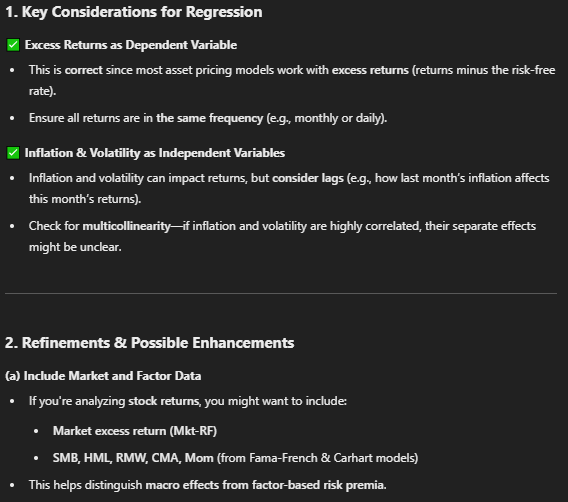

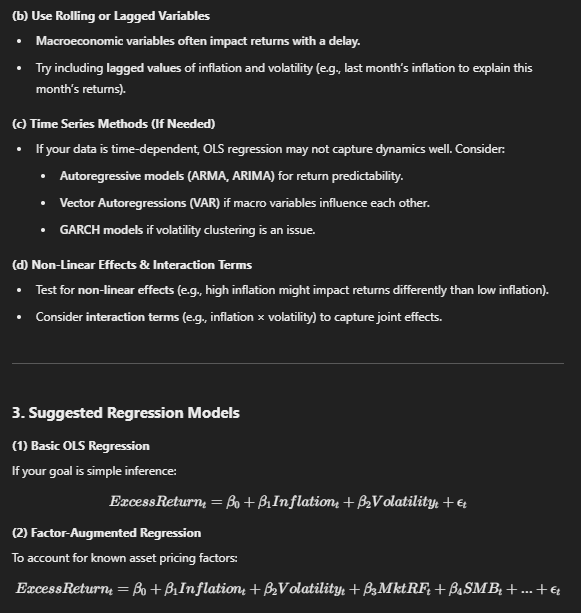

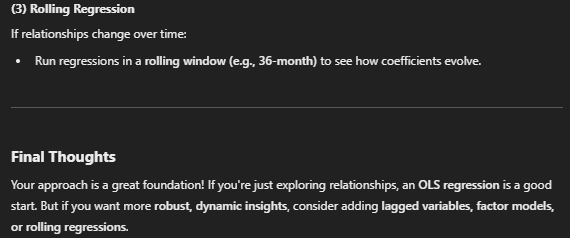

In [123]:
# Divide all variables by 100
combined_df[['YoY Inflation Rate', 'Hist_Volatility', 'GARCH_Volatility']] = combined_df[['YoY Inflation Rate', 'Hist_Volatility', 'GARCH_Volatility']] / 100


combined_df.head()

YoY Inflation Rate  Hist_Volatility  GARCH_Volatility
1980-01-31            0.138686         0.126547          0.141648
1980-02-29            0.141618         0.122888          0.146955
1980-03-31            0.145923         0.172583          0.137723
1980-04-30            0.145892         0.183627          0.207197
1980-05-31            0.144258         0.186272          0.198997

In [124]:
# Merge excess_returns with cpi_df's "YoY Inflation Rate"
excess_ret_with_hist_data = pd.merge(excess_returns, combined_df[['YoY Inflation Rate']], left_index=True, right_index=True)

# Merge the result with msci_world's "Hist_Volatility" and "GARCH_Volatility"
excess_ret_with_hist_data = pd.merge(excess_ret_with_hist_data, combined_df[['Hist_Volatility', 'GARCH_Volatility']], left_index=True, right_index=True)

# Display the new DataFrame
excess_ret_with_hist_data.head()

SP500  Russell 2000    NASDAQ  FTSE   DAX  STOXX  Nikkei  \
Date                                                                      
1980-01-31  0.055665      0.078574      <NA>  <NA>  <NA>   <NA>     NaN   
1980-02-29 -0.004829     -0.021805      <NA>  <NA>  <NA>   <NA>     NaN   
1980-03-31 -0.107927      -0.20514      <NA>  <NA>  <NA>   <NA>     NaN   
1980-04-30  0.039726      0.057958  0.065777  <NA>  <NA>   <NA>     NaN   
1980-05-31  0.045139      0.076297   0.07168  <NA>  <NA>   <NA>     NaN   

                Gold   Oil  10 Year Treasury Note  TIPS ETF   Na REIT  \
Date                                                                    
1980-01-31  0.242893  <NA>              -0.038557      <NA>  0.066214   
1980-02-29 -0.025247  <NA>              -0.052267      <NA> -0.012164   
1980-03-31 -0.252782  <NA>               0.046642      <NA> -0.143438   
1980-04-30  0.044827  <NA>               0.080414      <NA>  0.080721   
1980-05-31  0.032846  <NA>               0.037380      <NA>  0.073406   

             EUR/USD   JPY/USD   CHF/USD  YoY Inflation Rate  Hist_Volatility  \
Date                                                                            
1980-01-31  0.008699  0.003685 -0.021378            0.138686         0.126547   
1980-02-29  0.016838 -0.050636 -0.044313            0.141618         0.122888   
1980-03-31  0.084432  0.006208 -0.082661            0.145923         0.172583   
1980-04-30 -0.067525  0.042744  0.102867            0.145892         0.183627   
1980-05-31 -0.015515  0.070375  0.007449            0.144258         0.186272   

            GARCH_Volatility  
Date                          
1980-01-31          0.141648  
1980-02-29          0.146955  
1980-03-31          0.137723  
1980-04-30          0.207197  
1980-05-31          0.198997

## 1. Regressions with Historical Data

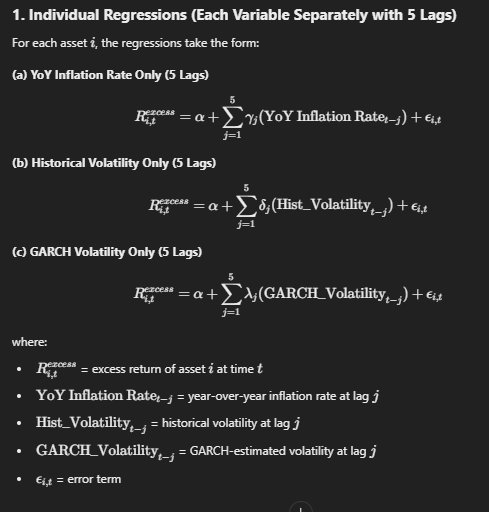

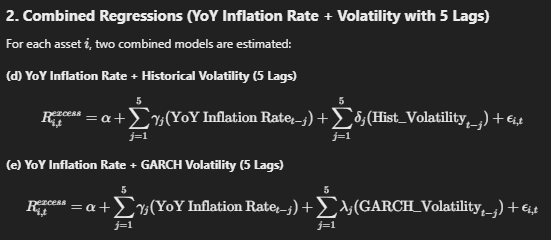

In [125]:

# Create lagged variables (up to 5 lags for each independent variable)
for lag in range(1, 6):  # 5 lags
    excess_ret_with_hist_data[f'YoY Inflation Rate Lag{lag}'] = excess_ret_with_hist_data['YoY Inflation Rate'].shift(lag)
    excess_ret_with_hist_data[f'Hist_Volatility Lag{lag}'] = excess_ret_with_hist_data['Hist_Volatility'].shift(lag)
    excess_ret_with_hist_data[f'GARCH_Volatility Lag{lag}'] = excess_ret_with_hist_data['GARCH_Volatility'].shift(lag)

# List of assets to analyze
assets = ['SP500', 'Russell 2000', 'NASDAQ', 'FTSE', 'DAX', 'STOXX', 'Nikkei', 'Gold', 'Oil', 
          '10 Year Treasury Note', 'TIPS ETF', 'Na REIT', 
          'EUR/USD', 'JPY/USD', 'CHF/USD']

# Function to format p-values with stars
def significance_stars(p):
    if p < 0.01:
        return "***"  # Highly significant
    elif p < 0.05:
        return "**"   # Moderately significant
    elif p < 0.1:
        return "*"    # Weakly significant
    else:
        return ""     # Not significant

# Store results in a DataFrame for display
results_summary = []

# Run regressions for each asset
for asset in assets:
    y = excess_ret_with_hist_data[asset].dropna()
    
    # Individual regressions (each independent variable separately with 5 lags)
    for var in ['YoY Inflation Rate', 'Hist_Volatility', 'GARCH_Volatility']:
        X = excess_ret_with_hist_data[[f'{var} Lag{i}' for i in range(1, 6)]].loc[y.index]
        X = sm.add_constant(X)  # Add intercept
        model = sm.OLS(y, X, missing='drop').fit()
        
        # Store results
        for coef_name, coef, tstat, pval in zip(model.params.index, model.params, model.tvalues, model.pvalues):
            results_summary.append([asset, f"{var} (5 lags)", coef_name, coef, tstat, pval, model.rsquared, significance_stars(pval)])
    
    # Regression combining YoY Inflation Rate with each Volatility measure (5 lags)
    for vol in ['Hist_Volatility', 'GARCH_Volatility']:
        X = excess_ret_with_hist_data[[f'YoY Inflation Rate Lag{i}' for i in range(1, 6)] +
                                      [f'{vol} Lag{i}' for i in range(1, 6)]].loc[y.index]
        X = sm.add_constant(X)  # Add intercept
        model = sm.OLS(y, X, missing='drop').fit()
        
        # Store results
        for coef_name, coef, tstat, pval in zip(model.params.index, model.params, model.tvalues, model.pvalues):
            results_summary.append([asset, f"Inflation + {vol} (5 lags)", coef_name, coef, tstat, pval, model.rsquared, significance_stars(pval)])

# Convert to DataFrame for easy viewing
results_df = pd.DataFrame(results_summary, columns=['Asset', 'Regression Model', 'Variable', 'Coefficient', 'T-Statistic', 'p-value', 'R-squared', 'Significance'])

# Display results
print(results_df)

# Save results to CSV
results_df.to_csv('regression_results_simple_models.csv', index=False)

print("Regression results have been saved to 'regression_results_simple_models.csv'.")

       Asset                       Regression Model                 Variable  \
0      SP500            YoY Inflation Rate (5 lags)                    const   
1      SP500            YoY Inflation Rate (5 lags)  YoY Inflation Rate Lag1   
2      SP500            YoY Inflation Rate (5 lags)  YoY Inflation Rate Lag2   
3      SP500            YoY Inflation Rate (5 lags)  YoY Inflation Rate Lag3   
4      SP500            YoY Inflation Rate (5 lags)  YoY Inflation Rate Lag4   
..       ...                                    ...                      ...   
595  CHF/USD  Inflation + GARCH_Volatility (5 lags)    GARCH_Volatility Lag1   
596  CHF/USD  Inflation + GARCH_Volatility (5 lags)    GARCH_Volatility Lag2   
597  CHF/USD  Inflation + GARCH_Volatility (5 lags)    GARCH_Volatility Lag3   
598  CHF/USD  Inflation + GARCH_Volatility (5 lags)    GARCH_Volatility Lag4   
599  CHF/USD  Inflation + GARCH_Volatility (5 lags)    GARCH_Volatility Lag5   

     Coefficient  T-Statistic   p-value

In [126]:
# ...existing code...

# Store results in a DataFrame for display
multi_results_summary = []

# Run regressions for each asset
for asset in assets:
    y = excess_ret_with_hist_data[asset].dropna()
    y_index = y.index

    # Regression: YoY Inflation Rate + Hist_Volatility (5 lags)
    X_hist = excess_ret_with_hist_data[
        [f'YoY Inflation Rate Lag{i}' for i in range(1, 6)] +
        [f'Hist_Volatility Lag{i}' for i in range(1, 6)]
    ].loc[y_index]
    X_hist = sm.add_constant(X_hist)
    model_hist = sm.OLS(y, X_hist, missing='drop').fit()
    for coef_name, coef, tstat, pval in zip(model_hist.params.index, model_hist.params, model_hist.tvalues, model_hist.pvalues):
        multi_results_summary.append([asset, "Inflation + Hist_Volatility (5 lags)", coef_name, coef, tstat, pval, model_hist.rsquared, significance_stars(pval)])

    # Regression: YoY Inflation Rate + GARCH_Volatility (5 lags)
    X_garch = excess_ret_with_hist_data[
        [f'YoY Inflation Rate Lag{i}' for i in range(1, 6)] +
        [f'GARCH_Volatility Lag{i}' for i in range(1, 6)]
    ].loc[y_index]
    X_garch = sm.add_constant(X_garch)
    model_garch = sm.OLS(y, X_garch, missing='drop').fit()
    for coef_name, coef, tstat, pval in zip(model_garch.params.index, model_garch.params, model_garch.tvalues, model_garch.pvalues):
        multi_results_summary.append([asset, "Inflation + GARCH_Volatility (5 lags)", coef_name, coef, tstat, pval, model_garch.rsquared, significance_stars(pval)])

# Convert to DataFrame for easy viewing
multi_results_df = pd.DataFrame(multi_results_summary, columns=['Asset', 'Regression Model', 'Variable', 'Coefficient', 'T-Statistic', 'p-value', 'R-squared', 'Significance'])

# Display results
print(multi_results_df)

# Save results to CSV
multi_results_df.to_csv('regression_results_multivariable_models.csv', index=False)

print("Regression results have been saved to 'regression_results_multivariable_models.csv'.")
# ...existing code...

       Asset                       Regression Model                 Variable  \
0      SP500   Inflation + Hist_Volatility (5 lags)                    const   
1      SP500   Inflation + Hist_Volatility (5 lags)  YoY Inflation Rate Lag1   
2      SP500   Inflation + Hist_Volatility (5 lags)  YoY Inflation Rate Lag2   
3      SP500   Inflation + Hist_Volatility (5 lags)  YoY Inflation Rate Lag3   
4      SP500   Inflation + Hist_Volatility (5 lags)  YoY Inflation Rate Lag4   
..       ...                                    ...                      ...   
325  CHF/USD  Inflation + GARCH_Volatility (5 lags)    GARCH_Volatility Lag1   
326  CHF/USD  Inflation + GARCH_Volatility (5 lags)    GARCH_Volatility Lag2   
327  CHF/USD  Inflation + GARCH_Volatility (5 lags)    GARCH_Volatility Lag3   
328  CHF/USD  Inflation + GARCH_Volatility (5 lags)    GARCH_Volatility Lag4   
329  CHF/USD  Inflation + GARCH_Volatility (5 lags)    GARCH_Volatility Lag5   

     Coefficient  T-Statistic   p-value

### Use This One

In [127]:

num_lags = 5  # Set this to match your regression lag count

def build_summary_table(multi_results_df, assets, regression_model, infl_var, vol_var, filename):
    summary_rows = []
    for asset in assets:
        df = multi_results_df[
            (multi_results_df['Asset'] == asset) &
            (multi_results_df['Regression Model'] == regression_model)
        ]
        def get_coef_info(var):
            row = df[df['Variable'] == var]
            if not row.empty:
                coef = row['Coefficient'].values[0]
                pval = row['p-value'].values[0]
                stars = row['Significance'].values[0]
                return f"{coef:.4f}{stars}\n({pval:.3f})"
            else:
                return np.nan

        alpha = get_coef_info('const')
        infl_betas = [get_coef_info(f'{infl_var} Lag{i}') for i in range(1, num_lags+1)]
        vol_betas = [get_coef_info(f'{vol_var} Lag{i}') for i in range(1, num_lags+1)]

        # Sums (unformatted, just numbers)
        sum_infl = sum([
            df[df['Variable'] == f'{infl_var} Lag{i}']['Coefficient'].values[0]
            for i in range(1, num_lags+1) if not df[df['Variable'] == f'{infl_var} Lag{i}'].empty
        ])
        sum_vol = sum([
            df[df['Variable'] == f'{vol_var} Lag{i}']['Coefficient'].values[0]
            for i in range(1, num_lags+1) if not df[df['Variable'] == f'{vol_var} Lag{i}'].empty
        ])
        r2 = df['R-squared'].values[0] if not df.empty else np.nan

        # --- New: Calculate extra statistics ---
        # Find the regression row for this asset/model to get extra stats
        # We'll need to re-run the regression to get these stats, since they're not in multi_results_df
        # So, let's reconstruct the regression using the same logic as before

        # Import here to avoid issues if not needed elsewhere
       
        from statsmodels.stats.stattools import durbin_watson
       

        # Find the y and X used for this regression
        # This assumes you have access to the original data (excess_ret_with_hist_data)
        try:
            y = excess_ret_with_hist_data[asset].dropna()
            y_index = y.index
            X = excess_ret_with_hist_data[
                [f'{infl_var} Lag{i}' for i in range(1, num_lags+1)] +
                [f'{vol_var} Lag{i}' for i in range(1, num_lags+1)]
            ].loc[y_index]
            X = sm.add_constant(X)
            model = sm.OLS(y, X, missing='drop').fit()
            n_obs = int(model.nobs)
            rmse = np.sqrt(model.mse_resid)
            std_err = model.bse[0] if 'const' in model.bse else np.nan  # std error of intercept
            dw_stat = durbin_watson(model.resid)
        except Exception as e:
            n_obs = np.nan
            rmse = np.nan
            std_err = np.nan
            dw_stat = np.nan

        summary_rows.append(
            [asset, alpha] +
            infl_betas + [f"{sum_infl:.4f}"] +
            vol_betas + [f"{sum_vol:.4f}"] +
            [f"{r2:.3f}", n_obs, f"{rmse:.4f}", f"{std_err:.4f}", f"{dw_stat:.3f}"]
        )

    # Build column names
    columns = (
        ['Asset', 'alpha'] +
        [f'inflation beta {i}' for i in range(1, num_lags+1)] +
        ['sum of inflation coefficients'] +
        [f'vol beta {i}' for i in range(1, num_lags+1)] +
        ['sum of volatility coefficients', 'r-squared',
         'n_obs', 'RMSE', 'StdErr_const', 'DurbinWatson']
    )
    summary_table = pd.DataFrame(summary_rows, columns=columns)
    # Save to Excel (preserves newlines and formatting)
    summary_table.to_excel(filename, index=False)
    print(f"Saved summary table to {filename}")
    return summary_table

# Usage for both models:
assets_list = assets  # already defined in your code

# Hist_Volatility table
hist_table = build_summary_table(
    multi_results_df, assets_list,
    "Inflation + Hist_Volatility (5 lags)",
    "YoY Inflation Rate", "Hist_Volatility",
    "regression_summary_hist_vol.xlsx"
)

# GARCH_Volatility table
garch_table = build_summary_table(
    multi_results_df, assets_list,
    "Inflation + GARCH_Volatility (5 lags)",
    "YoY Inflation Rate", "GARCH_Volatility",
    "regression_summary_garch_vol.xlsx"
)


C:\Users\geral\AppData\Local\Temp\ipykernel_32220\3074847656.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan  # std error of intercept
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\3074847656.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan  # std error of intercept
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\3074847656.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wit

Saved summary table to regression_summary_hist_vol.xlsx


C:\Users\geral\AppData\Local\Temp\ipykernel_32220\3074847656.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan  # std error of intercept
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\3074847656.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan  # std error of intercept
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\3074847656.py:58: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent wit

Saved summary table to regression_summary_garch_vol.xlsx


## 2. Regressions with Expected Data

In [128]:
# Merge excess_returns with UMich Expected Inflation Rate and Monthly Expected Volatility on the index
excess_ret_with_expected_data = excess_returns.merge(umich_inflation[['UMich Expected Inflation Rate']], left_index=True, right_index=True)
excess_ret_with_expected_data = excess_ret_with_expected_data.merge(vix_monthly_df[['Monthly Expected Volatility']], left_index=True, right_index=True)

# Display the first few rows to verify the merge
excess_ret_with_expected_data.head()

SP500  Russell 2000    NASDAQ      FTSE       DAX     STOXX  \
1990-01-31 -0.071560     -0.093932 -0.089933 -0.036146  0.023684 -0.026613   
1990-02-28  0.008203      0.028385  0.023512 -0.035969 -0.008338 -0.020132   
1990-03-31  0.023676      0.036558  0.022256 -0.003621  0.084629  0.061163   
1990-04-30 -0.027595     -0.034844 -0.036505 -0.066781 -0.081789 -0.025258   
1990-05-31  0.087691      0.065892  0.088253  0.108463  0.012722  0.025898   

              Nikkei      Gold       Oil  10 Year Treasury Note  TIPS ETF  \
1990-01-31 -0.045650  0.020987  0.038396              -0.024972      <NA>   
1990-02-28 -0.072690 -0.012404 -0.051872              -0.002376      <NA>   
1990-03-31 -0.143367 -0.093831 -0.060566              -0.001994      <NA>   
1990-04-30 -0.013625 -0.004536 -0.090045              -0.017889      <NA>   
1990-05-31  0.112893 -0.013828  -0.06377               0.031990      <NA>   

             Na REIT   EUR/USD   JPY/USD   CHF/USD  \
1990-01-31 -0.022808 -0.014264 -0.004284  0.024259   
1990-02-28 -0.035200  0.006011 -0.031787  0.001498   
1990-03-31  0.001366 -0.004944 -0.061763  0.000911   
1990-04-30 -0.015794 -0.010569 -0.002546  0.032016   
1990-05-31 -0.000646  0.005534  0.042718  0.014973   

            UMich Expected Inflation Rate  Monthly Expected Volatility  
1990-01-31                            4.1                     7.263382  
1990-02-28                            4.1                     6.298177  
1990-03-31                            3.7                     5.650889  
1990-04-30                            3.6                     5.590742  
1990-05-31                            3.4                     4.974959

In [129]:
# Divide UMich Expected Inflation Rate and Monthly Expected Volatility by 100
excess_ret_with_expected_data[['UMich Expected Inflation Rate', 'Monthly Expected Volatility']] = (
    excess_ret_with_expected_data[['UMich Expected Inflation Rate', 'Monthly Expected Volatility']] / 100
)

excess_ret_with_expected_data.head()

SP500  Russell 2000    NASDAQ      FTSE       DAX     STOXX  \
1990-01-31 -0.071560     -0.093932 -0.089933 -0.036146  0.023684 -0.026613   
1990-02-28  0.008203      0.028385  0.023512 -0.035969 -0.008338 -0.020132   
1990-03-31  0.023676      0.036558  0.022256 -0.003621  0.084629  0.061163   
1990-04-30 -0.027595     -0.034844 -0.036505 -0.066781 -0.081789 -0.025258   
1990-05-31  0.087691      0.065892  0.088253  0.108463  0.012722  0.025898   

              Nikkei      Gold       Oil  10 Year Treasury Note  TIPS ETF  \
1990-01-31 -0.045650  0.020987  0.038396              -0.024972      <NA>   
1990-02-28 -0.072690 -0.012404 -0.051872              -0.002376      <NA>   
1990-03-31 -0.143367 -0.093831 -0.060566              -0.001994      <NA>   
1990-04-30 -0.013625 -0.004536 -0.090045              -0.017889      <NA>   
1990-05-31  0.112893 -0.013828  -0.06377               0.031990      <NA>   

             Na REIT   EUR/USD   JPY/USD   CHF/USD  \
1990-01-31 -0.022808 -0.014264 -0.004284  0.024259   
1990-02-28 -0.035200  0.006011 -0.031787  0.001498   
1990-03-31  0.001366 -0.004944 -0.061763  0.000911   
1990-04-30 -0.015794 -0.010569 -0.002546  0.032016   
1990-05-31 -0.000646  0.005534  0.042718  0.014973   

            UMich Expected Inflation Rate  Monthly Expected Volatility  
1990-01-31                          0.041                     0.072634  
1990-02-28                          0.041                     0.062982  
1990-03-31                          0.037                     0.056509  
1990-04-30                          0.036                     0.055907  
1990-05-31                          0.034                     0.049750

In [130]:
# Create a list of independent variables without lags
independent_vars = ['UMich Expected Inflation Rate', 'Monthly Expected Volatility']

# Store results in a DataFrame for display
expected_vars_results_summary = []

# Run regressions for each asset
for asset in assets:
    y = excess_ret_with_expected_data[asset].dropna()
    
    # Ensure the index is properly aligned
    y_index = y.index
    
    # Regression with UMich Expected Inflation Rate alone
    X = excess_ret_with_expected_data[['UMich Expected Inflation Rate']].loc[y_index]
    X = sm.add_constant(X)  # Add intercept
    model = sm.OLS(y, X, missing='drop').fit()
    
    # Store results
    for coef_name, coef, tstat, pval in zip(model.params.index, model.params, model.tvalues, model.pvalues):
        expected_vars_results_summary.append([asset, "UMich Expected Inflation Rate", coef_name, coef, tstat, pval, model.rsquared, significance_stars(pval)])
    
    # Regression with Monthly Expected Volatility alone
    X = excess_ret_with_expected_data[['Monthly Expected Volatility']].loc[y_index]
    X = sm.add_constant(X)  # Add intercept
    model = sm.OLS(y, X, missing='drop').fit()
    
    # Store results
    for coef_name, coef, tstat, pval in zip(model.params.index, model.params, model.tvalues, model.pvalues):
        expected_vars_results_summary.append([asset, "Monthly Expected Volatility", coef_name, coef, tstat, pval, model.rsquared, significance_stars(pval)])
    
    # Regression combining both independent variables without lags
    X = excess_ret_with_expected_data[independent_vars].loc[y_index]
    X = sm.add_constant(X)  # Add intercept
    model = sm.OLS(y, X, missing='drop').fit()
    
    # Store results
    for coef_name, coef, tstat, pval in zip(model.params.index, model.params, model.tvalues, model.pvalues):
        expected_vars_results_summary.append([asset, "UMich Expected Inflation Rate + Monthly Expected Volatility", coef_name, coef, tstat, pval, model.rsquared, significance_stars(pval)])

# Convert to DataFrame for easy viewing
expected_vars_results_df = pd.DataFrame(expected_vars_results_summary, columns=['Asset', 'Regression Model', 'Variable', 'Coefficient', 'T-Statistic', 'p-value', 'R-squared', 'Significance'])

# Display results
print(expected_vars_results_df)


       Asset                                   Regression Model  \
0      SP500                      UMich Expected Inflation Rate   
1      SP500                      UMich Expected Inflation Rate   
2      SP500                        Monthly Expected Volatility   
3      SP500                        Monthly Expected Volatility   
4      SP500  UMich Expected Inflation Rate + Monthly Expect...   
..       ...                                                ...   
100  CHF/USD                        Monthly Expected Volatility   
101  CHF/USD                        Monthly Expected Volatility   
102  CHF/USD  UMich Expected Inflation Rate + Monthly Expect...   
103  CHF/USD  UMich Expected Inflation Rate + Monthly Expect...   
104  CHF/USD  UMich Expected Inflation Rate + Monthly Expect...   

                          Variable  Coefficient  T-Statistic       p-value  \
0                            const     0.026597     2.730309  6.595045e-03   
1    UMich Expected Inflation Rate    -

## 3. Regressions with Factor Models + Inflation + Volatility

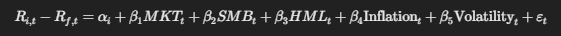

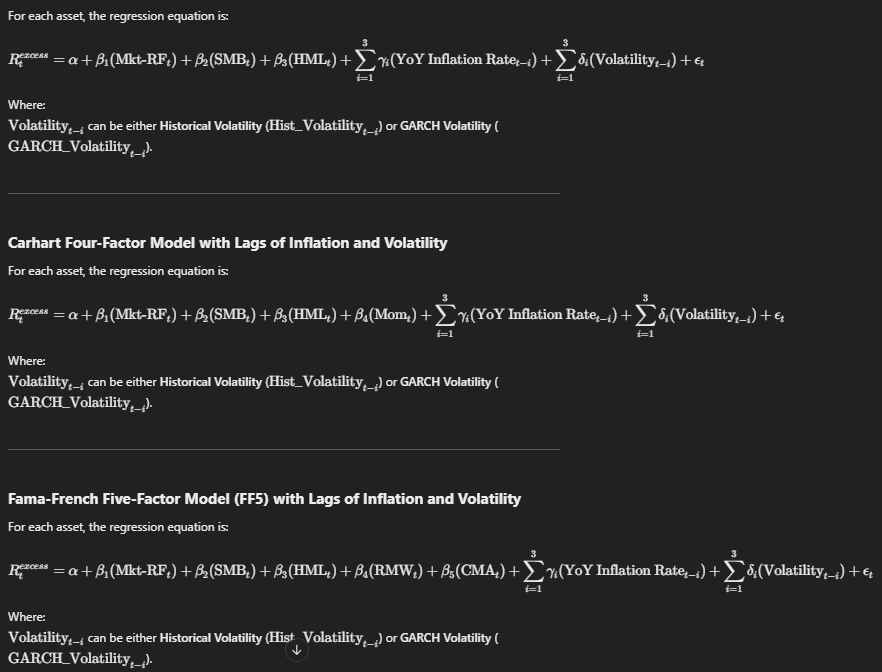

In [131]:
# Merge excess_ret_with_hist_data with ff3, carhart_merged, and ff5 on the index
excess_returns_with_factors = excess_ret_with_hist_data.merge(ff3[['Mkt-RF', 'SMB', 'HML']], left_index=True, right_index=True)
excess_returns_with_factors = excess_returns_with_factors.merge(carhart_merged[['Mom']], left_index=True, right_index=True)
excess_returns_with_factors = excess_returns_with_factors.merge(ff5[['RMW', 'CMA']], left_index=True, right_index=True)

# Display the first few rows to verify the merge
excess_returns_with_factors.head()

SP500  Russell 2000    NASDAQ  FTSE   DAX  STOXX  Nikkei  \
Date                                                                      
1980-01-31  0.055665      0.078574      <NA>  <NA>  <NA>   <NA>     NaN   
1980-02-29 -0.004829     -0.021805      <NA>  <NA>  <NA>   <NA>     NaN   
1980-03-31 -0.107927      -0.20514      <NA>  <NA>  <NA>   <NA>     NaN   
1980-04-30  0.039726      0.057958  0.065777  <NA>  <NA>   <NA>     NaN   
1980-05-31  0.045139      0.076297   0.07168  <NA>  <NA>   <NA>     NaN   

                Gold   Oil  10 Year Treasury Note  ...  GARCH_Volatility Lag4  \
Date                                               ...                          
1980-01-31  0.242893  <NA>              -0.038557  ...                    NaN   
1980-02-29 -0.025247  <NA>              -0.052267  ...                    NaN   
1980-03-31 -0.252782  <NA>               0.046642  ...                    NaN   
1980-04-30  0.044827  <NA>               0.080414  ...                    NaN   
1980-05-31  0.032846  <NA>               0.037380  ...               0.141648   

            YoY Inflation Rate Lag5  Hist_Volatility Lag5  \
Date                                                        
1980-01-31                      NaN                   NaN   
1980-02-29                      NaN                   NaN   
1980-03-31                      NaN                   NaN   
1980-04-30                      NaN                   NaN   
1980-05-31                      NaN                   NaN   

            GARCH_Volatility Lag5  Mkt-RF     SMB     HML     Mom     RMW  \
Date                                                                        
1980-01-31                    NaN -0.0072  0.0053  0.0017  0.0001  0.0003   
1980-02-29                    NaN  0.0097 -0.0067 -0.0010 -0.0017 -0.0026   
1980-03-31                    NaN  0.0146  0.0012 -0.0016  0.0081 -0.0027   
1980-04-30                    NaN  0.0029 -0.0004  0.0019 -0.0034  0.0001   
1980-05-31                    NaN  0.0070 -0.0046  0.0002  0.0022 -0.0002   

               CMA  
Date                
1980-01-31  0.0010  
1980-02-29 -0.0018  
1980-03-31 -0.0009  
1980-04-30  0.0016  
1980-05-31 -0.0009  

[5 rows x 39 columns]

In [132]:
# List of independent variables for each model
ff3_vars = ['Mkt-RF', 'SMB', 'HML']
carhart_vars = ff3_vars + ['Mom']
ff5_vars = ff3_vars + ['RMW', 'CMA']

# Store results in a DataFrame for display
factor_model_results_summary = []

# Run regressions for each asset
for asset in assets:
    y = excess_returns_with_factors[asset].dropna()
    y_index = y.index

    # Regression with FF3 model including lags of inflation and historical volatility
    X = excess_returns_with_factors[
        ff3_vars +
        [f'YoY Inflation Rate Lag{i}' for i in range(1, 6)] +
        [f'Hist_Volatility Lag{i}' for i in range(1, 6)]
    ].loc[y_index]
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop').fit()
    for coef_name, coef, tstat, pval in zip(model.params.index, model.params, model.tvalues, model.pvalues):
        factor_model_results_summary.append([asset, "FF3 + Hist_Volatility (5 lags)", coef_name, coef, tstat, pval, model.rsquared, significance_stars(pval)])

    # Regression with FF3 model including lags of inflation and GARCH volatility
    X = excess_returns_with_factors[
        ff3_vars +
        [f'YoY Inflation Rate Lag{i}' for i in range(1, 6)] +
        [f'GARCH_Volatility Lag{i}' for i in range(1, 6)]
    ].loc[y_index]
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop').fit()
    for coef_name, coef, tstat, pval in zip(model.params.index, model.params, model.tvalues, model.pvalues):
        factor_model_results_summary.append([asset, "FF3 + GARCH_Volatility (5 lags)", coef_name, coef, tstat, pval, model.rsquared, significance_stars(pval)])

    # Regression with Carhart model including lags of inflation and historical volatility
    X = excess_returns_with_factors[
        carhart_vars +
        [f'YoY Inflation Rate Lag{i}' for i in range(1, 6)] +
        [f'Hist_Volatility Lag{i}' for i in range(1, 6)]
    ].loc[y_index]
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop').fit()
    for coef_name, coef, tstat, pval in zip(model.params.index, model.params, model.tvalues, model.pvalues):
        factor_model_results_summary.append([asset, "Carhart + Hist_Volatility (5 lags)", coef_name, coef, tstat, pval, model.rsquared, significance_stars(pval)])

    # Regression with Carhart model including lags of inflation and GARCH volatility
    X = excess_returns_with_factors[
        carhart_vars +
        [f'YoY Inflation Rate Lag{i}' for i in range(1, 6)] +
        [f'GARCH_Volatility Lag{i}' for i in range(1, 6)]
    ].loc[y_index]
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop').fit()
    for coef_name, coef, tstat, pval in zip(model.params.index, model.params, model.tvalues, model.pvalues):
        factor_model_results_summary.append([asset, "Carhart + GARCH_Volatility (5 lags)", coef_name, coef, tstat, pval, model.rsquared, significance_stars(pval)])

    # Regression with FF5 model including lags of inflation and historical volatility
    X = excess_returns_with_factors[
        ff5_vars +
        [f'YoY Inflation Rate Lag{i}' for i in range(1, 6)] +
        [f'Hist_Volatility Lag{i}' for i in range(1, 6)]
    ].loc[y_index]
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop').fit()
    for coef_name, coef, tstat, pval in zip(model.params.index, model.params, model.tvalues, model.pvalues):
        factor_model_results_summary.append([asset, "FF5 + Hist_Volatility (5 lags)", coef_name, coef, tstat, pval, model.rsquared, significance_stars(pval)])

    # Regression with FF5 model including lags of inflation and GARCH volatility
    X = excess_returns_with_factors[
        ff5_vars +
        [f'YoY Inflation Rate Lag{i}' for i in range(1, 6)] +
        [f'GARCH_Volatility Lag{i}' for i in range(1, 6)]
    ].loc[y_index]
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop').fit()
    for coef_name, coef, tstat, pval in zip(model.params.index, model.params, model.tvalues, model.pvalues):
        factor_model_results_summary.append([asset, "FF5 + GARCH_Volatility (5 lags)", coef_name, coef, tstat, pval, model.rsquared, significance_stars(pval)])

# Convert to DataFrame for easy viewing
factor_model_results_df = pd.DataFrame(
    factor_model_results_summary,
    columns=['Asset', 'Regression Model', 'Variable', 'Coefficient', 'T-Statistic', 'p-value', 'R-squared', 'Significance']
)

# Display results
print(factor_model_results_df)

        Asset                 Regression Model                 Variable  \
0       SP500   FF3 + Hist_Volatility (5 lags)                    const   
1       SP500   FF3 + Hist_Volatility (5 lags)                   Mkt-RF   
2       SP500   FF3 + Hist_Volatility (5 lags)                      SMB   
3       SP500   FF3 + Hist_Volatility (5 lags)                      HML   
4       SP500   FF3 + Hist_Volatility (5 lags)  YoY Inflation Rate Lag1   
...       ...                              ...                      ...   
1345  CHF/USD  FF5 + GARCH_Volatility (5 lags)    GARCH_Volatility Lag1   
1346  CHF/USD  FF5 + GARCH_Volatility (5 lags)    GARCH_Volatility Lag2   
1347  CHF/USD  FF5 + GARCH_Volatility (5 lags)    GARCH_Volatility Lag3   
1348  CHF/USD  FF5 + GARCH_Volatility (5 lags)    GARCH_Volatility Lag4   
1349  CHF/USD  FF5 + GARCH_Volatility (5 lags)    GARCH_Volatility Lag5   

      Coefficient  T-Statistic   p-value  R-squared Significance  
0        0.007450     1.209049  

In [133]:
def significance_stars(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.1:
        return "*"
    else:
        return ""

def build_factor_model_summary(factor_model_results_df, assets, regression_model, factor_vars, infl_var, vol_var, filename):
    summary_rows = []
    for asset in assets:
        df = factor_model_results_df[
            (factor_model_results_df['Asset'] == asset) &
            (factor_model_results_df['Regression Model'] == regression_model)
        ]
        def get_coef_info(var):
            row = df[df['Variable'] == var]
            if not row.empty:
                coef = row['Coefficient'].values[0]
                pval = row['p-value'].values[0]
                stars = row['Significance'].values[0]
                return f"{coef:.4f}{stars}\n({pval:.3f})"
            else:
                return np.nan

        alpha = get_coef_info('const')
        factor_betas = [get_coef_info(f) for f in factor_vars]
        infl_betas = [get_coef_info(f'{infl_var} Lag{i}') for i in range(1, 6)]
        vol_betas = [get_coef_info(f'{vol_var} Lag{i}') for i in range(1, 6)]

        sum_infl = sum([
            df[df['Variable'] == f'{infl_var} Lag{i}']['Coefficient'].values[0]
            for i in range(1, 6) if not df[df['Variable'] == f'{infl_var} Lag{i}'].empty
        ])
        sum_vol = sum([
            df[df['Variable'] == f'{vol_var} Lag{i}']['Coefficient'].values[0]
            for i in range(1, 6) if not df[df['Variable'] == f'{vol_var} Lag{i}'].empty
        ])
        r2 = df['R-squared'].values[0] if not df.empty else np.nan

        # Extra stats
        from statsmodels.stats.stattools import durbin_watson
        try:
            y = excess_returns_with_factors[asset].dropna()
            y_index = y.index
            X = excess_returns_with_factors[
                factor_vars +
                [f'{infl_var} Lag{i}' for i in range(1, 6)] +
                [f'{vol_var} Lag{i}' for i in range(1, 6)]
            ].loc[y_index]
            X = sm.add_constant(X)
            model = sm.OLS(y, X, missing='drop').fit()
            n_obs = int(model.nobs)
            rmse = np.sqrt(model.mse_resid)
            std_err = model.bse[0] if 'const' in model.bse else np.nan
            dw_stat = durbin_watson(model.resid)
        except Exception:
            n_obs = np.nan
            rmse = np.nan
            std_err = np.nan
            dw_stat = np.nan

        summary_rows.append(
            [asset, alpha] +
            factor_betas +
            infl_betas + [f"{sum_infl:.4f}"] +
            vol_betas + [f"{sum_vol:.4f}"] +
            [f"{r2:.3f}", n_obs, f"{rmse:.4f}", f"{std_err:.4f}", f"{dw_stat:.3f}"]
        )

    columns = (
        ['Asset', 'alpha'] +
        [f'{f} beta' for f in factor_vars] +
        [f'inflation beta {i}' for i in range(1, 6)] +
        ['sum of inflation coefficients'] +
        [f'vol beta {i}' for i in range(1, 6)] +
        ['sum of volatility coefficients', 'r-squared',
         'n_obs', 'RMSE', 'StdErr_const', 'DurbinWatson']
    )
    summary_table = pd.DataFrame(summary_rows, columns=columns)
    summary_table.to_excel(filename, index=False)
    print(f"Saved summary table to {filename}")
    return summary_table

assets_list = assets  # already defined

# FF3 + Hist_Volatility (5 lags)
build_factor_model_summary(
    factor_model_results_df, assets_list,
    "FF3 + Hist_Volatility (5 lags)",
    ['Mkt-RF', 'SMB', 'HML'],
    "YoY Inflation Rate", "Hist_Volatility",
    "factor_model_summary_ff3_hist.xlsx"
)

# FF3 + GARCH_Volatility (5 lags)
build_factor_model_summary(
    factor_model_results_df, assets_list,
    "FF3 + GARCH_Volatility (5 lags)",
    ['Mkt-RF', 'SMB', 'HML'],
    "YoY Inflation Rate", "GARCH_Volatility",
    "factor_model_summary_ff3_garch.xlsx"
)

# Carhart + Hist_Volatility (5 lags)
build_factor_model_summary(
    factor_model_results_df, assets_list,
    "Carhart + Hist_Volatility (5 lags)",
    ['Mkt-RF', 'SMB', 'HML', 'Mom'],
    "YoY Inflation Rate", "Hist_Volatility",
    "factor_model_summary_carhart_hist.xlsx"
)

# Carhart + GARCH_Volatility (5 lags)
build_factor_model_summary(
    factor_model_results_df, assets_list,
    "Carhart + GARCH_Volatility (5 lags)",
    ['Mkt-RF', 'SMB', 'HML', 'Mom'],
    "YoY Inflation Rate", "GARCH_Volatility",
    "factor_model_summary_carhart_garch.xlsx"
)

# FF5 + Hist_Volatility (5 lags)
build_factor_model_summary(
    factor_model_results_df, assets_list,
    "FF5 + Hist_Volatility (5 lags)",
    ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'],
    "YoY Inflation Rate", "Hist_Volatility",
    "factor_model_summary_ff5_hist.xlsx"
)

# FF5 + GARCH_Volatility (5 lags)
build_factor_model_summary(
    factor_model_results_df, assets_list,
    "FF5 + GARCH_Volatility (5 lags)",
    ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'],
    "YoY Inflation Rate", "GARCH_Volatility",
    "factor_model_summary_ff5_garch.xlsx"
)

C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Saved summary table to factor_model_summary_ff3_hist.xlsx


C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Saved summary table to factor_model_summary_ff3_garch.xlsx


C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Saved summary table to factor_model_summary_carhart_hist.xlsx


C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Saved summary table to factor_model_summary_carhart_garch.xlsx


C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Saved summary table to factor_model_summary_ff5_hist.xlsx


C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std_err = model.bse[0] if 'const' in model.bse else np.nan
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2404573270.py:57: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position

Saved summary table to factor_model_summary_ff5_garch.xlsx


Asset              alpha          Mkt-RF beta  \
0                   SP500    0.0008\n(0.933)     0.4133*\n(0.057)   
1            Russell 2000   -0.0142\n(0.283)      0.3923\n(0.172)   
2                  NASDAQ   -0.0038\n(0.785)      0.1693\n(0.577)   
3                    FTSE   -0.0012\n(0.912)     -0.1313\n(0.559)   
4                     DAX    0.0138\n(0.336)      0.3428\n(0.279)   
5                   STOXX    0.0085\n(0.510)      0.1365\n(0.618)   
6                  Nikkei    0.0033\n(0.816)     -0.2930\n(0.327)   
7                    Gold    0.0013\n(0.907)      0.2318\n(0.318)   
8                     Oil   -0.0032\n(0.898)     -0.0960\n(0.856)   
9   10 Year Treasury Note  0.0115**\n(0.026)   0.4170***\n(0.000)   
10               TIPS ETF   -0.0021\n(0.667)   0.3152***\n(0.007)   
11                Na REIT   -0.0112\n(0.322)    0.5027**\n(0.040)   
12                EUR/USD   -0.0024\n(0.709)  -0.3677***\n(0.010)   
13                JPY/USD   -0.0024\n(0.743)   0.4375***\n(0.005)   
14                CHF/USD    0.0028\n(0.702)     0.2874*\n(0.068)   

              SMB beta             HML beta            RMW beta  \
0   -0.7541**\n(0.015)  -1.0221***\n(0.005)    -0.0283\n(0.954)   
1     -0.2290\n(0.577)    -0.8611*\n(0.073)    -0.3624\n(0.579)   
2     -0.2097\n(0.629)  -1.3170***\n(0.010)     0.1618\n(0.815)   
3     -0.3255\n(0.306)     -0.5552\n(0.135)    -0.7467\n(0.142)   
4     -0.5093\n(0.247)  -1.3133***\n(0.009)  -1.4169**\n(0.039)   
5    -0.6466*\n(0.094)   -0.9089**\n(0.044)  -1.4122**\n(0.023)   
6   -0.9316**\n(0.028)  -1.3729***\n(0.006)    -0.6619\n(0.328)   
7     -0.4921\n(0.139)     -0.3283\n(0.398)     0.1662\n(0.753)   
8    -1.3373*\n(0.076)   -2.1869**\n(0.013)    -1.5021\n(0.213)   
9      0.2008\n(0.207)      0.2656\n(0.153)   0.6092**\n(0.016)   
10    -0.1708\n(0.356)   -0.3880**\n(0.021)     0.4477\n(0.107)   
11    -0.4120\n(0.239)   -0.9716**\n(0.018)     0.0339\n(0.951)   
12    -0.2017\n(0.320)      0.0394\n(0.868)  -0.6716**\n(0.038)   
13    -0.1683\n(0.450)      0.3804\n(0.144)     0.2144\n(0.545)   
14     0.1250\n(0.578)      0.1482\n(0.573)    0.6228*\n(0.082)   

             CMA beta     inflation beta 1    inflation beta 2  \
0     0.4093\n(0.499)    -0.9124*\n(0.098)     0.8988\n(0.355)   
1     1.2013\n(0.134)   -1.5296**\n(0.036)     0.9820\n(0.445)   
2    -0.3957\n(0.641)     -1.1279\n(0.144)     0.1340\n(0.921)   
3     0.3372\n(0.589)     -0.6300\n(0.286)     0.8849\n(0.398)   
4     0.9760\n(0.256)     -1.2413\n(0.131)     0.6603\n(0.645)   
5     0.3698\n(0.631)    -1.2206*\n(0.094)     1.1214\n(0.383)   
6     1.0512\n(0.209)  -2.7100***\n(0.001)  3.9209***\n(0.005)   
7    -0.3716\n(0.567)     -0.2070\n(0.726)    -0.7487\n(0.472)   
8     0.9455\n(0.523)      0.2416\n(0.862)    -3.0131\n(0.221)   
9     0.0287\n(0.926)   -0.5868**\n(0.038)   1.1169**\n(0.025)   
10  0.6564**\n(0.049)     -0.0252\n(0.928)     0.3342\n(0.503)   
11  1.3739**\n(0.045)    -1.1975*\n(0.055)    2.0464*\n(0.062)   
12   -0.4811\n(0.225)      0.4165\n(0.248)    -0.3842\n(0.545)   
13   -0.5586\n(0.200)      0.1246\n(0.753)    -0.5755\n(0.409)   
14    0.0982\n(0.823)     -0.3432\n(0.391)     0.1782\n(0.800)   

     inflation beta 3  ...           vol beta 2           vol beta 3  \
0     0.0670\n(0.948)  ...   -0.3351**\n(0.038)      0.1325\n(0.408)   
1     0.7458\n(0.582)  ...     -0.3265\n(0.126)      0.1261\n(0.552)   
2     1.2675\n(0.376)  ...    -0.4220*\n(0.061)      0.2151\n(0.337)   
3    -0.1084\n(0.922)  ...     -0.1977\n(0.234)     -0.0350\n(0.834)   
4     0.1740\n(0.908)  ...   -0.5472**\n(0.025)      0.3495\n(0.133)   
5    -0.2330\n(0.864)  ...     -0.2863\n(0.164)      0.2031\n(0.326)   
6   -2.7818*\n(0.061)  ...     -0.1526\n(0.496)     -0.1411\n(0.531)   
7   2.7926**\n(0.011)  ...      0.1679\n(0.330)     -0.1851\n(0.281)   
8    4.3181*\n(0.098)  ...     -0.3077\n(0.435)      0.0583\n(0.883)   
9    -0.8438\n(0.108)  ...     -0.1357\n(0.100)     -0.0662\n(0.4

## 4. Regressions with unexpected inflation 

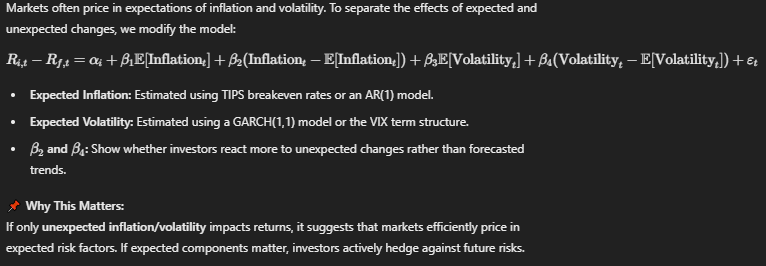

In [134]:
# Calculate unexpected components
unexpected_expected_variables = pd.merge(
    excess_ret_with_hist_data,
    excess_ret_with_expected_data[['UMich Expected Inflation Rate', 'Monthly Expected Volatility']],
    left_index=True,
    right_index=True
)
unexpected_expected_variables['Unexpected Inflation'] = excess_ret_with_hist_data['YoY Inflation Rate'] - excess_ret_with_expected_data['UMich Expected Inflation Rate']
unexpected_expected_variables['Unexpected Hist_Volatility'] = excess_ret_with_hist_data['Hist_Volatility'] - excess_ret_with_expected_data['Monthly Expected Volatility']
unexpected_expected_variables['Unexpected GARCH_Volatility'] = excess_ret_with_hist_data['GARCH_Volatility'] - excess_ret_with_expected_data['Monthly Expected Volatility']

# Add expected components to the new DataFrame
unexpected_expected_variables['UMich Expected Inflation Rate'] = excess_ret_with_expected_data['UMich Expected Inflation Rate']
unexpected_expected_variables['Monthly Expected Volatility'] = excess_ret_with_expected_data['Monthly Expected Volatility']



In [135]:
unexpected_expected_variables.head()

SP500  Russell 2000    NASDAQ      FTSE       DAX     STOXX  \
1990-01-31 -0.071560     -0.093932 -0.089933 -0.036146  0.023684 -0.026613   
1990-02-28  0.008203      0.028385  0.023512 -0.035969 -0.008338 -0.020132   
1990-03-31  0.023676      0.036558  0.022256 -0.003621  0.084629  0.061163   
1990-04-30 -0.027595     -0.034844 -0.036505 -0.066781 -0.081789 -0.025258   
1990-05-31  0.087691      0.065892  0.088253  0.108463  0.012722  0.025898   

              Nikkei      Gold       Oil  10 Year Treasury Note  ...  \
1990-01-31 -0.045650  0.020987  0.038396              -0.024972  ...   
1990-02-28 -0.072690 -0.012404 -0.051872              -0.002376  ...   
1990-03-31 -0.143367 -0.093831 -0.060566              -0.001994  ...   
1990-04-30 -0.013625 -0.004536 -0.090045              -0.017889  ...   
1990-05-31  0.112893 -0.013828  -0.06377               0.031990  ...   

            Hist_Volatility Lag4  GARCH_Volatility Lag4  \
1990-01-31              0.134361               0.164346   
1990-02-28              0.134068               0.153294   
1990-03-31              0.135108               0.152726   
1990-04-30              0.136605               0.147186   
1990-05-31              0.146724               0.140504   

            YoY Inflation Rate Lag5  Hist_Volatility Lag5  \
1990-01-31                 0.046218              0.136017   
1990-02-28                 0.044351              0.134361   
1990-03-31                 0.045872              0.134068   
1990-04-30                 0.046550              0.135108   
1990-05-31                 0.046396              0.136605   

            GARCH_Volatility Lag5  UMich Expected Inflation Rate  \
1990-01-31               0.173222                          0.041   
1990-02-28               0.164346                          0.041   
1990-03-31               0.153294                          0.037   
1990-04-30               0.152726                          0.036   
1990-05-31               0.147186                          0.034   

            Monthly Expected Volatility  Unexpected Inflation  \
1990-01-31                     0.072634              0.010980   
1990-02-28                     0.062982              0.011632   
1990-03-31                     0.056509              0.015373   
1990-04-30                     0.055907              0.011116   
1990-05-31                     0.049750              0.009654   

            Unexpected Hist_Volatility  Unexpected GARCH_Volatility  
1990-01-31                    0.074090                     0.067870  
1990-02-28                    0.091833                     0.088129  
1990-03-31                    0.111632                     0.099830  
1990-04-30                    0.110454                     0.115985  
1990-05-31                    0.144674                     0.110693  

[5 rows x 38 columns]

In [136]:
# Copy the assets' excess returns
for asset in assets:
    unexpected_expected_variables[asset] = excess_ret_with_hist_data[asset]

In [137]:
# Function to format p-values with stars
def significance_stars(p):
    if p < 0.01:
        return "***"  # Highly significant
    elif p < 0.05:
        return "**"   # Moderately significant
    elif p < 0.1:
        return "*"    # Weakly significant
    else:
        return ""     # Not significant

# Store results in a DataFrame for display
unexpected_regressions_summary = []

# Run regressions for each asset
for asset in assets:
    y = unexpected_expected_variables[asset].dropna()
    
    # Ensure the index is properly aligned
    y_index = y.index
    
    # Regression with expected and unexpected components (Historical Volatility)
    X = unexpected_expected_variables[['UMich Expected Inflation Rate', 'Unexpected Inflation', 'Monthly Expected Volatility', 'Unexpected Hist_Volatility']].loc[y_index]
    X = sm.add_constant(X)  # Add intercept
    model = sm.OLS(y, X, missing='drop').fit()
    
    # Store results
    for coef_name, coef, tstat, pval in zip(model.params.index, model.params, model.tvalues, model.pvalues):
        unexpected_regressions_summary.append([asset, "Expected and Unexpected Inflation and Hist_Volatility", coef_name, coef, tstat, pval, model.rsquared, significance_stars(pval)])
    
    # Regression with expected and unexpected components (GARCH Volatility)
    X = unexpected_expected_variables[['UMich Expected Inflation Rate', 'Unexpected Inflation', 'Monthly Expected Volatility', 'Unexpected GARCH_Volatility']].loc[y_index]
    X = sm.add_constant(X)  # Add intercept
    model = sm.OLS(y, X, missing='drop').fit()
    
    # Store results
    for coef_name, coef, tstat, pval in zip(model.params.index, model.params, model.tvalues, model.pvalues):
        unexpected_regressions_summary.append([asset, "Expected and Unexpected Inflation and GARCH_Volatility", coef_name, coef, tstat, pval, model.rsquared, significance_stars(pval)])

# Convert to DataFrame for easy viewing
unexpected_regressions_df = pd.DataFrame(unexpected_regressions_summary, columns=['Asset', 'Regression Model', 'Variable', 'Coefficient', 'T-Statistic', 'p-value', 'R-squared', 'Significance'])

# Display results
print(unexpected_regressions_df)


       Asset                                   Regression Model  \
0      SP500  Expected and Unexpected Inflation and Hist_Vol...   
1      SP500  Expected and Unexpected Inflation and Hist_Vol...   
2      SP500  Expected and Unexpected Inflation and Hist_Vol...   
3      SP500  Expected and Unexpected Inflation and Hist_Vol...   
4      SP500  Expected and Unexpected Inflation and Hist_Vol...   
..       ...                                                ...   
145  CHF/USD  Expected and Unexpected Inflation and GARCH_Vo...   
146  CHF/USD  Expected and Unexpected Inflation and GARCH_Vo...   
147  CHF/USD  Expected and Unexpected Inflation and GARCH_Vo...   
148  CHF/USD  Expected and Unexpected Inflation and GARCH_Vo...   
149  CHF/USD  Expected and Unexpected Inflation and GARCH_Vo...   

                          Variable  Coefficient  T-Statistic       p-value  \
0                            const     0.056005     5.205143  3.055405e-07   
1    UMich Expected Inflation Rate    -

### Regression with unexpected and expected data

In [138]:
from statsmodels.stats.stattools import durbin_watson

def significance_stars(p):
    if p < 0.01:
        return "***"
    elif p < 0.05:
        return "**"
    elif p < 0.1:
        return "*"
    else:
        return ""

summary_rows = []
for asset in assets:
    y = unexpected_expected_variables[asset].dropna()
    idx = y.index

    # Hist Volatility regression
    X_hist = unexpected_expected_variables.loc[idx, [
        'UMich Expected Inflation Rate', 'Unexpected Inflation',
        'Monthly Expected Volatility', 'Unexpected Hist_Volatility'
    ]]
    X_hist = sm.add_constant(X_hist)
    model_hist = sm.OLS(y, X_hist, missing='drop').fit()
    rmse_hist = np.sqrt(model_hist.mse_resid)
    stderr_const_hist = model_hist.bse['const'] if 'const' in model_hist.bse else np.nan
    dw_hist = durbin_watson(model_hist.resid)
    summary_rows.append({
        'Asset': asset,
        'Model': 'Hist',
        'alpha': f"{model_hist.params['const']:.4f}{significance_stars(model_hist.pvalues['const'])}\n({model_hist.pvalues['const']:.3f})",
        'beta_exp_infl': f"{model_hist.params['UMich Expected Inflation Rate']:.4f}{significance_stars(model_hist.pvalues['UMich Expected Inflation Rate'])}\n({model_hist.pvalues['UMich Expected Inflation Rate']:.3f})",
        'beta_unexp_infl': f"{model_hist.params['Unexpected Inflation']:.4f}{significance_stars(model_hist.pvalues['Unexpected Inflation'])}\n({model_hist.pvalues['Unexpected Inflation']:.3f})",
        'beta_exp_vol': f"{model_hist.params['Monthly Expected Volatility']:.4f}{significance_stars(model_hist.pvalues['Monthly Expected Volatility'])}\n({model_hist.pvalues['Monthly Expected Volatility']:.3f})",
        'beta_unexp_vol': f"{model_hist.params['Unexpected Hist_Volatility']:.4f}{significance_stars(model_hist.pvalues['Unexpected Hist_Volatility'])}\n({model_hist.pvalues['Unexpected Hist_Volatility']:.3f})",
        'R2': f"{model_hist.rsquared:.3f}",
        'N': int(model_hist.nobs),
        'RMSE': f"{rmse_hist:.4f}",
        'StdErr_const': f"{stderr_const_hist:.4f}",
        'DurbinWatson': f"{dw_hist:.3f}"
    })

    # GARCH Volatility regression
    X_garch = unexpected_expected_variables.loc[idx, [
        'UMich Expected Inflation Rate', 'Unexpected Inflation',
        'Monthly Expected Volatility', 'Unexpected GARCH_Volatility'
    ]]
    X_garch = sm.add_constant(X_garch)
    model_garch = sm.OLS(y, X_garch, missing='drop').fit()
    rmse_garch = np.sqrt(model_garch.mse_resid)
    stderr_const_garch = model_garch.bse['const'] if 'const' in model_garch.bse else np.nan
    dw_garch = durbin_watson(model_garch.resid)
    summary_rows.append({
        'Asset': asset,
        'Model': 'GARCH',
        'alpha': f"{model_garch.params['const']:.4f}{significance_stars(model_garch.pvalues['const'])}\n({model_garch.pvalues['const']:.3f})",
        'beta_exp_infl': f"{model_garch.params['UMich Expected Inflation Rate']:.4f}{significance_stars(model_garch.pvalues['UMich Expected Inflation Rate'])}\n({model_garch.pvalues['UMich Expected Inflation Rate']:.3f})",
        'beta_unexp_infl': f"{model_garch.params['Unexpected Inflation']:.4f}{significance_stars(model_garch.pvalues['Unexpected Inflation'])}\n({model_garch.pvalues['Unexpected Inflation']:.3f})",
        'beta_exp_vol': f"{model_garch.params['Monthly Expected Volatility']:.4f}{significance_stars(model_garch.pvalues['Monthly Expected Volatility'])}\n({model_garch.pvalues['Monthly Expected Volatility']:.3f})",
        'beta_unexp_vol': f"{model_garch.params['Unexpected GARCH_Volatility']:.4f}{significance_stars(model_garch.pvalues['Unexpected GARCH_Volatility'])}\n({model_garch.pvalues['Unexpected GARCH_Volatility']:.3f})",
        'R2': f"{model_garch.rsquared:.3f}",
        'N': int(model_garch.nobs),
        'RMSE': f"{rmse_garch:.4f}",
        'StdErr_const': f"{stderr_const_garch:.4f}",
        'DurbinWatson': f"{dw_garch:.3f}"
    })

# Convert to DataFrame and save
summary_df = pd.DataFrame(summary_rows)
print(summary_df)
summary_df.to_excel("unexpected_expected_regression_summary.xlsx", index=False)
print("Saved to unexpected_expected_regression_summary.xlsx")

                    Asset  Model               alpha        beta_exp_infl  \
0                   SP500   Hist  0.0560***\n(0.000)   -0.6296**\n(0.036)   
1                   SP500  GARCH     0.0130\n(0.243)   -0.6024**\n(0.033)   
2            Russell 2000   Hist  0.0762***\n(0.000)  -1.1593***\n(0.004)   
3            Russell 2000  GARCH     0.0215\n(0.160)  -1.1089***\n(0.004)   
4                  NASDAQ   Hist  0.0809***\n(0.000)  -1.2753***\n(0.006)   
5                  NASDAQ  GARCH     0.0252\n(0.149)  -1.2476***\n(0.005)   
6                    FTSE   Hist  0.0457***\n(0.000)   -0.5743**\n(0.047)   
7                    FTSE  GARCH     0.0111\n(0.309)   -0.5473**\n(0.048)   
8                     DAX   Hist  0.0690***\n(0.000)    -0.7240*\n(0.096)   
9                     DAX  GARCH     0.0236\n(0.155)    -0.7103*\n(0.090)   
10                  STOXX   Hist  0.0625***\n(0.000)    -0.7287*\n(0.056)   
11                  STOXX  GARCH     0.0199\n(0.169)    -0.7097*\n(0.052)   

#### Store Inflation and Volatility Betas 

Which Model?

###### 1 - Betas Expected / Unexpected 

In [139]:
# Extract only the beta coefficients (not alpha/intercept) from the existing results DataFrame
betas_unexpected = unexpected_regressions_df[
    unexpected_regressions_df['Variable'].isin([
        'UMich Expected Inflation Rate',
        'Unexpected Inflation',
        'Monthly Expected Volatility',
        'Unexpected Hist_Volatility',
        'Unexpected GARCH_Volatility'
    ])
]

# Pivot to get assets and models as rows, betas as columns
betas_unexpected_pivot = betas_unexpected.pivot_table(
    index=['Asset', 'Regression Model'],
    columns='Variable',
    values='Coefficient'
)

# Round all values to 4 decimal places
betas_unexpected_pivot = betas_unexpected_pivot.round(4)

# Reset index for easier viewing and save to CSV
betas_unexpected_pivot = betas_unexpected_pivot.reset_index()
print(betas_unexpected_pivot)

# Save to CSV
betas_unexpected_pivot.to_csv("betas_expected_unexpected_models.csv", index=False)
print("Saved betas to betas_expected_unexpected_models.csv")

Variable                  Asset  \
0         10 Year Treasury Note   
1         10 Year Treasury Note   
2                       CHF/USD   
3                       CHF/USD   
4                           DAX   
5                           DAX   
6                       EUR/USD   
7                       EUR/USD   
8                          FTSE   
9                          FTSE   
10                         Gold   
11                         Gold   
12                      JPY/USD   
13                      JPY/USD   
14                       NASDAQ   
15                       NASDAQ   
16                      Na REIT   
17                      Na REIT   
18                       Nikkei   
19                       Nikkei   
20                          Oil   
21                          Oil   
22                 Russell 2000   
23                 Russell 2000   
24                        SP500   
25                        SP500   
26                        STOXX   
27                  

###### 2- Betas Lagged Regressions

In [140]:

# --- Store only betas (not intercepts) for each asset/model, no regressions rerun ---

def extract_lagged_betas(multi_results_df, assets, regression_model, infl_var, vol_var, num_lags=5, filename=None):
    """
    Extract only the lagged inflation and volatility betas for each asset and model.
    """
    rows = []
    for asset in assets:
        df = multi_results_df[
            (multi_results_df['Asset'] == asset) &
            (multi_results_df['Regression Model'] == regression_model)
        ]
        # Collect lagged inflation betas
        infl_betas = []
        for i in range(1, num_lags+1):
            row = df[df['Variable'] == f'{infl_var} Lag{i}']
            if not row.empty:
                infl_betas.append(row['Coefficient'].values[0])
            else:
                infl_betas.append(np.nan)
        # Collect lagged volatility betas
        vol_betas = []
        for i in range(1, num_lags+1):
            row = df[df['Variable'] == f'{vol_var} Lag{i}']
            if not row.empty:
                vol_betas.append(row['Coefficient'].values[0])
            else:
                vol_betas.append(np.nan)
        # Sums
        sum_infl = np.nansum(infl_betas)
        sum_vol = np.nansum(vol_betas)
        rows.append(
            [asset] +
            [round(b, 4) if not pd.isnull(b) else np.nan for b in infl_betas] + [round(sum_infl, 4)] +
            [round(b, 4) if not pd.isnull(b) else np.nan for b in vol_betas] + [round(sum_vol, 4)]
        )
    columns = (
        ['Asset'] +
        [f'inflation beta {i}' for i in range(1, num_lags+1)] +
        ['sum of inflation coefficients'] +
        [f'vol beta {i}' for i in range(1, num_lags+1)] +
        ['sum of volatility coefficients']
    )
    betas_table = pd.DataFrame(rows, columns=columns)
    if filename:
        betas_table.to_csv(filename, index=False)
        print(f"Saved betas only to {filename}")
    return betas_table

# Usage for both models:
assets_list = assets  # already defined in your code

# Hist_Volatility betas only
hist_betas_table = extract_lagged_betas(
    multi_results_df, assets_list,
    "Inflation + Hist_Volatility (5 lags)",
    "YoY Inflation Rate", "Hist_Volatility",
    num_lags=5,
    filename="betas_only_hist_vol.csv"
)

# GARCH_Volatility betas only
garch_betas_table = extract_lagged_betas(
    multi_results_df, assets_list,
    "Inflation + GARCH_Volatility (5 lags)",
    "YoY Inflation Rate", "GARCH_Volatility",
    num_lags=5,
    filename="betas_only_garch_vol.csv"
)

print(hist_betas_table.head())
print(garch_betas_table.head())


Saved betas only to betas_only_hist_vol.csv
Saved betas only to betas_only_garch_vol.csv
          Asset  inflation beta 1  inflation beta 2  inflation beta 3  \
0         SP500           -1.0056            1.1557           -0.2525   
1  Russell 2000           -1.7009            1.4135            0.3521   
2        NASDAQ           -1.2504            0.3376            0.7153   
3          FTSE           -0.6562            0.9537           -0.2217   
4           DAX           -1.4215            1.1889           -0.3451   

   inflation beta 4  inflation beta 5  sum of inflation coefficients  \
0           -0.3499            0.3107                        -0.1415   
1           -0.3908            0.2118                        -0.1143   
2           -0.5576            0.5766                        -0.1785   
3           -0.5933            0.4036                        -0.1140   
4           -0.2534            0.6505                        -0.1806   

   vol beta 1  vol beta 2  vol beta 3  

###### 3- Betas Lagged + Factors Regressions

In [141]:
# ...existing code...

def extract_factor_model_betas(factor_model_results_df, assets, regression_model, factor_vars, infl_var, vol_var, num_lags=5, filename=None):
    """
    Extract only the factor, inflation, and volatility betas for each asset and model.
    """
    rows = []
    for asset in assets:
        df = factor_model_results_df[
            (factor_model_results_df['Asset'] == asset) &
            (factor_model_results_df['Regression Model'] == regression_model)
        ]
        # Factor betas
        factor_betas = []
        for f in factor_vars:
            row = df[df['Variable'] == f]
            if not row.empty:
                factor_betas.append(row['Coefficient'].values[0])
            else:
                factor_betas.append(np.nan)
        # Lagged inflation betas
        infl_betas = []
        for i in range(1, num_lags+1):
            row = df[df['Variable'] == f'{infl_var} Lag{i}']
            if not row.empty:
                infl_betas.append(row['Coefficient'].values[0])
            else:
                infl_betas.append(np.nan)
        # Lagged volatility betas
        vol_betas = []
        for i in range(1, num_lags+1):
            row = df[df['Variable'] == f'{vol_var} Lag{i}']
            if not row.empty:
                vol_betas.append(row['Coefficient'].values[0])
            else:
                vol_betas.append(np.nan)
        # Sums
        sum_infl = np.nansum(infl_betas)
        sum_vol = np.nansum(vol_betas)
        rows.append(
            [asset] +
            [round(b, 4) if not pd.isnull(b) else np.nan for b in factor_betas] +
            [round(b, 4) if not pd.isnull(b) else np.nan for b in infl_betas] + [round(sum_infl, 4)] +
            [round(b, 4) if not pd.isnull(b) else np.nan for b in vol_betas] + [round(sum_vol, 4)]
        )
    columns = (
        ['Asset'] +
        [f'{f} beta' for f in factor_vars] +
        [f'inflation beta {i}' for i in range(1, num_lags+1)] +
        ['sum of inflation coefficients'] +
        [f'vol beta {i}' for i in range(1, num_lags+1)] +
        ['sum of volatility coefficients']
    )
    betas_table = pd.DataFrame(rows, columns=columns)
    if filename:
        betas_table.to_csv(filename, index=False)
        print(f"Saved factor model betas only to {filename}")
    return betas_table

assets_list = assets  # already defined

# FF3 + Hist_Volatility (5 lags)
ff3_hist_betas = extract_factor_model_betas(
    factor_model_results_df, assets_list,
    "FF3 + Hist_Volatility (5 lags)",
    ['Mkt-RF', 'SMB', 'HML'],
    "YoY Inflation Rate", "Hist_Volatility",
    num_lags=5,
    filename="betas_only_ff3_hist_vol.csv"
)

# FF3 + GARCH_Volatility (5 lags)
ff3_garch_betas = extract_factor_model_betas(
    factor_model_results_df, assets_list,
    "FF3 + GARCH_Volatility (5 lags)",
    ['Mkt-RF', 'SMB', 'HML'],
    "YoY Inflation Rate", "GARCH_Volatility",
    num_lags=5,
    filename="betas_only_ff3_garch_vol.csv"
)

# Carhart + Hist_Volatility (5 lags)
carhart_hist_betas = extract_factor_model_betas(
    factor_model_results_df, assets_list,
    "Carhart + Hist_Volatility (5 lags)",
    ['Mkt-RF', 'SMB', 'HML', 'Mom'],
    "YoY Inflation Rate", "Hist_Volatility",
    num_lags=5,
    filename="betas_only_carhart_hist_vol.csv"
)

# Carhart + GARCH_Volatility (5 lags)
carhart_garch_betas = extract_factor_model_betas(
    factor_model_results_df, assets_list,
    "Carhart + GARCH_Volatility (5 lags)",
    ['Mkt-RF', 'SMB', 'HML', 'Mom'],
    "YoY Inflation Rate", "GARCH_Volatility",
    num_lags=5,
    filename="betas_only_carhart_garch_vol.csv"
)

# FF5 + Hist_Volatility (5 lags)
ff5_hist_betas = extract_factor_model_betas(
    factor_model_results_df, assets_list,
    "FF5 + Hist_Volatility (5 lags)",
    ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'],
    "YoY Inflation Rate", "Hist_Volatility",
    num_lags=5,
    filename="betas_only_ff5_hist_vol.csv"
)

# FF5 + GARCH_Volatility (5 lags)
ff5_garch_betas = extract_factor_model_betas(
    factor_model_results_df, assets_list,
    "FF5 + GARCH_Volatility (5 lags)",
    ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA'],
    "YoY Inflation Rate", "GARCH_Volatility",
    num_lags=5,
    filename="betas_only_ff5_garch_vol.csv"
)

print(ff3_hist_betas.head())
print(ff3_garch_betas.head())
print(carhart_hist_betas.head())
print(carhart_garch_betas.head())
print(ff5_hist_betas.head())
print(ff5_garch_betas.head())
# ...existing code...

Saved factor model betas only to betas_only_ff3_hist_vol.csv
Saved factor model betas only to betas_only_ff3_garch_vol.csv
Saved factor model betas only to betas_only_carhart_hist_vol.csv
Saved factor model betas only to betas_only_carhart_garch_vol.csv
Saved factor model betas only to betas_only_ff5_hist_vol.csv
Saved factor model betas only to betas_only_ff5_garch_vol.csv
          Asset  Mkt-RF beta  SMB beta  HML beta  inflation beta 1  \
0         SP500       0.3740   -0.7471   -0.9078           -0.9946   
1  Russell 2000       0.3043   -0.1751   -0.5087           -1.6586   
2        NASDAQ       0.2510   -0.2109   -1.4000           -1.2222   
3          FTSE      -0.0737   -0.2011   -0.4248           -0.6883   
4           DAX       0.3593   -0.1901   -1.0453           -1.3739   

   inflation beta 2  inflation beta 3  inflation beta 4  inflation beta 5  \
0            1.1748           -0.2132           -0.3675            0.2471   
1            1.3486            0.4066           

# Portfolios Construction

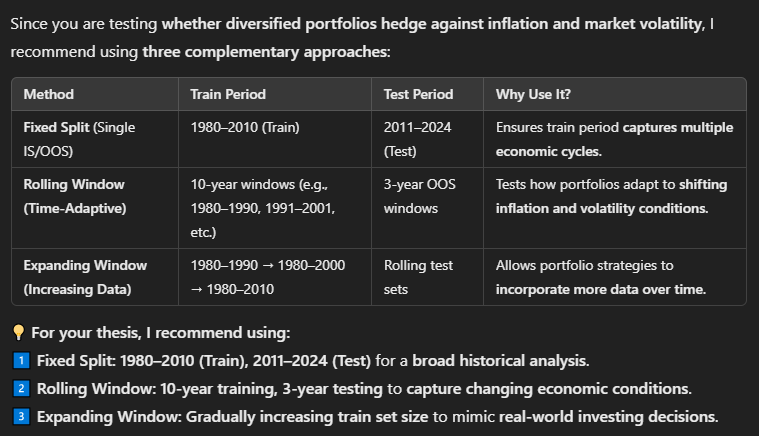

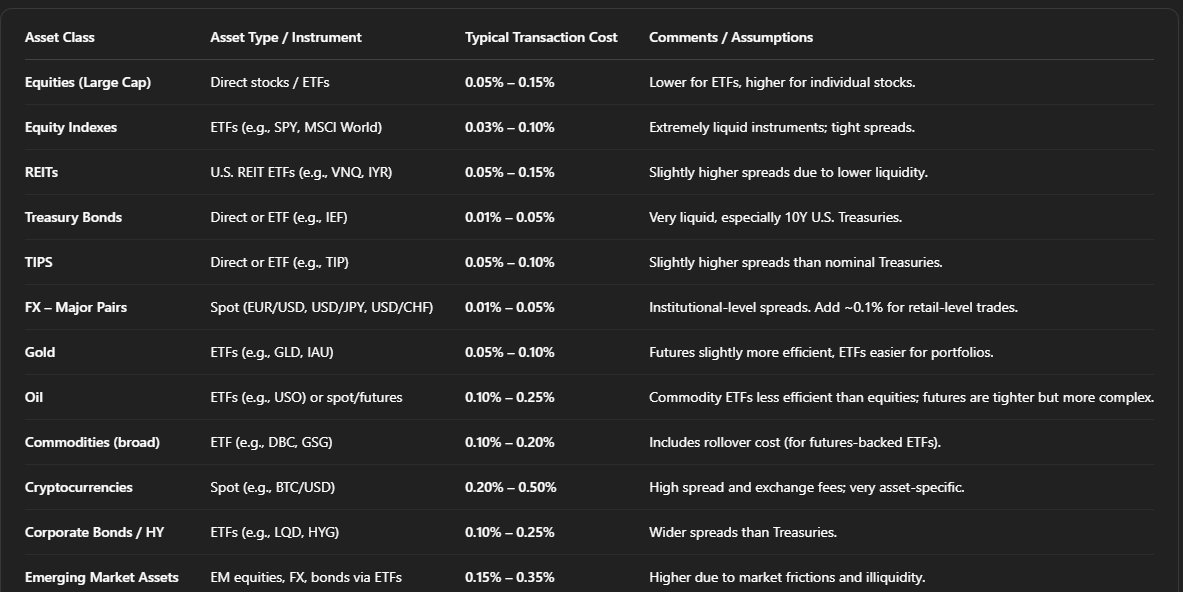 #needs some kind of proof

In [142]:
# Split the DataFrame into train (1980-2010) and test (2011-2024)
train_data = excess_returns.loc['1980-01-01':'2010-12-31']
test_data = excess_returns.loc['2011-01-01':'2024-12-31']

In [143]:
transaction_costs = {
    "Equity Indexes": 0.0005,       # 0.05%
    "REITs": 0.001,                # 0.10%
    "Treasury Bonds": 0.0003,      # 0.03%
    "TIPS": 0.00075,               # 0.075%
    "FX – Major Pairs": 0.0003,    # 0.03%
    "Gold": 0.00075,               # 0.075%
    "Oil": 0.002,                  # 0.20%
}

In [144]:
# Define asset classes for each asset
asset_classes = {
    "SP500": "Equity Indexes",
    "Russell 2000": "Equity Indexes",
    "NASDAQ": "Equity Indexes",
    "FTSE": "Equity Indexes",
    "DAX": "Equity Indexes",
    "STOXX": "Equity Indexes",
    "Nikkei": "Equity Indexes",
    "Gold": "Gold",
    "Oil": "Oil",
    "10 Year Treasury Note": "Treasury Bonds",
    "TIPS ETF": "TIPS",
    "Na REIT": "REITs",
    "EUR/USD": "FX – Major Pairs",
    "JPY/USD": "FX – Major Pairs",
    "CHF/USD": "FX – Major Pairs"
}

## 1 - Equal-Weighted Portfolio

In [145]:
# Function to calculate portfolio returns
def calculate_portfolio_returns(data, rebalance_freq='M'):
    """
    Calculate portfolio returns with transaction costs.
    
    Parameters:
        data (DataFrame): Asset returns data.
        rebalance_freq (str): Rebalancing frequency ('M' for monthly, 'Q' for quarterly).
    
    Returns:
        ew_portfolio_returns (Series): Portfolio returns over time.
    """
    # Filter assets available in the time period
    available_assets = data.dropna(axis=1, how='all').columns
    data = data[available_assets]
    
    # Initialize portfolio weights (equal weights)
    ew_weights = pd.DataFrame(index=data.index, columns=data.columns)
    ew_weights.iloc[0] = 1 / len(data.columns)  # Equal weights initially
    ew_weights.iloc[0] = ew_weights.iloc[0] / ew_weights.iloc[0].sum()  # Normalize to ensure weights sum to 1
    
    # Adjust weights for rebalancing frequency
    for i in range(1, len(ew_weights)):
        if i % (1 if rebalance_freq == 'M' else 3) == 0:  # Monthly 
            ew_weights.iloc[i] = 1 / len(data.columns)
        else:
            ew_weights.iloc[i] = ew_weights.iloc[i - 1]  # Carry forward weights
    
    # Calculate transaction costs
    transaction_costs_adjusted = pd.DataFrame(index=data.index, columns=data.columns)
    for asset in data.columns:
        asset_class = asset_classes.get(asset, "Equity Indexes")
        cost = transaction_costs.get(asset_class, 0.001)  # Default to 0.10%
        transaction_costs_adjusted[asset] = cost
    
    # Calculate portfolio returns
    ew_portfolio_returns = []
    prev_weights = ew_weights.iloc[0]
    for i in range(1, len(data)):
        # Adjust for transaction costs
        turnover = abs(ew_weights.iloc[i] - prev_weights).sum()
        transaction_cost = turnover * transaction_costs_adjusted.iloc[i].mean()
        
        # Calculate weighted returns
        weighted_returns = (ew_weights.iloc[i] * data.iloc[i]).sum()
        portfolio_return = weighted_returns - transaction_cost
        ew_portfolio_returns.append(portfolio_return)
        
        # Update previous weights
        prev_weights = ew_weights.iloc[i]
    
    # Convert to Series
    ew_portfolio_returns = pd.Series(ew_portfolio_returns, index=data.index[1:])
    return ew_portfolio_returns

# Apply the function to train and test data
ew_portfolio_train_returns = calculate_portfolio_returns(train_data)
ew_portfolio_test_returns = calculate_portfolio_returns(test_data)

# Display results
print("Train Portfolio Returns:")
print(ew_portfolio_train_returns.head())

print("\nTest Portfolio Returns:")
print(ew_portfolio_test_returns.head())

# Save to CSV
ew_portfolio_train_returns.to_csv("ew_portfolio_train_returns.csv")
ew_portfolio_test_returns.to_csv("ew_portfolio_test_returns.csv")

Train Portfolio Returns:
Date
1980-02-29   -0.012962
1980-03-31   -0.043644
1980-04-30    0.029834
1980-05-31    0.026604
1980-06-30    0.027852
Freq: ME, dtype: float64

Test Portfolio Returns:
Date
2011-02-28    0.025971
2011-03-31   -0.004770
2011-04-30    0.033101
2011-05-31   -0.014185
2011-06-30   -0.010911
Freq: ME, dtype: float64


## 2 - 60/40 Portfolio

In [146]:
# Function to calculate 60/40 portfolio returns
def calculate_60_40_portfolio_returns(data, rebalance_freq='M'):
    """
    Calculate 60/40 portfolio returns with transaction costs.

    Parameters:
        data (DataFrame): Asset returns data.
        rebalance_freq (str): Rebalancing frequency ('M' for monthly, 'Q' for quarterly).

    Returns:
        portfolio_returns (Series): Portfolio returns over time.
    """
    # Define stock and bond assets
    stock_assets = ['SP500', 'Russell 2000', 'NASDAQ', 'FTSE', 'DAX', 'STOXX', 'Nikkei']
    bond_assets = ['10 Year Treasury Note']

    # Filter data for stock and bond assets
    stock_data = data[stock_assets].dropna(axis=1, how='all')
    bond_data = data[bond_assets].dropna(axis=1, how='all')

    # Initialize portfolio weights
    stock_weight = 0.60 / len(stock_data.columns)  # Equal weight for each stock
    bond_weight = 0.40 / len(bond_data.columns)    # Equal weight for each bond

    # Create weights DataFrame
    weights = pd.DataFrame(index=data.index, columns=data.columns)
    weights[stock_data.columns] = stock_weight
    weights[bond_data.columns] = bond_weight
    weights = weights.fillna(0)  # Fill missing weights with 0

    # Adjust weights for rebalancing frequency
    for i in range(1, len(weights)):
        if i % (1 if rebalance_freq == 'M' else 3) == 0:  # Monthly or quarterly rebalance
            weights.iloc[i] = weights.iloc[0]  # Reset to initial weights
        else:
            weights.iloc[i] = weights.iloc[i - 1]  # Carry forward weights

    # Calculate transaction costs
    transaction_costs_adjusted = pd.DataFrame(index=data.index, columns=data.columns)
    for asset in data.columns:
        asset_class = asset_classes.get(asset, "Equity Indexes")
        cost = transaction_costs.get(asset_class, 0.001)  # Default to 0.10%
        transaction_costs_adjusted[asset] = cost

    # Calculate portfolio returns
    portfolio_returns = []
    prev_weights = weights.iloc[0]
    for i in range(1, len(data)):
        # Adjust for transaction costs
        turnover = abs(weights.iloc[i] - prev_weights).sum()
        transaction_cost = turnover * transaction_costs_adjusted.iloc[i].mean()

        # Calculate weighted returns
        weighted_returns = (weights.iloc[i] * data.iloc[i]).sum()
        portfolio_return = weighted_returns - transaction_cost

        # Append portfolio return
        portfolio_returns.append(portfolio_return)

        # Update previous weights
        prev_weights = weights.iloc[i]

    # Convert to Series
    portfolio_returns = pd.Series(portfolio_returns, index=data.index[1:])
    return portfolio_returns

# Apply the function to train and test data
sixty_forty_portfolio_train_returns = calculate_60_40_portfolio_returns(train_data)
sixty_forty_portfolio_test_returns = calculate_60_40_portfolio_returns(test_data)

# Display results
print("Train Portfolio Returns:")
print(sixty_forty_portfolio_train_returns.head())

print("\nTest Portfolio Returns:")
print(sixty_forty_portfolio_test_returns.head())

# Save to CSV
sixty_forty_portfolio_train_returns.to_csv("60_40_portfolio_train_returns.csv")
sixty_forty_portfolio_test_returns.to_csv("60_40_portfolio_test_returns.csv")

C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2535517658.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weights = weights.fillna(0)  # Fill missing weights with 0
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\2535517658.py:29: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  weights = weights.fillna(0)  # Fill missing weights with 0


Train Portfolio Returns:
Date
1980-02-29   -0.023190
1980-03-31   -0.008177
1980-04-30    0.046176
1980-05-31    0.031505
1980-06-30    0.021095
Freq: ME, dtype: float64

Test Portfolio Returns:
Date
2011-02-28    0.018789
2011-03-31   -0.012518
2011-04-30    0.024783
2011-05-31   -0.003581
2011-06-30   -0.006979
Freq: ME, dtype: float64


## 3 - Minimum Variance Portfolio

In [147]:
from scipy.optimize import minimize

In [148]:
# Function to calculate portfolio variance
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Function to enforce constraints (weights sum to 1)
def weight_constraint(weights):
    return np.sum(weights) - 1

# Minimum Variance Portfolio function with weights display
def minimum_variance_portfolio_with_weights(data, rebalance_freq='M'):
    """
    Calculate Minimum Variance Portfolio returns with rebalancing and display weights.

    Parameters:
        data (DataFrame): Asset returns data.
        rebalance_freq (str): Rebalancing frequency ('M' for monthly).

    Returns:
        portfolio_returns (Series): Portfolio returns over time.
        portfolio_weights (DataFrame): Portfolio weights over time.
    """
    # Initialize portfolio returns and weights
    portfolio_returns = []
    portfolio_weights = pd.DataFrame(index=data.index, columns=data.columns)
    num_assets = data.shape[1]
    prev_weights = np.ones(num_assets) / num_assets  # Start with equal weights

    # Iterate through each period
    for i in range(1, len(data)):
        # Drop assets with missing data for the current period
        current_data = data.iloc[:i].dropna(axis=1)
        if current_data.empty:
            portfolio_returns.append(0)  # Skip if no valid data
            continue

        # Adjust weights to match the available assets
        available_assets = current_data.columns
        adjusted_weights = prev_weights[data.columns.get_indexer(available_assets)]
        adjusted_weights = adjusted_weights / adjusted_weights.sum()  # Normalize weights

        # Rebalance at the start of each period
        if i % (1 if rebalance_freq == 'M' else 3) == 0:
            # Calculate covariance matrix using data up to the current period
            cov_matrix = current_data.cov()

            # Optimize portfolio weights to minimize variance
            bounds = [(0, 1) for _ in range(len(available_assets))]  # Long-only portfolio
            constraints = {'type': 'eq', 'fun': weight_constraint}
            result = minimize(portfolio_variance, adjusted_weights, args=(cov_matrix,),
                              method='SLSQP', bounds=bounds, constraints=constraints)
            new_weights = result.x
        else:
            new_weights = adjusted_weights  # Carry forward weights if not rebalancing

        # Calculate portfolio return for the current period
        weighted_returns = np.dot(new_weights, data.iloc[i][available_assets])
        portfolio_returns.append(weighted_returns)

        # Update previous weights
        prev_weights[data.columns.get_indexer(available_assets)] = new_weights

        # Store weights for the current period
        portfolio_weights.iloc[i][available_assets] = new_weights

    # Convert portfolio returns to a Series
    portfolio_returns = pd.Series(portfolio_returns, index=data.index[1:])
    portfolio_weights = portfolio_weights.fillna(0)  # Fill missing weights with 0
    return portfolio_returns, portfolio_weights

# Apply the function to train and test data
min_var_portfolio_train_returns, min_var_portfolio_train_weights = minimum_variance_portfolio_with_weights(train_data)
min_var_portfolio_test_returns, min_var_portfolio_test_weights = minimum_variance_portfolio_with_weights(test_data)

# Save results to CSV
min_var_portfolio_train_weights.to_csv("min_var_portfolio_train_weights.csv")
min_var_portfolio_test_weights.to_csv("min_var_portfolio_test_weights.csv")

# Display results
print("Train Portfolio Returns:")
print(min_var_portfolio_train_returns.head())

print("\nTrain Portfolio Weights:")
print(min_var_portfolio_train_weights.head())

print("\nTest Portfolio Returns:")
print(min_var_portfolio_test_returns.head())

print("\nTest Portfolio Weights:")
print(min_var_portfolio_test_weights.head())

c:\Users\geral\anaconda3\Lib\site-packages\pandas\core\frame.py:11184: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
c:\Users\geral\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
c:\Users\geral\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\64684066.py:63: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in 

Train Portfolio Returns:
Date
1980-02-29   -0.024303
1980-03-31    0.030911
1980-04-30    0.025986
1980-05-31    0.008444
1980-06-30    0.013532
Freq: ME, dtype: float64

Train Portfolio Weights:
                   SP500  Russell 2000  NASDAQ  FTSE  DAX  STOXX  Nikkei  \
Date                                                                       
1980-01-31  0.000000e+00  0.000000e+00       0     0    0      0       0   
1980-02-29  1.250000e-01  1.250000e-01       0     0    0      0       0   
1980-03-31  2.775558e-17  1.301043e-17       0     0    0      0       0   
1980-04-30  3.800823e-02  7.307875e-02       0     0    0      0       0   
1980-05-31  5.513461e-02  6.004929e-02       0     0    0      0       0   

                    Gold  Oil  10 Year Treasury Note  TIPS ETF       Na REIT  \
Date                                                                           
1980-01-31  0.000000e+00    0               0.000000         0  0.000000e+00   
1980-02-29  1.250000e-01    0  

C:\Users\geral\AppData\Local\Temp\ipykernel_32220\64684066.py:63: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  portfolio_weights.iloc[i][available_assets] = new_weights
C:\Users\geral\AppData\Local\Temp\ipykernel_32220\64684066.py:63: Futur

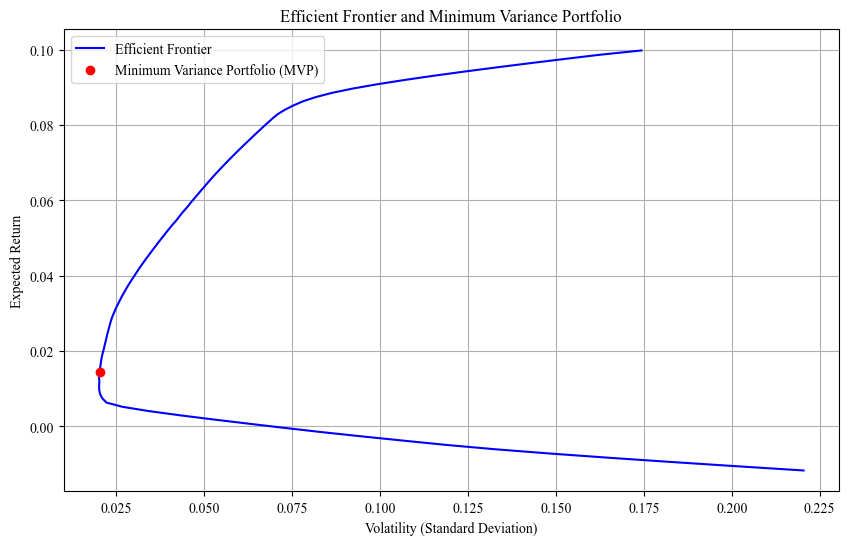

In [149]:

# Function to calculate portfolio variance
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Function to calculate portfolio return
def portfolio_return(weights, mean_returns):
    return np.dot(weights, mean_returns)

# Function to enforce constraints (weights sum to 1)
def weight_constraint(weights):
    return np.sum(weights) - 1

# Function to calculate the efficient frontier
def calculate_efficient_frontier(mean_returns, cov_matrix, num_portfolios=100):
    results = {'Returns': [], 'Volatility': [], 'Weights': []}
    num_assets = len(mean_returns)
    bounds = [(0, 1) for _ in range(num_assets)]  # Long-only portfolio
    constraints = {'type': 'eq', 'fun': weight_constraint}

    # Generate portfolios along the efficient frontier
    target_returns = np.linspace(mean_returns.min(), mean_returns.max(), num_portfolios)
    for target in target_returns:
        def return_constraint(weights):
            return portfolio_return(weights, mean_returns) - target

        constraints_with_return = [constraints, {'type': 'eq', 'fun': return_constraint}]
        result = minimize(portfolio_variance, np.ones(num_assets) / num_assets, args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints_with_return)
        if result.success:
            results['Returns'].append(target)
            results['Volatility'].append(np.sqrt(result.fun))
            results['Weights'].append(result.x)

    return results

# Calculate mean returns and covariance matrix from training data
train_data = train_data.dropna(axis=1, how='all')  # Drop assets with all missing data
mean_returns = train_data.mean() * 12  # Annualize monthly returns
cov_matrix = train_data.cov() * 12  # Annualize covariance matrix

# Calculate the efficient frontier
efficient_frontier = calculate_efficient_frontier(mean_returns, cov_matrix)

# Find the Minimum Variance Portfolio (MVP)
mvp_result = minimize(portfolio_variance, np.ones(len(mean_returns)) / len(mean_returns), args=(cov_matrix,),
                      method='SLSQP', bounds=[(0, 1) for _ in range(len(mean_returns))],
                      constraints={'type': 'eq', 'fun': weight_constraint})
mvp_weights = mvp_result.x
mvp_return = portfolio_return(mvp_weights, mean_returns)
mvp_volatility = np.sqrt(mvp_result.fun)

# Plot the efficient frontier and MVP
plt.figure(figsize=(10, 6))
plt.plot(efficient_frontier['Volatility'], efficient_frontier['Returns'], label='Efficient Frontier', color='blue')
plt.scatter(mvp_volatility, mvp_return, color='red', label='Minimum Variance Portfolio (MVP)', zorder=5)
plt.title('Efficient Frontier and Minimum Variance Portfolio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

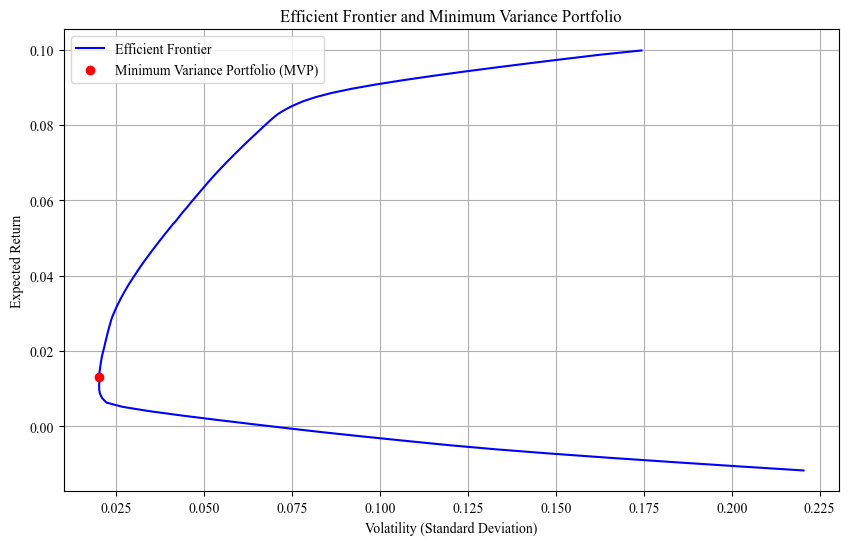

MVP Weights:
                    Asset        Weight
0                   SP500  1.679639e-19
1            Russell 2000  0.000000e+00
2                  NASDAQ  3.220362e-19
3                    FTSE  4.385123e-05
4                     DAX  3.870886e-02
5                   STOXX  1.334572e-18
6                  Nikkei  1.248811e-04
7                    Gold  0.000000e+00
8                     Oil  6.568597e-03
9   10 Year Treasury Note  3.238550e-02
10               TIPS ETF  1.666777e-01
11                Na REIT  0.000000e+00
12                EUR/USD  4.169588e-01
13                JPY/USD  1.113861e-02
14                CHF/USD  3.273932e-01


In [150]:
# Identify the MVP from the efficient frontier
mvp_index = np.argmin(efficient_frontier['Volatility'])  # Index of the minimum volatility
mvp_volatility = efficient_frontier['Volatility'][mvp_index]
mvp_return = efficient_frontier['Returns'][mvp_index]
mvp_weights = efficient_frontier['Weights'][mvp_index]

# Plot the efficient frontier and MVP
plt.figure(figsize=(10, 6))
plt.plot(efficient_frontier['Volatility'], efficient_frontier['Returns'], label='Efficient Frontier', color='blue')
plt.scatter(mvp_volatility, mvp_return, color='red', label='Minimum Variance Portfolio (MVP)', zorder=5)
plt.title('Efficient Frontier and Minimum Variance Portfolio')
plt.xlabel('Volatility (Standard Deviation)')
plt.ylabel('Expected Return')
plt.legend()
plt.grid(True)
plt.show()

# Display MVP weights
mvp_weights_df = pd.DataFrame({'Asset': train_data.columns, 'Weight': mvp_weights})
print("MVP Weights:")
print(mvp_weights_df)

In [151]:
# Convert weights to percentages
mvp_weights_percentage = [weight * 100 for weight in mvp_weights]

# Create a DataFrame to display weights
mvp_weights_df = pd.DataFrame({
    'Asset': train_data.columns,
    'Weight (%)': mvp_weights_percentage
})

# Ensure weights add up to 100%
total_weight = sum(mvp_weights_percentage)
print(f"Total Weight: {total_weight:.5f}%")

# Format the weights to two decimal places
mvp_weights_df['Weight (%)'] = mvp_weights_df['Weight (%)'].map(lambda x: f"{x:.5f}")

# Display the weights
print("MVP Weights in Percentage:")
print(mvp_weights_df)

Total Weight: 100.00000%
MVP Weights in Percentage:
                    Asset Weight (%)
0                   SP500    0.00000
1            Russell 2000    0.00000
2                  NASDAQ    0.00000
3                    FTSE    0.00439
4                     DAX    3.87089
5                   STOXX    0.00000
6                  Nikkei    0.01249
7                    Gold    0.00000
8                     Oil    0.65686
9   10 Year Treasury Note    3.23855
10               TIPS ETF   16.66777
11                Na REIT    0.00000
12                EUR/USD   41.69588
13                JPY/USD    1.11386
14                CHF/USD   32.73932


## 4 - tangent portfolio, commonly called Market portfolio

In [152]:


# Step 1: Estimate Inputs for Optimization
mean_excess_returns = train_data.mean()  # Use train_data directly as it already contains excess returns
cov_matrix = train_data.cov()  # Use train_data directly

# Step 2: Define Sharpe Ratio Optimization
def sharpe_ratio(weights, mean_returns, cov_matrix):
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(portfolio_return / portfolio_volatility)  # Negative for minimization

# Constraints and Bounds
num_assets = len(mean_excess_returns)
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})  # Weights sum to 1
bounds = [(0, 1) for _ in range(num_assets)]  # Long-only portfolio

# Initial Guess for Weights
initial_weights = np.ones(num_assets) / num_assets

# Optimize Weights
result = minimize(sharpe_ratio, initial_weights, args=(mean_excess_returns, cov_matrix),
                  method='SLSQP', bounds=bounds, constraints=constraints)

optimal_weights = result.x

# Step 3: Rebalancing and Transaction Costs
def calculate_portfolio_returns(data, weights, rebalance_freq='M'):
    portfolio_returns = []
    prev_weights = weights
    transaction_costs_adjusted = pd.DataFrame(index=data.index, columns=data.columns)

    # Adjust transaction costs based on asset classes
    for asset in data.columns:
        asset_class = asset_classes.get(asset, "Equity Indexes")  # Default to "Equity Indexes"
        cost = transaction_costs.get(asset_class, 0.001)  # Default to 0.10% if not found
        transaction_costs_adjusted[asset] = cost

    for i in range(1, len(data)):
        # Rebalance periodically
        if i % (1 if rebalance_freq == 'M' else 3) == 0:
            current_weights = weights
        else:
            current_weights = prev_weights

        # Handle missing values by filling them with 0
        current_data = data.iloc[i].fillna(0)

        # Calculate turnover and transaction costs
        turnover = np.sum(np.abs(current_weights - prev_weights))
        transaction_cost = turnover * transaction_costs_adjusted.iloc[i].mean()

        # Calculate portfolio return
        weighted_returns = np.dot(current_weights, current_data)
        portfolio_return = weighted_returns - transaction_cost
        portfolio_returns.append(portfolio_return)

        # Update previous weights
        prev_weights = current_weights

    return pd.Series(portfolio_returns, index=data.index[1:])

# Apply to In-Sample and Out-of-Sample Data
train_portfolio_returns = calculate_portfolio_returns(train_data, optimal_weights)
test_portfolio_returns = calculate_portfolio_returns(test_data, optimal_weights)

# Step 4: Evaluate Performance
def evaluate_performance(portfolio_returns):
    mean_return = portfolio_returns.mean() * 12  # Annualized return
    volatility = portfolio_returns.std() * np.sqrt(12)  # Annualized volatility
    sharpe_ratio = mean_return / volatility
    return mean_return, volatility, sharpe_ratio

train_performance = evaluate_performance(train_portfolio_returns)
test_performance = evaluate_performance(test_portfolio_returns)

print("In-Sample Performance (Train):", train_performance)
print("Out-of-Sample Performance (Test):", test_performance)

# Save Results
train_portfolio_returns.to_csv("market_portfolio_train_returns.csv")
test_portfolio_returns.to_csv("market_portfolio_test_returns.csv")


In-Sample Performance (Train): (0.04142184806448687, 0.03178717300661526, 1.3030994626627077)
Out-of-Sample Performance (Test): (0.016942356366675498, 0.03818018240399626, 0.44374739196903806)


## 5 - 10k - Portfolios

In [153]:
# Define the number of portfolios
num_portfolios = 10000

# Define the minimum weight for each asset
min_weight = 0.0001

# Generate random portfolios
def generate_random_weights(num_assets, num_portfolios):
    weights = np.random.dirichlet(np.ones(num_assets), num_portfolios)
    weights = np.maximum(weights, min_weight)  # Ensure weights are at least min_weight
    weights /= weights.sum(axis=1, keepdims=True)  # Normalize to sum to 1
    return weights

# Calculate portfolio returns
def calculate_portfolio_returns(data, weights, transaction_costs, rebalance_freq='M'):
    portfolio_returns = []
    prev_weights = weights  # Use the same weights throughout the simulation
    for i in range(1, len(data)):
        # Handle missing values by filling them with 0
        current_data = data.iloc[i].fillna(0)

        # Calculate turnover and transaction costs
        turnover = np.sum(np.abs(weights - prev_weights))
        transaction_cost = 0
        for asset, weight_diff in zip(data.columns, np.abs(weights - prev_weights)):
            asset_class = asset_classes.get(asset, "Equity Indexes")  # Default to "Equity Indexes"
            cost = transaction_costs.get(asset_class, 0.001)  # Default to 0.10% if not found
            transaction_cost += weight_diff * cost

        # Calculate portfolio return
        weighted_returns = np.dot(weights, current_data)
        portfolio_return = weighted_returns - transaction_cost
        portfolio_returns.append(portfolio_return)

        # Update previous weights
        prev_weights = weights

    return pd.Series(portfolio_returns, index=data.index[1:])

# Example usage
num_assets = train_data.shape[1]
random_weights = generate_random_weights(num_assets, num_portfolios)

# Simulate portfolio returns and save weights
portfolio_results = []
portfolio_weights = []

for i in range(num_portfolios):
    portfolio_return = calculate_portfolio_returns(train_data, random_weights[i], transaction_costs)
    portfolio_results.append(portfolio_return)
    portfolio_weights.append(random_weights[i])  # Save weights for each portfolio

# Combine results into DataFrames
portfolio_results_df = pd.DataFrame(portfolio_results).T
portfolio_weights_df = pd.DataFrame(portfolio_weights, columns=train_data.columns)

# Save to CSV
portfolio_results_df.to_csv("random_portfolios_returns.csv", index=False)
portfolio_weights_df.to_csv("random_portfolios_weights.csv", index=False)

print("Portfolio returns saved to 'random_portfolios_returns.csv'")
print("Portfolio weights saved to 'random_portfolios_weights.csv'")

KeyboardInterrupt: 

In [154]:
# Read the portfolio returns and weights from CSV
portfolio_results_df = pd.read_csv("random_portfolios_returns.csv")
portfolio_weights_df = pd.read_csv("random_portfolios_weights.csv")

In [155]:
portfolio_results_df.head()

0         1         2         3         4         5         6  \
0 -0.031492 -0.020833 -0.028470 -0.035372 -0.035223 -0.034718 -0.039756   
1 -0.046050 -0.024426 -0.059003 -0.037043 -0.067250 -0.059130 -0.071010   
2 -0.007993  0.002676 -0.010761 -0.001243 -0.000504 -0.003594 -0.009656   
3 -0.001982  0.006191 -0.002971  0.009832 -0.003986  0.002050 -0.000009   
4 -0.002795  0.000145  0.029825 -0.001796  0.020975 -0.001685  0.002242   

          7         8         9  ...      9990      9991      9992      9993  \
0 -0.034337 -0.036287 -0.030808  ... -0.037286 -0.021994 -0.027369 -0.033500   
1 -0.054946 -0.038136 -0.068390  ... -0.031470 -0.067198 -0.058288 -0.062484   
2 -0.001804 -0.028310 -0.002245  ... -0.013539 -0.006805 -0.001228 -0.023278   
3  0.009036 -0.009254  0.009674  ... -0.001051  0.003384  0.002349 -0.007440   
4  0.008185 -0.006612  0.008851  ... -0.005773  0.009468  0.014896  0.003568   

       9994      9995      9996      9997      9998      9999  
0 -0.027883 -0.040014 -0.020739 -0.030693 -0.029211 -0.035601  
1 -0.069229 -0.104114 -0.032939 -0.038942 -0.038831 -0.087533  
2 -0.008786 -0.015299 -0.013467 -0.002573  0.002440 -0.000183  
3 -0.001783 -0.000570 -0.000369  0.000584 -0.000394  0.005460  
4  0.027718  0.047025  0.005671 -0.001809  0.010249  0.009736  

[5 rows x 10000 columns]

## 6 - Only Stock-Indexes Portfolios

In [156]:
# Filter data to include only stock indexes
stock_indexes = ['SP500', 'Russell 2000', 'NASDAQ', 'FTSE', 'DAX', 'STOXX', 'Nikkei']
stock_index_data = train_data[stock_indexes].dropna(axis=1, how='all')  # Drop assets with all missing data


# Function to calculate portfolio returns with rebalancing and transaction costs
def calculate_stock_index_portfolio(data, rebalance_freq='M'):
    # Initialize portfolio weights (equal weights)
    num_assets = data.shape[1]
    weights = pd.DataFrame(index=data.index, columns=data.columns)
    weights.iloc[0] = 1 / num_assets  # Equal weights initially

    # Adjust weights for rebalancing frequency
    for i in range(1, len(weights)):
        if i % (1 if rebalance_freq == 'M' else 3) == 0:  # Rebalance monthly or quarterly
            weights.iloc[i] = 1 / num_assets
        else:
            weights.iloc[i] = weights.iloc[i - 1]  # Carry forward weights

    # Calculate portfolio returns
    portfolio_returns = []
    prev_weights = weights.iloc[0]
    for i in range(1, len(data)):
        # Handle missing values by filling them with 0
        current_data = data.iloc[i].fillna(0)

        # Calculate turnover and transaction costs
        turnover = np.sum(np.abs(weights.iloc[i] - prev_weights))
        transaction_cost = 0
        for asset, weight_diff in zip(data.columns, np.abs(weights.iloc[i] - prev_weights)):
            asset_class = "Equity Indexes"  # Default to Equity Indexes for stock indexes
            cost = transaction_costs.get(asset_class, 0.0005)  # Default to 0.05% if not found
            transaction_cost += weight_diff * cost

        # Calculate weighted returns
        weighted_returns = (weights.iloc[i] * current_data).sum()
        portfolio_return = weighted_returns - transaction_cost
        portfolio_returns.append(portfolio_return)

        # Update previous weights
        prev_weights = weights.iloc[i]

    # Convert to Series
    portfolio_returns = pd.Series(portfolio_returns, index=data.index[1:])
    return portfolio_returns

# Apply the function to training and testing data
stock_index_train_returns = calculate_stock_index_portfolio(stock_index_data)
stock_index_test_returns = calculate_stock_index_portfolio(test_data[stock_indexes].dropna(axis=1, how='all'))

# Display results
print("Stock Index Portfolio (Train) Returns:")
print(stock_index_train_returns.head())

print("\nStock Index Portfolio (Test) Returns:")
print(stock_index_test_returns.head())

# Save results to CSV
stock_index_train_returns.to_csv("stock_index_portfolio_train_returns.csv")
stock_index_test_returns.to_csv("stock_index_portfolio_test_returns.csv")

Stock Index Portfolio (Train) Returns:
Date
1980-02-29   -0.003805
1980-03-31   -0.044724
1980-04-30    0.023352
1980-05-31    0.027588
1980-06-30    0.016089
Freq: ME, dtype: float64

Stock Index Portfolio (Test) Returns:
Date
2011-02-28    0.031458
2011-03-31   -0.020543
2011-04-30    0.031677
2011-05-31   -0.022389
2011-06-30   -0.007668
Freq: ME, dtype: float64


## 7 - Alternative Assets Only Portfolios

In [157]:
# Filter data to include only alternative assets 
alternative_assets = ['Gold', 'Oil', 'Na REIT']
alternative_assets_data = train_data[alternative_assets].dropna(axis=1, how='all')  # Drop assets with all missing data

# Function to calculate portfolio returns with rebalancing and transaction costs
def calculate_alternative_assets_portfolio(data, rebalance_freq='M'):
    # Initialize portfolio weights (equal weights)
    num_assets = data.shape[1]
    weights = pd.DataFrame(index=data.index, columns=data.columns)
    weights.iloc[0] = 1 / num_assets  # Equal weights initially

    # Adjust weights for rebalancing frequency
    for i in range(1, len(weights)):
        if i % (1 if rebalance_freq == 'M' else 3) == 0:  # Rebalance monthly or quarterly
            weights.iloc[i] = 1 / num_assets
        else:
            weights.iloc[i] = weights.iloc[i - 1]  # Carry forward weights

    # Calculate portfolio returns
    portfolio_returns = []
    prev_weights = weights.iloc[0]
    for i in range(1, len(data)):
        # Handle missing values by filling them with 0
        current_data = data.iloc[i].fillna(0)

        # Calculate turnover and transaction costs
        turnover = np.sum(np.abs(weights.iloc[i] - prev_weights))
        transaction_cost = 0
        for asset, weight_diff in zip(data.columns, np.abs(weights.iloc[i] - prev_weights)):
            asset_class = asset_classes.get(asset, "REITs")
            cost = transaction_costs.get(asset_class, 0.001)  # Default to 0.10% if not found
            transaction_cost += weight_diff * cost

        # Calculate weighted returns
        weighted_returns = (weights.iloc[i] * current_data).sum()
        portfolio_return = weighted_returns - transaction_cost
        portfolio_returns.append(portfolio_return)

        # Update previous weights
        prev_weights = weights.iloc[i]

    # Convert to Series
    portfolio_returns = pd.Series(portfolio_returns, index=data.index[1:])
    return portfolio_returns

# Apply the function to training and testing data
alternative_assets_train_returns = calculate_alternative_assets_portfolio(alternative_assets_data)
alternative_assets_test_returns = calculate_alternative_assets_portfolio(test_data[alternative_assets].dropna(axis=1, how='all'))

# Display results
print("Alternative Assets Portfolio (Train) Returns:")
print(alternative_assets_train_returns.head())

print("\nAlternative Assets Portfolio (Test) Returns:")
print(alternative_assets_test_returns.head())

# Save results to CSV
alternative_assets_train_returns.to_csv("alternative_assets_portfolio_train_returns.csv")
alternative_assets_test_returns.to_csv("alternative_assets_portfolio_test_returns.csv")

Alternative Assets Portfolio (Train) Returns:
Date
1980-02-29   -0.012471
1980-03-31   -0.132073
1980-04-30    0.041850
1980-05-31    0.035417
1980-06-30    0.084990
Freq: ME, dtype: float64

Alternative Assets Portfolio (Test) Returns:
Date
2011-02-28    0.050792
2011-03-31    0.031690
2011-04-30    0.067486
2011-05-31   -0.038318
2011-06-30   -0.040988
Freq: ME, dtype: float64


## 8 - Bonds Only Portfolios

In [158]:
# Filter data to include only bond assets
bond_assets = ['10 Year Treasury Note', 'TIPS ETF']
bond_assets_data = train_data[bond_assets].dropna(axis=1, how='all')  # Drop assets with all missing data

# Function to calculate portfolio returns with rebalancing and transaction costs
def calculate_bonds_portfolio(data, rebalance_freq='M'):
    # Initialize portfolio weights (equal weights)
    num_assets = data.shape[1]
    weights = pd.DataFrame(index=data.index, columns=data.columns)
    weights.iloc[0] = 1 / num_assets  # Equal weights initially

    # Adjust weights for rebalancing frequency
    for i in range(1, len(weights)):
        if i % (1 if rebalance_freq == 'M' else 3) == 0:  # Rebalance monthly or quarterly
            weights.iloc[i] = 1 / num_assets
        else:
            weights.iloc[i] = weights.iloc[i - 1]  # Carry forward weights

    # Calculate portfolio returns
    portfolio_returns = []
    prev_weights = weights.iloc[0]
    for i in range(1, len(data)):
        # Handle missing values by filling them with 0
        current_data = data.iloc[i].fillna(0)

        # Calculate turnover and transaction costs
        turnover = np.sum(np.abs(weights.iloc[i] - prev_weights))
        transaction_cost = 0
        for asset, weight_diff in zip(data.columns, np.abs(weights.iloc[i] - prev_weights)):
            asset_class = asset_classes.get(asset, "Treasury Bonds")
            cost = transaction_costs.get(asset_class, 0.0003)  # Default to 0.03% if not found
            transaction_cost += weight_diff * cost

        # Calculate weighted returns
        weighted_returns = (weights.iloc[i] * current_data).sum()
        portfolio_return = weighted_returns - transaction_cost
        portfolio_returns.append(portfolio_return)

        # Update previous weights
        prev_weights = weights.iloc[i]

    # Convert to Series
    portfolio_returns = pd.Series(portfolio_returns, index=data.index[1:])
    return portfolio_returns

# Apply the function to training and testing data
bonds_train_returns = calculate_bonds_portfolio(bond_assets_data)
bonds_test_returns = calculate_bonds_portfolio(test_data[bond_assets].dropna(axis=1, how='all'))

# Display results
print("Bonds Portfolio (Train) Returns:")
print(bonds_train_returns.head())

print("\nBonds Portfolio (Test) Returns:")
print(bonds_test_returns.head())

# Save results to CSV
bonds_train_returns.to_csv("bonds_portfolio_train_returns.csv")
bonds_test_returns.to_csv("bonds_portfolio_test_returns.csv")

Bonds Portfolio (Train) Returns:
Date
1980-02-29   -0.026133
1980-03-31    0.023321
1980-04-30    0.040207
1980-05-31    0.018690
1980-06-30    0.014301
Freq: ME, dtype: float64

Bonds Portfolio (Test) Returns:
Date
2011-02-28    0.002716
2011-03-31    0.004407
2011-04-30    0.016299
2011-05-31    0.010964
2011-06-30   -0.003966
Freq: ME, dtype: float64


## 9 - FX Only Portfolios

In [159]:
# Filter data to include only FX pairs
fx_assets = ['EUR/USD', 'JPY/USD', 'CHF/USD']
fx_assets_data = train_data[fx_assets].dropna(axis=1, how='all')  # Drop assets with all missing data

# Function to calculate FX portfolio returns with rebalancing and transaction costs
def calculate_fx_portfolio(data, rebalance_freq='M'):
    # Initialize portfolio weights (equal weights)
    num_assets = data.shape[1]
    weights = pd.DataFrame(index=data.index, columns=data.columns)
    weights.iloc[0] = 1 / num_assets  # Equal weights initially

    # Adjust weights for rebalancing frequency
    for i in range(1, len(weights)):
        if i % (1 if rebalance_freq == 'M' else 3) == 0:  # Rebalance monthly or quarterly
            weights.iloc[i] = 1 / num_assets
        else:
            weights.iloc[i] = weights.iloc[i - 1]  # Carry forward weights

    # Calculate portfolio returns
    portfolio_returns = []
    prev_weights = weights.iloc[0]
    for i in range(1, len(data)):
        # Handle missing values by filling them with 0
        current_data = data.iloc[i].fillna(0)

        # Calculate turnover and transaction costs
        turnover = np.sum(np.abs(weights.iloc[i] - prev_weights))
        transaction_cost = 0
        for asset, weight_diff in zip(data.columns, np.abs(weights.iloc[i] - prev_weights)):
            asset_class = asset_classes.get(asset, "FX – Major Pairs")
            cost = transaction_costs.get(asset_class, 0.0003)  # Default to 0.03% if not found
            transaction_cost += weight_diff * cost

        # Calculate weighted returns
        weighted_returns = (weights.iloc[i] * current_data).sum()
        portfolio_return = weighted_returns - transaction_cost
        portfolio_returns.append(portfolio_return)

        # Update previous weights
        prev_weights = weights.iloc[i]

    # Convert to Series
    portfolio_returns = pd.Series(portfolio_returns, index=data.index[1:])
    return portfolio_returns

# Apply the function to training and testing data
fx_train_returns = calculate_fx_portfolio(fx_assets_data)
fx_test_returns = calculate_fx_portfolio(test_data[fx_assets].dropna(axis=1, how='all'))

# Display results
print("FX Portfolio (Train) Returns:")
print(fx_train_returns.head())

print("\nFX Portfolio (Test) Returns:")
print(fx_test_returns.head())

# Save results to CSV
fx_train_returns.to_csv("fx_portfolio_train_returns.csv")
fx_test_returns.to_csv("fx_portfolio_test_returns.csv")

FX Portfolio (Train) Returns:
Date
1980-02-29   -0.026037
1980-03-31    0.002660
1980-04-30    0.026029
1980-05-31    0.020770
1980-06-30    0.007196
Freq: ME, dtype: float64

FX Portfolio (Test) Returns:
Date
2011-02-28    0.003849
2011-03-31   -0.010544
2011-04-30    0.013242
2011-05-31    0.012324
2011-06-30    0.006969
Freq: ME, dtype: float64


## 10 - Inflation - Hedging

In [160]:
# Filter data to include inflation-hedging assets
inflation_hedging_assets = ['Gold', 'Oil', 'TIPS ETF', 'Na REIT']
inflation_hedging_data = train_data[inflation_hedging_assets].dropna(axis=1, how='all')  # Drop assets with all missing data

# Function to calculate Inflation-Hedging Portfolio returns
def calculate_inflation_hedging_portfolio(data, rebalance_freq='M'):
    # Initialize portfolio weights (equal weights)
    num_assets = data.shape[1]
    weights = pd.DataFrame(index=data.index, columns=data.columns)
    weights.iloc[0] = 1 / num_assets  # Equal weights initially

    # Adjust weights for rebalancing frequency
    for i in range(1, len(weights)):
        if i % (1 if rebalance_freq == 'M' else 3) == 0:  # Rebalance monthly or quarterly
            weights.iloc[i] = 1 / num_assets
        else:
            weights.iloc[i] = weights.iloc[i - 1]  # Carry forward weights

    # Calculate portfolio returns
    portfolio_returns = []
    prev_weights = weights.iloc[0]
    for i in range(1, len(data)):
        # Handle missing values by filling them with 0
        current_data = data.iloc[i].fillna(0)

        # Calculate turnover and transaction costs
        turnover = np.sum(np.abs(weights.iloc[i] - prev_weights))
        transaction_cost = 0
        for asset, weight_diff in zip(data.columns, np.abs(weights.iloc[i] - prev_weights)):
            asset_class = asset_classes.get(asset, "REITs")
            cost = transaction_costs.get(asset_class, 0.001)  # Default to 0.10% if not found
            transaction_cost += weight_diff * cost

        # Calculate weighted returns
        weighted_returns = (weights.iloc[i] * current_data).sum()
        portfolio_return = weighted_returns - transaction_cost
        portfolio_returns.append(portfolio_return)

        # Update previous weights
        prev_weights = weights.iloc[i]

    # Convert to Series
    portfolio_returns = pd.Series(portfolio_returns, index=data.index[1:])
    return portfolio_returns

# Apply the function to training and testing data
inflation_hedging_train_returns = calculate_inflation_hedging_portfolio(inflation_hedging_data)
inflation_hedging_test_returns = calculate_inflation_hedging_portfolio(test_data[inflation_hedging_assets].dropna(axis=1, how='all'))

# Save results to CSV
inflation_hedging_train_returns.to_csv("inflation_hedging_portfolio_train_returns.csv")
inflation_hedging_test_returns.to_csv("inflation_hedging_portfolio_test_returns.csv")

## 11 - Defensive Portfolio

In [161]:
# Filter data to include defensive assets
defensive_assets = ['10 Year Treasury Note', 'TIPS ETF', 'Na REIT', 'CHF/USD']
defensive_data = train_data[defensive_assets].dropna(axis=1, how='all')  # Drop assets with all missing data

# Function to calculate Defensive Portfolio returns
def calculate_defensive_portfolio(data, rebalance_freq='M'):
    # Initialize portfolio weights (equal weights)
    num_assets = data.shape[1]
    weights = pd.DataFrame(index=data.index, columns=data.columns)
    weights.iloc[0] = 1 / num_assets  # Equal weights initially

    # Adjust weights for rebalancing frequency
    for i in range(1, len(weights)):
        if i % (1 if rebalance_freq == 'M' else 3) == 0:  # Rebalance monthly or quarterly
            weights.iloc[i] = 1 / num_assets
        else:
            weights.iloc[i] = weights.iloc[i - 1]  # Carry forward weights

    # Calculate portfolio returns
    portfolio_returns = []
    prev_weights = weights.iloc[0]
    for i in range(1, len(data)):
        # Handle missing values by filling them with 0
        current_data = data.iloc[i].fillna(0)

        # Calculate turnover and transaction costs
        turnover = np.sum(np.abs(weights.iloc[i] - prev_weights))
        transaction_cost = 0
        for asset, weight_diff in zip(data.columns, np.abs(weights.iloc[i] - prev_weights)):
            asset_class = asset_classes.get(asset, "Treasury Bonds")
            cost = transaction_costs.get(asset_class, 0.0003)  # Default to 0.03% if not found
            transaction_cost += weight_diff * cost

        # Calculate weighted returns
        weighted_returns = (weights.iloc[i] * current_data).sum()
        portfolio_return = weighted_returns - transaction_cost
        portfolio_returns.append(portfolio_return)

        # Update previous weights
        prev_weights = weights.iloc[i]

    # Convert to Series
    portfolio_returns = pd.Series(portfolio_returns, index=data.index[1:])
    return portfolio_returns

# Apply the function to training and testing data
defensive_train_returns = calculate_defensive_portfolio(defensive_data)
defensive_test_returns = calculate_defensive_portfolio(test_data[defensive_assets].dropna(axis=1, how='all'))

# Save results to CSV
defensive_train_returns.to_csv("defensive_portfolio_train_returns.csv")
defensive_test_returns.to_csv("defensive_portfolio_test_returns.csv")

## 12 - The Efficient Surface

# Portfolios' Performance Measurement 

In [162]:

# Define a function to calculate performance metrics
def calculate_performance_metrics(portfolio_returns):
    """
    Calculate performance metrics for a portfolio.

    Parameters:
        portfolio_returns (pd.Series): Portfolio returns.

    Returns:
        dict: Dictionary containing performance metrics.
    """
    # Annualized Return
    annualized_return = portfolio_returns.mean() * 12

    # Annualized Volatility
    annualized_volatility = portfolio_returns.std() * np.sqrt(12)

    # Sharpe Ratio (without risk-free rate)
    sharpe_ratio = annualized_return / annualized_volatility

    # Maximum Drawdown
    cumulative_returns = (1 + portfolio_returns).cumprod()
    drawdown = cumulative_returns / cumulative_returns.cummax() - 1
    max_drawdown = drawdown.min()

    return {
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Maximum Drawdown": max_drawdown,
    }

# List of portfolio CSV files (excluding 10k portfolios)
portfolio_files = [
    "ew_portfolio_train_returns.csv", "ew_portfolio_test_returns.csv",
    "60_40_portfolio_train_returns.csv", "60_40_portfolio_test_returns.csv",
    "min_var_portfolio_train_weights.csv", "min_var_portfolio_test_weights.csv",
    "stock_index_portfolio_train_returns.csv", "stock_index_portfolio_test_returns.csv",
    "alternative_assets_portfolio_train_returns.csv", "alternative_assets_portfolio_test_returns.csv",
    "bonds_portfolio_train_returns.csv", "bonds_portfolio_test_returns.csv",
    "fx_portfolio_train_returns.csv", "fx_portfolio_test_returns.csv",
    "inflation_hedging_portfolio_train_returns.csv", "inflation_hedging_portfolio_test_returns.csv",
    "defensive_portfolio_train_returns.csv", "defensive_portfolio_test_returns.csv",
]

# Initialize a DataFrame to store performance metrics
performance_metrics = []

# Loop through each portfolio file and calculate metrics
for file in portfolio_files:
    # Load portfolio returns
    portfolio_returns = pd.read_csv(file, index_col=0).squeeze()  # Use .squeeze() after reading the file

    # Calculate metrics
    metrics = calculate_performance_metrics(portfolio_returns)

    # Append results to the DataFrame
    performance_metrics.append({
        "Portfolio": file.replace("_returns.csv", ""),
        **metrics
    })

# Convert results to a DataFrame
performance_metrics_df = pd.DataFrame(performance_metrics)

# Save the performance metrics to a CSV file
performance_metrics_df.to_csv("portfolio_performance_metrics.csv", index=False)

# Display the performance metrics
print(performance_metrics_df)

                              Portfolio  \
0                    ew_portfolio_train   
1                     ew_portfolio_test   
2                 60_40_portfolio_train   
3                  60_40_portfolio_test   
4   min_var_portfolio_train_weights.csv   
5    min_var_portfolio_test_weights.csv   
6           stock_index_portfolio_train   
7            stock_index_portfolio_test   
8    alternative_assets_portfolio_train   
9     alternative_assets_portfolio_test   
10                bonds_portfolio_train   
11                 bonds_portfolio_test   
12                   fx_portfolio_train   
13                    fx_portfolio_test   
14    inflation_hedging_portfolio_train   
15     inflation_hedging_portfolio_test   
16            defensive_portfolio_train   
17             defensive_portfolio_test   

                                    Annualized Return  \
0                                            0.045356   
1                                            0.043159   
2          

# Portfolios Regressions

### Minimum Variance Portfolio with Inflation in Z Axis